## Datasets & Params¶


In [1]:
# Choose alpha value between 0-1
# ALPHA = 1.0

# Choose Dataset

# Experiment 1
# DATASET_NAME ='COMPAS_RACE_AM'

# Experiment 2
#DATASET_NAME = 'COMPAS_SEX'

# Experiment 3
DATASET_NAME = 'ADULT_RACE'

# Experiment 4
#DATASET_NAME = 'ADULT_SEX'

# Experiment 5
# DATASET_NAME='CREDIT_SEX'

# Experiment 6
# DATASET_NAME = 'BANK_AGE'

# Experiment 7
#DATASET_NAME = 'RECRUIT_AGE'

# Experiment 8
#DATASET_NAME = 'RECRUIT_SEX'

# Experiment 9
#DATASET_NAME = 'DIABETES_SEX'

# Experiment 9
# DATASET_NAME = 'NURSERY'

# Experiment 9
# DATASET_NAME = 'DEFAULT_CREDIT'

In [2]:
# upload kaggle.json file using user prompt
from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving adult.csv to adult.csv
User uploaded file "adult.csv" with length 4104734 bytes


## Imports

In [3]:
! pip install ctgan
! pip install --upgrade category_encoders

from sklearn.preprocessing import MinMaxScaler

import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import category_encoders as ce
import math
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, confusion_matrix
import os
from statistics import mean
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
from datetime import datetime
import pprint
import json



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 69.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

## Fairness metrics and functions


In [4]:
def print_metrics(y_gt, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_gt, y_pred).ravel()
    print('conf matrix:\n ', confusion_matrix(y_gt, y_pred) ,
          '\naccuracy: ', (tp+tn)/(tp+tn+fn+fp),
          'precision: ', tp/(tp+fp),
          'recall: ', tp/(tp+fn),
          'fpr: ', fp/(fp+tn),
          'tpr: ', tp /(tp + fn),
          'fn+fp', fn+fp)
    #returm fpr, tpr, accuracy
    return fp/(fp+tn), tp /(tp + fn), (tp+tn)/(tp+tn+fn+fp)

# bias metric - equal opportunity difference
def opportunity_diff_tpr(tpr1, tpr2):
    return abs(tpr1-tpr2)

# bias metric - equal opportunity difference
def opportunity_diff_fpr(fpr1, fpr2):
    return abs(fpr1-fpr2)

# bias metric - avarage absolute odds difference
def odds_diff(tpr1, tpr2, fpr1, fpr2):
    return 0.5*(abs(tpr2-tpr1) + abs(fpr2-fpr1))

# bias metric - statistical parity difference
def parity_diff(y_pred_0, y_pred_1):
    return abs(len(y_pred_0)/(len(y_pred_0)+len(y_pred_1)) - len(y_pred_1)/(len(y_pred_1)+len(y_pred_0)))


    # bias metric - Disparate impact
def disparate_impact(y_pred_0, y_pred_1):
    return 1
    #return min((len(y_pred_0)/len(y_pred_0+y_pred_1)) / (len(y_pred_1)/len(y_pred_1+len(y_pred_0)))
    #,(len(y_pred_1)/len(y_pred_0+y_pred_1)) / (len(y_pred_0)/len(y_pred_1+len(y_pred_0))))

def fairness_metrics_roc_auc_std(data , y):
    clf = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=1234)

    cv = StratifiedKFold(n_splits=5, random_state=1234, shuffle=True)
    results = pd.DataFrame(columns=['training_score', 'test_score'])

    fprs, tprs, scores, op_list ,op_f_list, od_list ,par_dif_list,dis_impact_list, acc_list = [], [], [], [],[], [], [],[],[]

    start_time = datetime.now()
    for (train, test), i in zip(cv.split(data, y), range(5)):
        clf.fit(data.iloc[train], y.iloc[train])
        _, _, auc_score_train = compute_roc_auc(train,clf, data, y)
        fpr, tpr, auc_score = compute_roc_auc(test,clf, data, y)
        scores.append((auc_score_train, auc_score))
        fprs.append(fpr)
        tprs.append(tpr)
        y_pred = clf.predict(data.iloc[test])
        o_p, o_p_fpr, o_d ,par_dif, dis_impact, acc_ = calc_bias(data.iloc[test],  y.iloc[test], PRIV_FEATURE,y_pred, 'subexperiment - baseline Ensemble'+' model:'+str(i))
        acc_list.append(acc_)
        op_list.append(o_p)
        op_f_list.append(o_p_fpr)
        od_list.append(o_d)
        par_dif_list.append(par_dif)
        dis_impact_list.append(dis_impact)

    std_op = np.std(op_list)
    op_str = f"{mean(op_list):.3f} ± {std_op:.3f}"

    std_op_f = np.std(op_f_list)
    op_f_str = f"{mean(op_f_list):.3f} ± {std_op_f:.3f}"

    std_od = np.std(od_list)
    od_str = f"{mean(od_list):.3f} ± {std_od:.3f}"

    std_par_dif = np.std(par_dif_list)
    par_dif_str = f"{mean(par_dif_list):.3f} ± {std_par_dif:.3f}"

    std_dis_impact = np.std(dis_impact_list)
    dis_imp_str = f"{mean(dis_impact_list):.3f} ± {std_dis_impact:.3f}"


    std_acc = np.std(acc_list)
    acc_str = f"{mean(acc_list):.3f} ± {std_acc:.3f}"
    time_elapsed_baseline = datetime.now() - start_time
    plot_roc_curve(fprs, tprs);
    pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])
    print('Accaracy list : ', acc_list)
    print('equal opportunity for tpr : ', op_list)
    print('equal opportunity for fpr : ',op_f_list)
    print('odds difference list : ' , od_list)
    print('The mean accuracy is ', acc_str)
    print('The mean equal opportunity for tpr: (close to 0)', op_str)
    print('The mean equal opportunity for fpr: (close to 0)', op_f_str)
    print('The mean odds difference: (close to 0)',od_str)
    print('The mean parity difference: (close to 0)', par_dif_str)
    print('The mean disperate impact: (close to 1)',dis_imp_str)

    return acc_str, op_str, op_f_str ,od_str,par_dif_str , dis_imp_str

In [5]:
# calculate the bias of divided dataset by the privileged feature
def calc_bias(data,y, priv_feature,y_pred, experiment_text):
    data_full =  pd.concat([data, y], axis=1)
    data_full['y_pred'] = y_pred

    label = TARGET_COL
    # print('performance for whole ds:'+ experiment_text)
    fpr, tpr, acc = print_metrics(data_full[TARGET_COL], data_full['y_pred'] )

    feature_cat_list = list(data[priv_feature].unique())
    #print(feature_cat_list)
    valid_cat0 = data_full[data_full[priv_feature]==feature_cat_list[0]]
    valid_cat1 = data_full[data_full[priv_feature]==feature_cat_list[1]]
    # print('performance for 0 sub-group:')
    fpr_0, tpr_0 , acc_0 = print_metrics(valid_cat0[TARGET_COL], valid_cat0['y_pred'])
    # print('performance for 1 sub-group:')

    fpr_1, tpr_1, acc_1 = print_metrics(valid_cat1[TARGET_COL], valid_cat1['y_pred'])
    op_diff = opportunity_diff_tpr(tpr_0, tpr_1)
    op_diff_fpr = opportunity_diff_fpr(fpr_0, fpr_1)
    od_diff = odds_diff(tpr_0, tpr_1, fpr_0, fpr_1)
    par_diff = parity_diff(valid_cat0[valid_cat0['y_pred']==1], valid_cat1[valid_cat1['y_pred']==1])
    dis_impact = disparate_impact(valid_cat0[valid_cat0['y_pred']==1], valid_cat1[valid_cat1['y_pred']==1])
    # print('bias metrics:')
    # print('equal opportunity for tpr: (close to 0)', op_diff)
    # print('equal opportunity for fpr: (close to 0)', op_diff_fpr)
    # print('avarage absolute odds difference: (close to 0)',od_diff)
    # print('statistical parity difference: (close to 0) ',par_diff)
    # print('disparate_impact: (close to 1) ',dis_impact)


    return (op_diff,op_diff_fpr, od_diff,par_diff ,dis_impact,acc)

In [6]:
def fairness_metrics_roc_auc(data , y):
    clf = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=1234)

    cv = StratifiedKFold(n_splits=5, random_state=1234, shuffle=True)

    results = pd.DataFrame(columns=['training_score', 'test_score'])

    fprs, tprs, scores, op_list ,op_f_list, od_list ,par_dif_list,dis_impact_list, acc_list = [], [], [], [],[], [], [],[],[]

    start_time = datetime.now()
    for (train, test), i in zip(cv.split(data, y), range(5)):
        clf.fit(data.iloc[train], y.iloc[train])
        _, _, auc_score_train = compute_roc_auc(train,clf, data, y)
        fpr, tpr, auc_score = compute_roc_auc(test,clf, data, y)
        scores.append((auc_score_train, auc_score))
        fprs.append(fpr)
        tprs.append(tpr)
        y_pred = clf.predict(data.iloc[test])
        o_p, o_p_fpr, o_d ,par_dif, dis_impact, acc_ = calc_bias(data.iloc[test],  y.iloc[test], PRIV_FEATURE,y_pred, 'subexperiment - baseline Ensemble'+' model:'+str(i))
        acc_list.append(acc_)
        op_list.append(o_p)
        op_f_list.append(o_p_fpr)
        od_list.append(o_d)
        par_dif_list.append(par_dif)
        dis_impact_list.append(dis_impact)

    std_op = np.std(op_list)
    op_str = f"{mean(op_list):.3f} ± {std_op:.3f}"

    std_op_f = np.std(op_f_list)
    op_f_str = f"{mean(op_f_list):.3f} ± {std_op_f:.3f}"

    std_od = np.std(od_list)
    od_str = f"{mean(od_list):.3f} ± {std_od:.3f}"

    std_par_dif = np.std(par_dif_list)
    par_dif_str = f"{mean(par_dif_list):.3f} ± {std_par_dif:.3f}"

    std_dis_impact = np.std(dis_impact_list)
    dis_imp_str = f"{mean(dis_impact_list):.3f} ± {std_dis_impact:.3f}"


    std_acc = np.std(acc_list)
    acc_str = f"{mean(acc_list):.3f} ± {std_acc:.3f}"
    time_elapsed_baseline = datetime.now() - start_time
    plot_roc_curve(fprs, tprs);
    pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])
    print('Accaracy list : ', acc_list)
    print('equal opportunity for tpr : ', op_list)
    print('equal opportunity for fpr : ',op_f_list)
    print('odds difference list : ' , od_list)
    print('The mean accuracy is ', acc_str)
    print('The mean equal opportunity for tpr: (close to 0)', op_str)
    print('The mean equal opportunity for fpr: (close to 0)', op_f_str)
    print('The mean odds difference: (close to 0)',od_str)
    print('The mean parity difference: (close to 0)', par_dif_str)
    print('The mean disperate impact: (close to 1)',dis_imp_str)

    return acc_list, op_list, op_f_list ,od_list,par_dif_list , dis_impact_list

In [7]:
def fairness_metrics_roc_auc_no_print(data , y):
    clf = RandomForestClassifier(n_estimators=10, max_depth=5,random_state=1234)

    cv = StratifiedKFold(n_splits=5, random_state=1234, shuffle=True)

    results = pd.DataFrame(columns=['training_score', 'test_score'])

    fprs, tprs, scores, op_list ,op_f_list, od_list ,par_dif_list,dis_impact_list, acc_list = [], [], [], [],[], [], [],[],[]

    start_time = datetime.now()
    for (train, test), i in zip(cv.split(data, y), range(5)):
        clf.fit(data.iloc[train], y.iloc[train])
        _, _, auc_score_train = compute_roc_auc(train,clf, data, y)
        fpr, tpr, auc_score = compute_roc_auc(test,clf, data, y)
        scores.append((auc_score_train, auc_score))
        fprs.append(fpr)
        tprs.append(tpr)
        y_pred = clf.predict(data.iloc[test])
        o_p, o_p_fpr, o_d ,par_dif, dis_impact, acc_ = calc_bias(data.iloc[test],  y.iloc[test], PRIV_FEATURE,y_pred, 'subexperiment - baseline Ensemble'+' model:'+str(i))
        acc_list.append(acc_)
        op_list.append(o_p)
        op_f_list.append(o_p_fpr)
        od_list.append(o_d)
        par_dif_list.append(par_dif)
        dis_impact_list.append(dis_impact)

    return acc_list, op_list, op_f_list ,od_list,par_dif_list , dis_impact_list

## Roc & AUC functions¶


In [8]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""

    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs, acc = [], []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))

    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index,clf ,data, y):
    y_predict = clf.predict_proba(data.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

In [9]:
if DATASET_NAME == 'ADULT_SEX':
    TARGET_COL = 'income'
    PRIV_FEATURE = "sex"
    PRIV_CLASS = 1
    PRIV_VALUE_FEATURE = 1
    orig_data = pd.read_csv('/content/adult.csv')
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == '<=50K' else 1)
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1,0)
    orig_data.replace('?',np.nan,inplace = True)
    orig_data.dropna(how='any',inplace = True)
    orig_data.drop_duplicates()
    orig_data.reset_index(inplace=True, drop=True)

    privileged_groups = [{'sex': 1}] # Male
    unprivileged_groups = [{'sex': 0}] # Female

    feature_columns = ['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country']

    CATEGORICAL = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'native.country']


elif DATASET_NAME == 'ADULT_RACE':
    TARGET_COL = 'income'
    PRIV_FEATURE = "black"
    PRIV_CLASS = 1
    PRIV_VALUE_FEATURE = 1
    orig_data = pd.read_csv('/content/adult.csv')
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == '<=50K' else 1)
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1,0)
    orig_data['black'] = np.where(orig_data['race'] == 'Black', 0,1)
    orig_data.replace('?',np.nan,inplace = True)
    orig_data.dropna(how='any',inplace = True)
    orig_data.drop_duplicates()
    orig_data.reset_index(inplace=True, drop=True)

    feature_columns = ['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country', 'black']

    CATEGORICAL = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'native.country']

elif DATASET_NAME =='COMPAS_RACE_AM':
    orig_data = pd.read_csv('/content/compas-scores-two-years_v1.csv')
    orig_data = orig_data[((orig_data['days_b_screening_arrest'] <=30) &
      (orig_data['days_b_screening_arrest'] >= -30) &
      (orig_data['is_recid'] != -1) &
      (orig_data['c_charge_degree'] != 'O') &
      (orig_data['score_text'] != 'N/A')
     )]
    TARGET_COL = 'two_year_recid'
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1, 0)
    orig_data['am'] = np.where(orig_data['race'] == 'African-American', 1,0)
    PRIV_FEATURE = 'am'
#     PRIV_FEATURE = 'sex'
    PRIV_CLASS = 0
    PRIV_VALUE_FEATURE = 0
    feature_columns = ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count',
               'days_b_screening_arrest', 'decile_score','am']
    CATEGORICAL = [ 'age_cat', 'race', 'c_charge_degree', 'score_text']



elif DATASET_NAME =='COMPAS_SEX':
    orig_data = pd.read_csv('/content/compas-scores-two-years_v1.csv')
    orig_data = orig_data[((orig_data['days_b_screening_arrest'] <=30) &
      (orig_data['days_b_screening_arrest'] >= -30) &
      (orig_data['is_recid'] != -1) &
      (orig_data['c_charge_degree'] != 'O') &
      (orig_data['score_text'] != 'N/A')
     )]
    TARGET_COL = 'two_year_recid'
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1, 0)
    orig_data['am'] = np.where(orig_data['race'] == 'African-American', 1,0)
    PRIV_FEATURE = 'sex'
    PRIV_CLASS = 0
    PRIV_VALUE_FEATURE = 0
    feature_columns = ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count',
               'days_b_screening_arrest', 'decile_score','am']
    CATEGORICAL = [ 'age_cat', 'race', 'c_charge_degree', 'score_text']


elif DATASET_NAME == 'CREDIT_SEX':
    orig_data = pd.read_csv('/content/german_credit_data.csv')
    TARGET_COL = 'Risk'
    PRIV_FEATURE = 'Sex'
    PRIV_CLASS = 1
    PRIV_VALUE_FEATURE = 0
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == 'bad' else 1)
    orig_data['Sex'] = np.where(orig_data['Sex'] == 'male', 0,1)
    orig_data = orig_data.drop(["Unnamed: 0"],axis=1)
    orig_data['young'] = orig_data['Age'].apply(lambda x: 0 if x < 25 else 1)
    CATEGORICAL = ['Housing', 'Saving accounts' , 'Checking account', 'Purpose']
    feature_columns = ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account','Credit amount', 'Duration', 'Purpose']

elif DATASET_NAME =='BANK_AGE':
    orig_data = pd.read_csv('/content/bank.csv')
    TARGET_COL = 'deposit'
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == 'no' else 1)

    orig_data['age_cat'] = np.where(((pd.to_numeric(orig_data['age']) > 65) |  (pd.to_numeric(orig_data['age']) < 25)), 0,1)
    PRIV_FEATURE = 'age_cat'
    PRIV_VALUE_FEATURE = 0
    PRIV_CLASS = 1
    feature_columns = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'age_cat',
       'previous', 'poutcome']
    CATEGORICAL = [ 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month','poutcome']

elif DATASET_NAME == 'RECRUIT_AGE':
    orig_data = pd.read_csv('/content/recruitmentdataset-2022-1.3.csv')
    TARGET_COL = 'decision'
    PRIV_FEATURE = 'age'
    PRIV_VALUE_FEATURE = 1
    orig_data = orig_data.drop(['Id'],axis=1)
    orig_data['age'] = np.where(((pd.to_numeric(orig_data['age']) > 32) |  (pd.to_numeric(orig_data['age']) < 25)), 0,1)


    PRIV_CLASS = 1
    orig_data['gender'] = np.where(orig_data['gender'] == 'male', 0,1)
    orig_data['decision'] = np.where(orig_data['decision'] == False, 0,1)
    CATEGORICAL = [ 'nationality', 'sport',
       'ind-debateclub', 'ind-programming_exp', 'ind-international_exp',
       'ind-entrepeneur_exp', 'ind-exact_study', 'ind-degree',
       'company']
    feature_columns = ['gender', 'age', 'nationality', 'sport', 'ind-university_grade',
       'ind-debateclub', 'ind-programming_exp', 'ind-international_exp',
       'ind-entrepeneur_exp', 'ind-languages', 'ind-exact_study', 'ind-degree',
       'company']

elif DATASET_NAME == 'RECRUIT_SEX':
    orig_data = pd.read_csv('/content/recruitmentdataset-2022-1.3.csv')
    TARGET_COL = 'decision'
    PRIV_FEATURE = 'gender'
    PRIV_VALUE_FEATURE = 0
    orig_data = orig_data.drop(['Id'],axis=1)
    orig_data['age'] = np.where(((pd.to_numeric(orig_data['age']) > 32) |  (pd.to_numeric(orig_data['age']) < 25)), 0,1)


    PRIV_CLASS = 1
    orig_data['gender'] = np.where(orig_data['gender'] == 'male', 0,1)
    orig_data['decision'] = np.where(orig_data['decision'] == False, 0,1)
    CATEGORICAL = [ 'nationality', 'sport',
       'ind-debateclub', 'ind-programming_exp', 'ind-international_exp',
       'ind-entrepeneur_exp', 'ind-exact_study', 'ind-degree',
       'company']
    feature_columns = ['gender', 'age', 'nationality', 'sport', 'ind-university_grade',
       'ind-debateclub', 'ind-programming_exp', 'ind-international_exp',
       'ind-entrepeneur_exp', 'ind-languages', 'ind-exact_study', 'ind-degree',
       'company']

elif DATASET_NAME == "DIABETES_SEX":
    orig_data = pd.read_csv('/content/diabetes_prediction_dataset.csv')
    TARGET_COL = 'diabetes'
    PRIV_FEATURE = 'gender'
    PRIV_VALUE_FEATURE = 1
    PRIV_CLASS = 0
    orig_data = orig_data[orig_data['gender'] != 'Other']
    orig_data['gender'] = np.where(orig_data['gender'] == 'Male', 0,1)

    feature_columns = ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level']
    CATEGORICAL = ['hypertension', 'heart_disease', 'smoking_history']


elif DATASET_NAME == "NURSERY":
    orig_data = pd.read_csv('/content/nursery.csv')
    TARGET_COL = 'class'
    PRIV_FEATURE = 'great_pret'
    PRIV_VALUE_FEATURE = 1
    PRIV_CLASS = 0
    orig_data['class'] = np.where(orig_data['class'] == 'spec_prior', 1,0)
    orig_data['great_pret'] = np.where(orig_data['parents'] == 'great_pret', 1,0)

    feature_columns = list(orig_data.columns)
    feature_columns.remove(TARGET_COL)
    CATEGORICAL = ['has_nurs','form','children','housing','finance','social','health','parents']

elif DATASET_NAME == "DEFAULT_CREDIT":
    orig_data = pd.read_csv('/content/default of credit card clients.csv')
    TARGET_COL = 'default payment next month'
    PRIV_FEATURE = 'SEX'
    PRIV_VALUE_FEATURE = 1
    PRIV_CLASS = 0

    feature_columns = list(orig_data.columns)
    feature_columns.remove(TARGET_COL)
    CATEGORICAL = []

In [10]:
orig_data

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,black
0,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,0,0,4356,18,United-States,0,1
1,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,0,0,3900,40,United-States,0,1
2,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,0,0,3900,40,United-States,0,1
3,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,0,0,3770,45,United-States,0,1
4,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,1,0,3770,40,United-States,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30157,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,1,0,0,40,United-States,0,1
30158,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,0,0,0,38,United-States,0,1
30159,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,1,0,0,40,United-States,1,1
30160,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,0,0,0,40,United-States,0,1


In [11]:
orig_data.columns


Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
       'income', 'black'],
      dtype='object')

## Data_Visualization

In [12]:
#Based on class
orig_data_one , orig_data_zero = [x for _, x in orig_data.groupby(orig_data[TARGET_COL] == 0)]

#Based on priv feature
orig_data_one_priv, orig_data_one_non_priv = [x for _, x in orig_data_one.groupby(orig_data_one[PRIV_FEATURE] != PRIV_VALUE_FEATURE)]
orig_data_zero_priv, orig_data_zero_non_priv = [x for _, x in orig_data_zero.groupby(orig_data_zero[PRIV_FEATURE] != PRIV_VALUE_FEATURE)]

print(orig_data_one_priv.shape,orig_data_one_non_priv.shape,orig_data_zero_priv.shape,orig_data_zero_non_priv.shape)

(7142, 16) (366, 16) (20203, 16) (2451, 16)


In [13]:
orig_data_one_non_priv

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,black
7,45,Private,172274,Doctorate,16,Divorced,Prof-specialty,Unmarried,Black,0,0,3004,35,United-States,1,0
28,60,Self-emp-not-inc,205246,HS-grad,9,Never-married,Exec-managerial,Not-in-family,Black,1,0,2559,50,United-States,1,0
211,65,Federal-gov,23494,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,Black,1,0,2174,40,United-States,1,0
339,32,Private,295589,Masters,14,Married-civ-spouse,Exec-managerial,Husband,Black,1,0,1977,40,United-States,1,0
358,57,Local-gov,174132,Masters,14,Married-civ-spouse,Prof-specialty,Wife,Black,0,0,1977,40,United-States,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29364,45,Private,151267,Bachelors,13,Never-married,Adm-clerical,Not-in-family,Black,0,0,0,40,United-States,1,0
29410,54,Private,229272,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,Black,1,0,0,40,United-States,1,0
29481,43,Private,169628,Bachelors,13,Never-married,Sales,Unmarried,Black,0,0,0,35,United-States,1,0
29504,38,Local-gov,161463,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,Black,1,0,0,40,United-States,1,0


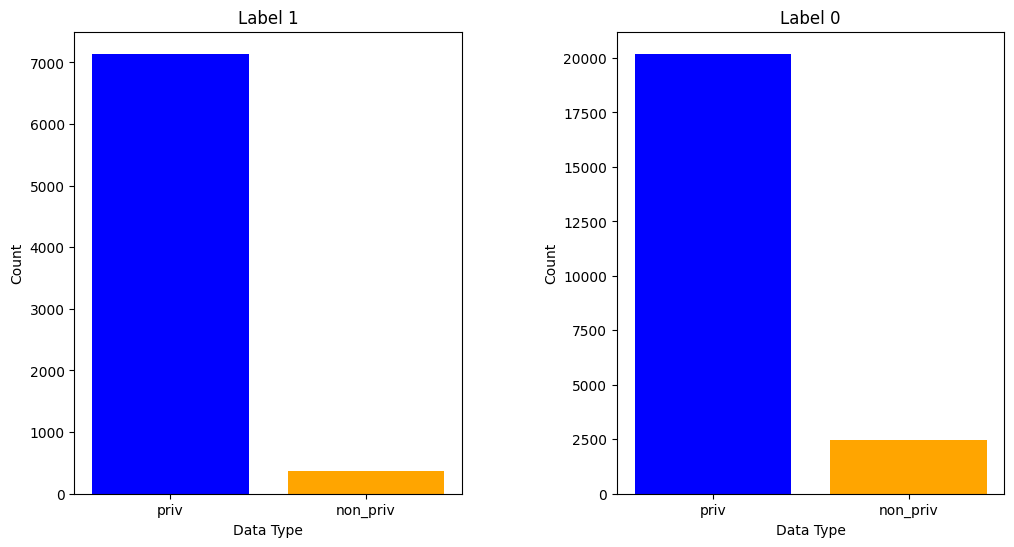

In [14]:
# Plot for orig_data_one_priv.shape[0] and orig_data_one_non_priv.shape[0]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Bar colors
colors = ['blue', 'orange']

# Plot 1 - orig_data_one_priv and orig_data_one_non_priv
axs[0].bar(['priv', 'non_priv'], [orig_data_one_priv.shape[0], orig_data_one_non_priv.shape[0]], color=colors)
axs[0].set_xlabel('Data Type')
axs[0].set_ylabel('Count')
axs[0].set_title('Label 1')

# Plot 2 - orig_data_zero_priv and orig_data_zero_non_priv
axs[1].bar(['priv', 'non_priv'], [orig_data_zero_priv.shape[0], orig_data_zero_non_priv.shape[0]], color=colors)
axs[1].set_xlabel('Data Type')
axs[1].set_ylabel('Count')
axs[1].set_title('Label 0')


# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)

plt.savefig('plot_original_ratios.jpg')


# Show the plots
plt.show()

In [15]:
orig_data

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,black
0,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,0,0,4356,18,United-States,0,1
1,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,0,0,3900,40,United-States,0,1
2,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,0,0,3900,40,United-States,0,1
3,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,0,0,3770,45,United-States,0,1
4,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,1,0,3770,40,United-States,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30157,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,1,0,0,40,United-States,0,1
30158,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,0,0,0,38,United-States,0,1
30159,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,1,0,0,40,United-States,1,1
30160,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,0,0,0,40,United-States,0,1


In [16]:
# dataset for training
orig_data.dropna(thresh=len(feature_columns)/2, inplace=True)
orig_data.reset_index(drop=True, inplace=True)

y_orig = orig_data[TARGET_COL]
# y_orig = orig_data[TARGET_COL].to_frame()

y_orig.dropna(inplace=True)

orig_data = orig_data.loc[:, feature_columns]
# data = data[feature_columns]
encoder = ce.TargetEncoder(cols=CATEGORICAL)

encoder.fit(orig_data, y_orig)
orig_data_encoded = encoder.transform(orig_data)

In [17]:
orig_dataset = pd.concat([orig_data, y_orig], axis=1)


## Acc, fairness metrics and roc & auc for original dataset

conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897
conf matrix:
  [[484   7]
 [ 39  31]] 
accuracy:  0.9180035650623886 precision:  0.8157894736842105 recall:  0.44285714285714284 fpr:  0.014256619144602852 tpr:  0.44285714285714284 fn+fp 46
conf matrix:
  [[3869  171]
 [ 680  752]] 
accuracy:  0.8444809941520468 precision:  0.8147345612134345 recall:  0.5251396648044693 fpr:  0.04232673267326733 tpr:  0.5251396648044693 fn+fp 851
conf matrix:
  [[4359  172]
 [ 769  733]] 
accuracy:  0.8440245317420852 precision:  0.8099447513812155 recall:  0.48801597869507324 fpr:  0.037960715073935114 tpr:  0.48801597869507324 fn+fp 941
conf matrix:
  [[3871  169]
 [ 721  708]] 
accuracy:  0.8372645821905285 precision:  0.8072976054732041 recall:  0.49545136459062283 fpr:  0.041831683168316834 tpr:  0.49545136459062283 fn+fp 890
conf matrix:
  [[488   3]
 [ 48

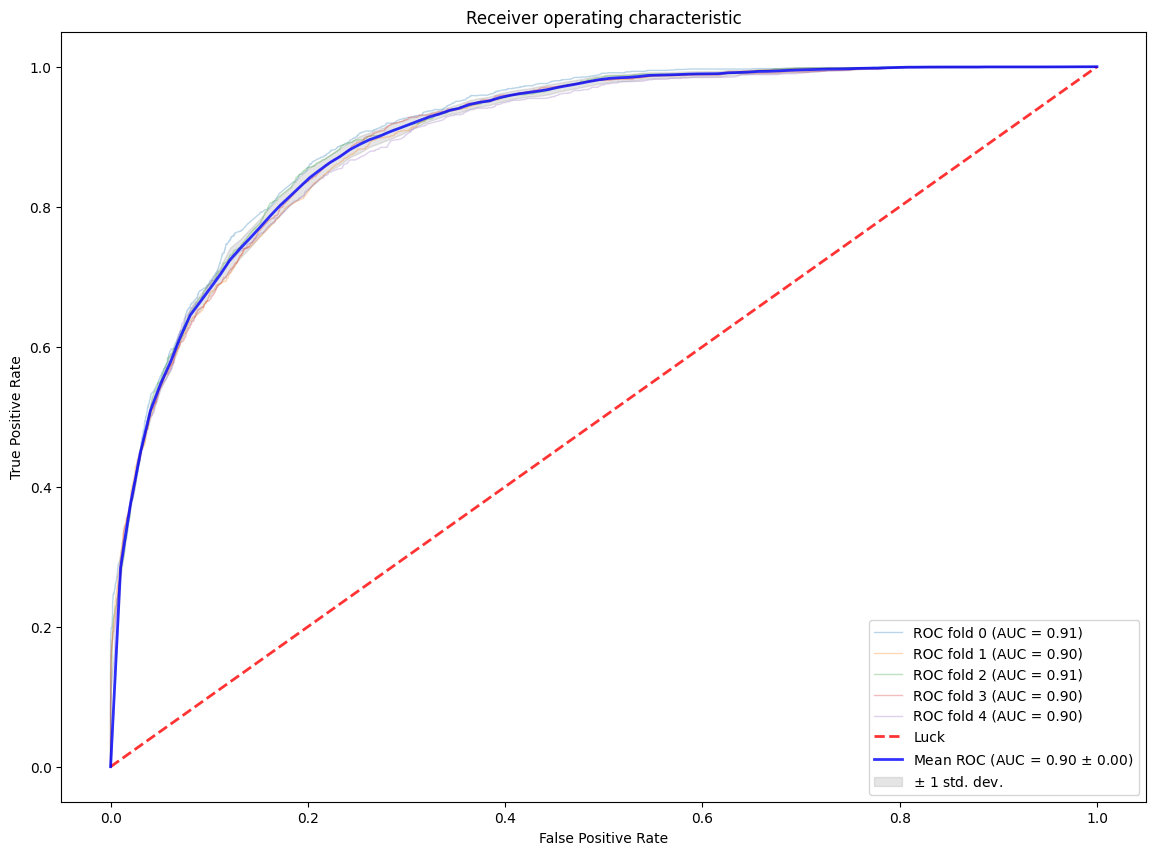

In [18]:
orig_acc ,orig_op_diff, orig_op_diff_fpr, orig_od_diff, orig_par_diff , orig_dis_impact  = fairness_metrics_roc_auc(orig_data_encoded, y_orig )

# CTGAN On Priv Target Group

In [19]:
orig_dataset[TARGET_COL] = orig_dataset[TARGET_COL].astype(int)

unprivileged_data_priv_target = orig_dataset[(orig_dataset[PRIV_FEATURE] != PRIV_VALUE_FEATURE ) & (orig_dataset[TARGET_COL] == PRIV_CLASS)]
privileged_data_priv_target = orig_dataset[(orig_dataset[PRIV_FEATURE] == PRIV_VALUE_FEATURE ) & (orig_dataset[TARGET_COL] == PRIV_CLASS)]
print(unprivileged_data_priv_target.shape[0])
print(privileged_data_priv_target.shape[0])

Accaracy list :  [0.8513177523620089, 0.8440245317420852, 0.8488063660477454, 0.8483090185676393, 0.8444960212201591]
equal opportunity for tpr :  [0.08228252194732644, 0.15298561116596532, 0.16527019478530375, 0.12519940179461614, 0.09096162736939434]
equal opportunity for fpr :  [0.028070113528664477, 0.03572170353491561, 0.03456036167425974, 0.04102773802221768, 0.023282221164308305]
odds difference list :  [0.05517631773799546, 0.09435365735044046, 0.09991527822978175, 0.08311356990841691, 0.05712192426685132]
The mean accuracy is  0.847 ± 0.003
The mean equal opportunity for tpr: (close to 0) 0.123 ± 0.033
The mean equal opportunity for fpr: (close to 0) 0.033 ± 0.006
The mean odds difference: (close to 0) 0.078 ± 0.019
The mean parity difference: (close to 0) 0.927 ± 0.007
The mean disperate impact: (close to 1) 1.000 ± 0.000
366
7142


In [20]:
unprivileged_data_priv_target

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,black,income
7,45,Private,172274,Doctorate,16,Divorced,Prof-specialty,Unmarried,Black,0,0,3004,35,United-States,0,1
28,60,Self-emp-not-inc,205246,HS-grad,9,Never-married,Exec-managerial,Not-in-family,Black,1,0,2559,50,United-States,0,1
211,65,Federal-gov,23494,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,Black,1,0,2174,40,United-States,0,1
339,32,Private,295589,Masters,14,Married-civ-spouse,Exec-managerial,Husband,Black,1,0,1977,40,United-States,0,1
358,57,Local-gov,174132,Masters,14,Married-civ-spouse,Prof-specialty,Wife,Black,0,0,1977,40,United-States,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29364,45,Private,151267,Bachelors,13,Never-married,Adm-clerical,Not-in-family,Black,0,0,0,40,United-States,0,1
29410,54,Private,229272,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,Black,1,0,0,40,United-States,0,1
29481,43,Private,169628,Bachelors,13,Never-married,Sales,Unmarried,Black,0,0,0,35,United-States,0,1
29504,38,Local-gov,161463,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,Black,1,0,0,40,United-States,0,1


In [21]:
from ctgan import CTGAN
if unprivileged_data_priv_target.shape[0] < privileged_data_priv_target.shape[0]:
    ctgan_priv_target = CTGAN(verbose=True)
    # Fit the synthesizer to the unprivileged features
    ctgan_priv_target.fit(unprivileged_data_priv_target , CATEGORICAL, epochs = 200)
else:
    ctgan_priv_target = CTGAN(verbose=True)
    # Fit the synthesizer to the unprivileged features
    ctgan_priv_target.fit(privileged_data_priv_target , CATEGORICAL, epochs = 200)


# from ctgan import CTGAN

# if unprivileged_data_priv_target.shape[0] < privileged_data_priv_target.shape[0]:
#     ctgan_priv_target = CTGAN(verbose=True)
#     # Fit the synthesizer to the unprivileged features
#     ctgan_priv_target.fit(unprivileged_data_priv_target , CATEGORICAL, epochs = 200)


Gen. (0.00) | Discrim. (0.04): 100%|██████████| 200/200 [00:36<00:00,  5.41it/s]


# CTGAN On Unpriv Target Group

In [22]:
unprivileged_data_unpriv_target = orig_dataset[(orig_dataset[PRIV_FEATURE] != PRIV_VALUE_FEATURE ) & (orig_dataset[TARGET_COL] != PRIV_CLASS)]
privileged_data_unpriv_target = orig_dataset[(orig_dataset[PRIV_FEATURE] == PRIV_VALUE_FEATURE ) & (orig_dataset[TARGET_COL] != PRIV_CLASS)]

print(unprivileged_data_unpriv_target.shape[0])
print(privileged_data_unpriv_target.shape[0])
print(privileged_data_unpriv_target.shape[0]-unprivileged_data_unpriv_target.shape[0])

2451
20203
17752


In [23]:
from ctgan import CTGAN
if unprivileged_data_unpriv_target.shape[0] <= privileged_data_unpriv_target.shape[0]:
    ctgan_unpriv_target = CTGAN(verbose=True)
    # Fit the synthesizer to the unprivileged features
    ctgan_unpriv_target.fit(unprivileged_data_unpriv_target , CATEGORICAL, epochs = 200)

if unprivileged_data_unpriv_target.shape[0] > privileged_data_unpriv_target.shape[0]:
    ctgan_unpriv_target = CTGAN(verbose=True)
    # Fit the synthesizer to the unprivileged features
    ctgan_unpriv_target.fit(privileged_data_unpriv_target , CATEGORICAL, epochs = 200)


Gen. (-1.55) | Discrim. (0.16): 100%|██████████| 200/200 [01:34<00:00,  2.12it/s]


In [24]:
orig_dataset = pd.concat([orig_data_encoded, y_orig], axis=1)
orig_dataset

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,black,income
0,82,0.218792,132870,0.164329,9,0.096735,0.485220,0.106523,0.263718,0,0,4356,18,0.254327,1,0
1,54,0.218792,140359,0.062837,4,0.107262,0.124619,0.066314,0.263718,0,0,3900,40,0.254327,1,0
2,41,0.218792,264663,0.200060,10,0.070288,0.448489,0.014330,0.263718,0,0,3900,40,0.254327,1,0
3,34,0.218792,216864,0.164329,9,0.107262,0.041096,0.066314,0.263718,0,0,3770,45,0.254327,1,0
4,38,0.218792,150601,0.071951,6,0.070288,0.133835,0.066314,0.263718,1,0,3770,40,0.254327,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30157,22,0.218792,310152,0.200060,10,0.048324,0.326087,0.106523,0.263718,1,0,0,40,0.254327,1,0
30158,27,0.218792,257302,0.253968,12,0.454959,0.304825,0.493599,0.263718,0,0,0,38,0.254327,1,0
30159,40,0.218792,154374,0.164329,9,0.454959,0.124619,0.455669,0.263718,1,0,0,40,0.254327,1,1
30160,58,0.218792,151910,0.164329,9,0.096735,0.133835,0.066314,0.263718,0,0,0,40,0.254327,1,0


In [25]:
print(DATASET_NAME)

ADULT_RACE


Optuna FairUS

In [26]:
def Upsampling_Dataset(lambda_0, lambda_1):
    priv_target_samples = ctgan_priv_target.sample(math.floor(lambda_0 * (abs(privileged_data_priv_target.shape[0] - unprivileged_data_priv_target.shape[0]))))
    #print(priv_target_samples)
    # print('number of samples i added(lambda_0)', len(priv_target_samples))
    y_priv = priv_target_samples[TARGET_COL]
    priv_target_samples = priv_target_samples.loc[:, feature_columns]

    priv_target_samples = encoder.transform(priv_target_samples)
    priv_target_samples = pd.concat([priv_target_samples, y_priv], axis=1)

    unpriv_target_samples = ctgan_unpriv_target.sample(math.floor(lambda_1 * (abs(privileged_data_unpriv_target.shape[0] - unprivileged_data_unpriv_target.shape[0]))))
    # print('number of samples i added(lambda_1)', len(unpriv_target_samples))
    y_unpriv = unpriv_target_samples[TARGET_COL]
    unpriv_target_samples = unpriv_target_samples.loc[:, feature_columns]

    unpriv_target_samples = encoder.transform(unpriv_target_samples)
    unpriv_target_samples = pd.concat([unpriv_target_samples, y_unpriv], axis=1)

    if len((priv_target_samples)>0) and (len(unpriv_target_samples)==0):
        df_list = [orig_dataset, priv_target_samples]  # List of your dataframes
        upsampled_df = pd.concat(df_list)
        y_upsampled = upsampled_df[TARGET_COL]
        upsampled_df_features = upsampled_df.loc[:, feature_columns]

    if (len(unpriv_target_samples)>0) and (len(priv_target_samples)==0):
        df_list = [orig_dataset, unpriv_target_samples]  # List of your dataframes
        upsampled_df = pd.concat(df_list)
        y_debias = upsampled_df[TARGET_COL]
        upsampled_df_features = upsampled_df.loc[:, feature_columns]

    if (len(priv_target_samples)>0) and (len(unpriv_target_samples)>0):
        df_list = [orig_dataset, priv_target_samples, unpriv_target_samples]  # List of your dataframes
        upsampled_df = pd.concat(df_list)
        y_upsampled = upsampled_df[TARGET_COL]
        upsampled_df_features = upsampled_df.loc[:, feature_columns]

    if (len(priv_target_samples)==0) and (len(unpriv_target_samples)==0):
        upsampled_df = orig_dataset
        y_upsampled = upsampled_df[TARGET_COL]
        upsampled_df_features = upsampled_df.loc[:, feature_columns]

    return upsampled_df


In [27]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.8 MB/s eta 0:00:00


In [28]:
!pip install cmaes


In [29]:
import optuna


In [30]:
all_upsampled_acc = []
all_upsampled_od_diff = []

def FairUS_Finding_Optimal_Lambdas_Optuna(trial):

    # Initialize original Equalized odds and Accuracy Scores
    orig_acc ,orig_op_diff, orig_op_diff_fpr, orig_od_diff, orig_par_diff , orig_dis_impact = fairness_metrics_roc_auc_no_print(orig_data_encoded, y_orig)

    OrigFair_score = mean(orig_od_diff)
    OrigAcc_score = mean(orig_acc)

    # Initialize matrices to store Fairness and Accuracy results
    #Fairness_Matrix = np.zeros((num_steps, num_steps))
    #Accuracy_Matrix = np.zeros((num_steps, num_steps))

    lambda_0 =  trial.suggest_float("lambda_0", 0, 2)
    lambda_1 =  trial.suggest_float("lambda_1", 0, 2)

    upsampled_df = Upsampling_Dataset(lambda_0, lambda_1)
    y_debias = upsampled_df[TARGET_COL]
    upsampled_df_features = upsampled_df.loc[:, feature_columns]

    upsampled_acc ,upsampled_op_diff, upsampled_op_diff_fpr, upsampled_od_diff, upsampled_par_diff , upsampled_dis_impact = fairness_metrics_roc_auc_no_print(upsampled_df_features, y_debias)

    CurrFair_score = mean(upsampled_od_diff)
    CurrAcc_score = mean(upsampled_acc)
    # if ALPHA == 1:
    #   optimization_objective = CurrFair_score/mean(orig_od_diff)
    # else:
      # optimization_objective = (ALPHA*CurrFair_score/mean(orig_od_diff)) - ((1-ALPHA)*CurrAcc_score/mean(orig_acc))
    optimization_objective = (CurrFair_score/mean(orig_od_diff)) - (CurrAcc_score/mean(orig_acc))
    # optimization_objective = (CurrFair_score) - (CurrAcc_score)

    # Update fairness matrix with Equalized odds subtraction
    #Fairness_Matrix[i, j] = -(CurrFair_score - OrigFair_score)
    # Update accuracy matrix with Minos accuracy subtraction
    #Accuracy_Matrix[i, j] = (CurrAcc_score - OrigAcc_score)


    #fairness_delta = np.max(Fairness_Matrix)-np.min(Fairness_Matrix)
    #acc_delta = np.max(Accuracy_Matrix)-np.min(Accuracy_Matrix)
    #fairness_factor = acc_delta / fairness_delta
    #scaled_fairness_matrix = fairness_factor * Fairness_Matrix


    #Accuracy_Matrix = -(Accuracy_Matrix)
    #scaled_fairness_matrix= -(scaled_fairness_matrix)
    print ('lambda_0:',lambda_0)
    print ('lambda_1:',lambda_1)
    #print ('fairness matrix before scaling: ',Fairness_Matrix)
    #print ('fairness matrix after scaling: ',scaled_fairness_matrix)
    #print ('acc matrix is: ', Accuracy_Matrix)

    # Save upsampled_acc and upsampled_op_diff as trial attributes
    upsampled_acc = mean(upsampled_acc)
    upsampled_od_diff = mean(upsampled_od_diff)
    trial.set_user_attr('upsampled_acc', upsampled_acc)
    trial.set_user_attr('upsampled_op_diff', upsampled_od_diff)
    print('---------------------------------------trail upsampled_acc is : ', trial.user_attrs.get('upsampled_acc'))
    print('---------------------------------------trail upsampled_op_diff is : ', trial.user_attrs.get('upsampled_op_diff'))
    all_upsampled_acc.append(upsampled_acc)
    all_upsampled_od_diff.append(upsampled_od_diff)

    # Return optimal dataset upsampled with lambda_0, lambda_1 values
    # return optimization_objective #scaled_fairness_matrix
    return CurrFair_score, CurrAcc_score #for multi objective


In [31]:
# Record the start time
start_time = time.time()

In [32]:
CME_flag = False

if CME_flag:
  from optuna.samplers import CmaEsSampler

  # Create an instance of CmaEsSampler
  # Create an instance of CmaEsSampler with specified parameters
  cma_es_sampler = CmaEsSampler(
      sigma0=0.01,  # Initial standard deviation of the distribution.
      n_startup_trials=10,  # The number of trials before using CMA-ES.
      independent_sampler=optuna.samplers.RandomSampler(seed=0)  # Sampler used for the first `n_startup_trials`.
  )


  # Pass the instance of CmaEsSampler to create_study
  # study = optuna.create_study(sampler=cma_es_sampler, direction='minimize')
  study = optuna.create_study(sampler=tpe_sampler, directions=['minimize', 'maximize']) #

  study.optimize(FairUS_Finding_Optimal_Lambdas_Optuna, n_trials=400)
else:
  from optuna.samplers import TPESampler

  # Create an instance of TPESampler with custom parameters
  # You can adjust parameters like n_startup_trials, n_ei_candidates, etc.
  tpe_sampler = TPESampler(n_startup_trials=20, n_ei_candidates=24, multivariate=True)

  # Pass the instance of TPESampler to create_study
  # study = optuna.create_study(sampler=tpe_sampler, direction='minimize') #directions=['minimize', 'maximize']
  study = optuna.create_study(sampler=tpe_sampler, directions=['minimize', 'maximize']) #

  study.optimize(FairUS_Finding_Optimal_Lambdas_Optuna, n_trials=200)

/usr/local/lib/python3.10/dist-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2024-04-01 18:25:02,751] A new study created in memory with name: no-name-8c15c069-a924-4087-af82-9f9a078d3322


conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897
conf matrix:
  [[484   7]
 [ 39  31]] 
accuracy:  0.9180035650623886 precision:  0.8157894736842105 recall:  0.44285714285714284 fpr:  0.014256619144602852 tpr:  0.44285714285714284 fn+fp 46
conf matrix:
  [[3869  171]
 [ 680  752]] 
accuracy:  0.8444809941520468 precision:  0.8147345612134345 recall:  0.5251396648044693 fpr:  0.04232673267326733 tpr:  0.5251396648044693 fn+fp 851
conf matrix:
  [[4359  172]
 [ 769  733]] 
accuracy:  0.8440245317420852 precision:  0.8099447513812155 recall:  0.48801597869507324 fpr:  0.037960715073935114 tpr:  0.48801597869507324 fn+fp 941
conf matrix:
  [[3871  169]
 [ 721  708]] 
accuracy:  0.8372645821905285 precision:  0.8072976054732041 recall:  0.49545136459062283 fpr:  0.041831683168316834 tpr:  0.49545136459062283 fn+fp 890
conf matrix:
  [[488   3]
 [ 48

[I 2024-04-01 18:25:07,545] Trial 0 finished with values: [0.26365791787119625, 0.9054924336377231] and parameters: {'lambda_0': 1.7325015453660577, 'lambda_1': 0.9585241920191012}. 


conf matrix:
  [[7713  220]
 [ 884 2966]] 
accuracy:  0.9063056946448272 precision:  0.9309478970495919 recall:  0.7703896103896104 fpr:  0.027732257657884785 tpr:  0.7703896103896104 fn+fp 1104
conf matrix:
  [[3856  183]
 [ 793  633]] 
accuracy:  0.8214089661482159 precision:  0.7757352941176471 recall:  0.4438990182328191 fpr:  0.04530824461500371 tpr:  0.4438990182328191 fn+fp 976
conf matrix:
  [[3857   37]
 [  91 2333]] 
accuracy:  0.9797404241848686 precision:  0.9843881856540084 recall:  0.9624587458745875 fpr:  0.009501797637390858 tpr:  0.9624587458745875 fn+fp 128
lambda_0: 1.7325015453660577
lambda_1: 0.9585241920191012
---------------------------------------trail upsampled_acc is :  0.9054924336377231
---------------------------------------trail upsampled_op_diff is :  0.26365791787119625
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+f

[I 2024-04-01 18:25:17,060] Trial 1 finished with values: [0.23275470481173838, 0.9109018879537979] and parameters: {'lambda_0': 0.7688032196340961, 'lambda_1': 1.4829549820131762}. 


conf matrix:
  [[9568  227]
 [ 822 1722]] 
accuracy:  0.9149850068887267 precision:  0.883530015392509 recall:  0.6768867924528302 fpr:  0.023175089331291476 tpr:  0.6768867924528302 fn+fp 1049
conf matrix:
  [[3875  208]
 [ 710  655]] 
accuracy:  0.8314977973568282 precision:  0.7589803012746235 recall:  0.47985347985347987 fpr:  0.05094293411707078 tpr:  0.47985347985347987 fn+fp 918
conf matrix:
  [[5693   19]
 [ 112 1067]] 
accuracy:  0.9809896967058482 precision:  0.9825046040515654 recall:  0.9050042408821035 fpr:  0.003326330532212885 tpr:  0.9050042408821035 fn+fp 131
lambda_0: 0.7688032196340961
lambda_1: 1.4829549820131762
---------------------------------------trail upsampled_acc is :  0.9109018879537979
---------------------------------------trail upsampled_op_diff is :  0.23275470481173838
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+

[I 2024-04-01 18:25:27,647] Trial 2 finished with values: [0.27818811200155924, 0.9169522514715569] and parameters: {'lambda_0': 1.3067538193047492, 'lambda_1': 1.779117229753481}. 


conf matrix:
  [[10543   304]
 [  904  2368]] 
accuracy:  0.9144415326864509 precision:  0.8862275449101796 recall:  0.7237163814180929 fpr:  0.028026182354568083 tpr:  0.7237163814180929 fn+fp 1208
conf matrix:
  [[3830  260]
 [ 794  643]] 
accuracy:  0.8092998009770219 precision:  0.7120708748615725 recall:  0.4474599860821155 fpr:  0.06356968215158924 tpr:  0.4474599860821155 fn+fp 1054
conf matrix:
  [[6713   44]
 [ 110 1725]] 
accuracy:  0.9820763500931099 precision:  0.9751271905031091 recall:  0.9400544959128065 fpr:  0.006511765576439248 tpr:  0.9400544959128065 fn+fp 154
lambda_0: 1.3067538193047492
lambda_1: 1.779117229753481
---------------------------------------trail upsampled_acc is :  0.9169522514715569
---------------------------------------trail upsampled_op_diff is :  0.27818811200155924
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 

[I 2024-04-01 18:25:37,489] Trial 3 finished with values: [0.22311670052615662, 0.8672506595392573] and parameters: {'lambda_0': 0.6138118602929037, 'lambda_1': 0.20749417542988313}. 


conf matrix:
  [[5005  262]
 [ 792 1541]] 
accuracy:  0.8613157894736843 precision:  0.8546866333887965 recall:  0.6605229318474067 fpr:  0.04974368710841086 tpr:  0.6605229318474067 fn+fp 1054
conf matrix:
  [[3789  243]
 [ 714  712]] 
accuracy:  0.8246610480029315 precision:  0.7455497382198953 recall:  0.4992987377279102 fpr:  0.060267857142857144 tpr:  0.4992987377279102 fn+fp 957
conf matrix:
  [[1216   19]
 [  78  829]] 
accuracy:  0.9547152194211018 precision:  0.9775943396226415 recall:  0.9140022050716649 fpr:  0.015384615384615385 tpr:  0.9140022050716649 fn+fp 97
lambda_0: 0.6138118602929037
lambda_1: 0.20749417542988313
---------------------------------------trail upsampled_acc is :  0.8672506595392573
---------------------------------------trail upsampled_op_diff is :  0.22311670052615662
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+f

[I 2024-04-01 18:25:46,370] Trial 4 finished with values: [0.17362887999477278, 0.8682906454720345] and parameters: {'lambda_0': 0.27422642621134496, 'lambda_1': 0.3445933605544833}. 


conf matrix:
  [[5532  222]
 [ 773 1100]] 
accuracy:  0.8695424151042349 precision:  0.8320726172465961 recall:  0.587293112653497 fpr:  0.03858185610010428 tpr:  0.587293112653497 fn+fp 995
conf matrix:
  [[3826  212]
 [ 692  742]] 
accuracy:  0.8347953216374269 precision:  0.7777777777777778 recall:  0.5174337517433751 fpr:  0.05250123823675087 tpr:  0.5174337517433751 fn+fp 904
conf matrix:
  [[1706   10]
 [  81  358]] 
accuracy:  0.9577726218097448 precision:  0.9728260869565217 recall:  0.8154897494305239 fpr:  0.005827505827505828 tpr:  0.8154897494305239 fn+fp 91
lambda_0: 0.27422642621134496
lambda_1: 0.3445933605544833
---------------------------------------trail upsampled_acc is :  0.8682906454720345
---------------------------------------trail upsampled_op_diff is :  0.17362887999477278
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 89

[I 2024-04-01 18:25:50,834] Trial 5 finished with values: [0.22037150591580842, 0.870086325534843] and parameters: {'lambda_0': 0.5846524214504267, 'lambda_1': 0.3290989930926105}. 


conf matrix:
  [[5422  277]
 [ 768 1526]] 
accuracy:  0.8692606030276492 precision:  0.8463671658347199 recall:  0.6652136006974717 fpr:  0.04860501842428496 tpr:  0.6652136006974717 fn+fp 1045
conf matrix:
  [[3768  261]
 [ 701  782]] 
accuracy:  0.8254716981132075 precision:  0.7497603068072867 recall:  0.5273095077545515 fpr:  0.06478034251675353 tpr:  0.5273095077545515 fn+fp 962
conf matrix:
  [[1654   16]
 [  67  744]] 
accuracy:  0.9665457476823861 precision:  0.9789473684210527 recall:  0.9173859432799013 fpr:  0.009580838323353293 tpr:  0.9173859432799013 fn+fp 83
lambda_0: 0.5846524214504267
lambda_1: 0.3290989930926105
---------------------------------------trail upsampled_acc is :  0.870086325534843
---------------------------------------trail upsampled_op_diff is :  0.22037150591580842
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 8

[I 2024-04-01 18:25:55,538] Trial 6 finished with values: [0.27781576807134534, 0.9043464131935982] and parameters: {'lambda_0': 1.1863737540352972, 'lambda_1': 1.31509680424257}. 


conf matrix:
  [[8969  230]
 [ 934 2176]] 
accuracy:  0.9054350475262003 precision:  0.9044056525353283 recall:  0.6996784565916399 fpr:  0.025002717686705075 tpr:  0.6996784565916399 fn+fp 1164
conf matrix:
  [[3877  200]
 [ 795  635]] 
accuracy:  0.819320864354458 precision:  0.7604790419161677 recall:  0.44405594405594406 fpr:  0.04905567819475104 tpr:  0.44405594405594406 fn+fp 995
conf matrix:
  [[5092   30]
 [ 139 1541]] 
accuracy:  0.9751543663628345 precision:  0.9809038828771484 recall:  0.9172619047619047 fpr:  0.005857087075361187 tpr:  0.9172619047619047 fn+fp 169
lambda_0: 1.1863737540352972
lambda_1: 1.31509680424257
---------------------------------------trail upsampled_acc is :  0.9043464131935982
---------------------------------------trail upsampled_op_diff is :  0.27781576807134534
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp

[I 2024-04-01 18:25:59,728] Trial 7 finished with values: [0.23801361105707863, 0.9163782045262191] and parameters: {'lambda_0': 0.8571154696727414, 'lambda_1': 1.7644599804079921}. 


conf matrix:
  [[10544   251]
 [  856  1807]] 
accuracy:  0.917744092732947 precision:  0.8780369290573372 recall:  0.6785580172737514 fpr:  0.023251505326540065 tpr:  0.6785580172737514 fn+fp 1107
conf matrix:
  [[3951  238]
 [ 721  682]] 
accuracy:  0.8285050071530758 precision:  0.741304347826087 recall:  0.48610121168923737 fpr:  0.05681546908570064 tpr:  0.48610121168923737 fn+fp 959
conf matrix:
  [[6593   13]
 [ 135 1125]] 
accuracy:  0.9811848461734045 precision:  0.9885764499121266 recall:  0.8928571428571429 fpr:  0.0019679079624583713 tpr:  0.8928571428571429 fn+fp 148
lambda_0: 0.8571154696727414
lambda_1: 1.7644599804079921
---------------------------------------trail upsampled_acc is :  0.9163782045262191
---------------------------------------trail upsampled_op_diff is :  0.23801361105707863
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143

[I 2024-04-01 18:26:02,676] Trial 8 finished with values: [0.25189239088594806, 0.8793580817276799] and parameters: {'lambda_0': 1.250922742434135, 'lambda_1': 0.3052281002254247}. 


conf matrix:
  [[5335  279]
 [ 837 2360]] 
accuracy:  0.8733401430030644 precision:  0.894278135657446 recall:  0.7381920550516109 fpr:  0.049697185607410044 tpr:  0.7381920550516109 fn+fp 1116
conf matrix:
  [[3791  241]
 [ 757  715]] 
accuracy:  0.8186773255813954 precision:  0.747907949790795 recall:  0.4857336956521739 fpr:  0.0597718253968254 tpr:  0.4857336956521739 fn+fp 998
conf matrix:
  [[1544   38]
 [  80 1645]] 
accuracy:  0.9643181130934382 precision:  0.9774212715389186 recall:  0.9536231884057971 fpr:  0.02402022756005057 tpr:  0.9536231884057971 fn+fp 118
lambda_0: 1.250922742434135
lambda_1: 0.3052281002254247
---------------------------------------trail upsampled_acc is :  0.8793580817276799
---------------------------------------trail upsampled_op_diff is :  0.25189239088594806
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897

[I 2024-04-01 18:26:05,766] Trial 9 finished with values: [0.2798705506075946, 0.8776701251080149] and parameters: {'lambda_0': 1.6300810953255407, 'lambda_1': 0.05718403146484152}. 


conf matrix:
  [[4478  255]
 [ 813 2898]] 
accuracy:  0.8735196589294173 precision:  0.9191246431969553 recall:  0.7809215844785772 fpr:  0.05387703359391507 tpr:  0.7809215844785772 fn+fp 1068
conf matrix:
  [[3848  215]
 [ 776  634]] 
accuracy:  0.8189292892380778 precision:  0.7467608951707891 recall:  0.44964539007092197 fpr:  0.052916564115185825 tpr:  0.44964539007092197 fn+fp 991
conf matrix:
  [[ 630   40]
 [  37 2264]] 
accuracy:  0.9740828004039044 precision:  0.9826388888888888 recall:  0.9839200347674923 fpr:  0.05970149253731343 tpr:  0.9839200347674923 fn+fp 77
lambda_0: 1.6300810953255407
lambda_1: 0.05718403146484152
---------------------------------------trail upsampled_acc is :  0.8776701251080149
---------------------------------------trail upsampled_op_diff is :  0.2798705506075946
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+f

[I 2024-04-01 18:26:10,846] Trial 10 finished with values: [0.2797765925105732, 0.9210996646027722] and parameters: {'lambda_0': 1.9341186824956034, 'lambda_1': 1.7815287636181443}. 


conf matrix:
  [[10614   241]
 [  920  3203]] 
accuracy:  0.9224863132594472 precision:  0.9300232288037166 recall:  0.7768615086102353 fpr:  0.02220175034546292 tpr:  0.7768615086102353 fn+fp 1161
conf matrix:
  [[3916  202]
 [ 794  660]] 
accuracy:  0.8212491026561378 precision:  0.765661252900232 recall:  0.45392022008253097 fpr:  0.04905293831957261 tpr:  0.45392022008253097 fn+fp 996
conf matrix:
  [[6698   39]
 [ 126 2543]] 
accuracy:  0.9824580055283861 precision:  0.9848954298993029 recall:  0.9527913076058449 fpr:  0.005788926822027609 tpr:  0.9527913076058449 fn+fp 165
lambda_0: 1.9341186824956034
lambda_1: 1.7815287636181443
---------------------------------------trail upsampled_acc is :  0.9210996646027722
---------------------------------------trail upsampled_op_diff is :  0.2797765925105732
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 f

[I 2024-04-01 18:26:13,477] Trial 11 finished with values: [0.25183730087089884, 0.8636826366594824] and parameters: {'lambda_0': 1.0487137782365967, 'lambda_1': 0.11931172084433261}. 


conf matrix:
  [[4716  238]
 [ 775 2148]] 
accuracy:  0.8713977402564428 precision:  0.9002514668901928 recall:  0.7348614437222032 fpr:  0.04804198627371821 tpr:  0.7348614437222032 fn+fp 1013
conf matrix:
  [[3876  208]
 [ 721  700]] 
accuracy:  0.8312443233424159 precision:  0.7709251101321586 recall:  0.49261083743842365 fpr:  0.050930460333006855 tpr:  0.49261083743842365 fn+fp 929
conf matrix:
  [[ 840   30]
 [  54 1448]] 
accuracy:  0.9645868465430016 precision:  0.979702300405954 recall:  0.9640479360852197 fpr:  0.034482758620689655 tpr:  0.9640479360852197 fn+fp 84
lambda_0: 1.0487137782365967
lambda_1: 0.11931172084433261
---------------------------------------trail upsampled_acc is :  0.8636826366594824
---------------------------------------trail upsampled_op_diff is :  0.25183730087089884
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+

[I 2024-04-01 18:26:16,675] Trial 12 finished with values: [0.06295573987304753, 0.8966093950522517] and parameters: {'lambda_0': 0.10205171631868493, 'lambda_1': 0.9884379170694211}. 


conf matrix:
  [[7793  247]
 [ 772  867]] 
accuracy:  0.8947205289802665 precision:  0.7782764811490126 recall:  0.5289810860280659 fpr:  0.03072139303482587 tpr:  0.5289810860280659 fn+fp 1019
conf matrix:
  [[3820  241]
 [ 667  737]] 
accuracy:  0.8338517840805123 precision:  0.7535787321063395 recall:  0.5249287749287749 fpr:  0.05934498891898547 tpr:  0.5249287749287749 fn+fp 908
conf matrix:
  [[3973    6]
 [ 105  130]] 
accuracy:  0.9736592311343142 precision:  0.9558823529411765 recall:  0.5531914893617021 fpr:  0.0015079165619502387 tpr:  0.5531914893617021 fn+fp 111
lambda_0: 0.10205171631868493
lambda_1: 0.9884379170694211
---------------------------------------trail upsampled_acc is :  0.8966093950522517
---------------------------------------trail upsampled_op_diff is :  0.06295573987304753
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+

[I 2024-04-01 18:26:21,371] Trial 13 finished with values: [0.2237458305540363, 0.9107283462653762] and parameters: {'lambda_0': 0.7785194744841044, 'lambda_1': 1.4440843680295496}. 


conf matrix:
  [[9449  208]
 [ 854 1703]] 
accuracy:  0.9130505976747995 precision:  0.891156462585034 recall:  0.6660148611654282 fpr:  0.021538780159469816 tpr:  0.6660148611654282 fn+fp 1062
conf matrix:
  [[3882  201]
 [ 713  683]] 
accuracy:  0.8331812374520898 precision:  0.7726244343891403 recall:  0.4892550143266476 fpr:  0.04922850844966936 tpr:  0.4892550143266476 fn+fp 914
conf matrix:
  [[5567    7]
 [ 141 1020]] 
accuracy:  0.9780252412769117 precision:  0.9931840311587147 recall:  0.8785529715762274 fpr:  0.0012558306422676714 tpr:  0.8785529715762274 fn+fp 148
lambda_0: 0.7785194744841044
lambda_1: 1.4440843680295496
---------------------------------------trail upsampled_acc is :  0.9107283462653762
---------------------------------------trail upsampled_op_diff is :  0.2237458305540363
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp

[I 2024-04-01 18:26:25,457] Trial 14 finished with values: [0.2866435787653331, 0.9119385346169279] and parameters: {'lambda_0': 1.5267150565326102, 'lambda_1': 1.435424171645299}. 


conf matrix:
  [[9376  251]
 [ 851 2719]] 
accuracy:  0.9164961733727363 precision:  0.9154882154882155 recall:  0.7616246498599439 fpr:  0.026072504414667082 tpr:  0.7616246498599439 fn+fp 1102
conf matrix:
  [[3894  225]
 [ 734  676]] 
accuracy:  0.8265509133658889 precision:  0.7502774694783574 recall:  0.4794326241134752 fpr:  0.05462490895848507 tpr:  0.4794326241134752 fn+fp 959
conf matrix:
  [[5482   26]
 [ 117 2043]] 
accuracy:  0.9813510693792384 precision:  0.9874335427742871 recall:  0.9458333333333333 fpr:  0.004720406681190995 tpr:  0.9458333333333333 fn+fp 143
lambda_0: 1.5267150565326102
lambda_1: 1.435424171645299
---------------------------------------trail upsampled_acc is :  0.9119385346169279
---------------------------------------trail upsampled_op_diff is :  0.2866435787653331
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 

[I 2024-04-01 18:26:29,730] Trial 15 finished with values: [0.26817768485776206, 0.9155598663277339] and parameters: {'lambda_0': 0.9883990321183482, 'lambda_1': 1.8723798321774696}. 


conf matrix:
  [[10897   281]
 [  890  1951]] 
accuracy:  0.9164705043155718 precision:  0.8741039426523297 recall:  0.6867300246392115 fpr:  0.025138665235283592 tpr:  0.6867300246392115 fn+fp 1171
conf matrix:
  [[3842  268]
 [ 739  704]] 
accuracy:  0.8186565820277327 precision:  0.7242798353909465 recall:  0.4878724878724879 fpr:  0.06520681265206812 tpr:  0.4878724878724879 fn+fp 1007
conf matrix:
  [[7055   13]
 [ 151 1247]] 
accuracy:  0.9806283959366879 precision:  0.9896825396825397 recall:  0.8919885550786838 fpr:  0.0018392756083757782 tpr:  0.8919885550786838 fn+fp 164
lambda_0: 0.9883990321183482
lambda_1: 1.8723798321774696
---------------------------------------trail upsampled_acc is :  0.9155598663277339
---------------------------------------trail upsampled_op_diff is :  0.26817768485776206
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.521304926764314

[I 2024-04-01 18:26:33,629] Trial 16 finished with values: [0.15192274681279247, 0.8902728975018731] and parameters: {'lambda_0': 0.26701781188540163, 'lambda_1': 0.8445168578015438}. 


conf matrix:
  [[7280  249]
 [ 811 1052]] 
accuracy:  0.887137989778535 precision:  0.808608762490392 recall:  0.5646806226516371 fpr:  0.03307212113162439 tpr:  0.5646806226516371 fn+fp 1060
conf matrix:
  [[3769  237]
 [ 705  758]] 
accuracy:  0.827756445419638 precision:  0.7618090452261307 recall:  0.5181134654818865 fpr:  0.05916125811283075 tpr:  0.5181134654818865 fn+fp 942
conf matrix:
  [[3511   12]
 [ 106  294]] 
accuracy:  0.9699209788427224 precision:  0.9607843137254902 recall:  0.735 fpr:  0.0034061879080329264 tpr:  0.735 fn+fp 118
lambda_0: 0.26701781188540163
lambda_1: 0.8445168578015438
---------------------------------------trail upsampled_acc is :  0.8902728975018731
---------------------------------------trail upsampled_op_diff is :  0.15192274681279247
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897
conf matrix:
  [[484  

[I 2024-04-01 18:26:37,402] Trial 17 finished with values: [0.25964596357919467, 0.9035488797423036] and parameters: {'lambda_0': 1.2125684568607762, 'lambda_1': 1.201661311033849}. 


conf matrix:
  [[8544  253]
 [ 898 2246]] 
accuracy:  0.9036094129469894 precision:  0.8987595038015206 recall:  0.7143765903307888 fpr:  0.02875980447879959 tpr:  0.7143765903307888 fn+fp 1151
conf matrix:
  [[3829  220]
 [ 778  601]] 
accuracy:  0.816138540899042 precision:  0.7320341047503045 recall:  0.43582306018854244 fpr:  0.05433440355643369 tpr:  0.43582306018854244 fn+fp 998
conf matrix:
  [[4715   33]
 [ 120 1645]] 
accuracy:  0.976508521418701 precision:  0.9803337306317044 recall:  0.9320113314447592 fpr:  0.0069502948609941025 tpr:  0.9320113314447592 fn+fp 153
lambda_0: 1.2125684568607762
lambda_1: 1.201661311033849
---------------------------------------trail upsampled_acc is :  0.9035488797423036
---------------------------------------trail upsampled_op_diff is :  0.25964596357919467
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp

[I 2024-04-01 18:26:41,456] Trial 18 finished with values: [0.2743914807926945, 0.9106397329501749] and parameters: {'lambda_0': 1.9677214240042644, 'lambda_1': 1.2464906310623691}. 


conf matrix:
  [[8703  253]
 [ 944 3224]] 
accuracy:  0.9087930508991161 precision:  0.9272361230946218 recall:  0.7735124760076776 fpr:  0.028249218401071908 tpr:  0.7735124760076776 fn+fp 1197
conf matrix:
  [[3837  168]
 [ 809  574]] 
accuracy:  0.8186711210096511 precision:  0.7735849056603774 recall:  0.4150397686189443 fpr:  0.041947565543071164 tpr:  0.4150397686189443 fn+fp 977
conf matrix:
  [[4866   85]
 [ 135 2650]] 
accuracy:  0.9715615305067218 precision:  0.9689213893967094 recall:  0.9515260323159784 fpr:  0.01716824883861846 tpr:  0.9515260323159784 fn+fp 220
lambda_0: 1.9677214240042644
lambda_1: 1.2464906310623691
---------------------------------------trail upsampled_acc is :  0.9106397329501749
---------------------------------------trail upsampled_op_diff is :  0.2743914807926945
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp

[I 2024-04-01 18:26:46,517] Trial 19 finished with values: [0.28271483495330935, 0.9137740330166978] and parameters: {'lambda_0': 1.9958125468669856, 'lambda_1': 1.3708157864704669}. 


conf matrix:
  [[9119  278]
 [ 950 3256]] 
accuracy:  0.9097257957803425 precision:  0.9213355970571591 recall:  0.7741321921065145 fpr:  0.029583909758433544 tpr:  0.7741321921065145 fn+fp 1228
conf matrix:
  [[3895  206]
 [ 824  583]] 
accuracy:  0.8129992737835875 precision:  0.7389100126742713 recall:  0.4143567874911159 fpr:  0.05023165081687393 tpr:  0.4143567874911159 fn+fp 1030
conf matrix:
  [[5224   72]
 [ 126 2673]] 
accuracy:  0.9755404570722669 precision:  0.9737704918032787 recall:  0.954983922829582 fpr:  0.013595166163141994 tpr:  0.954983922829582 fn+fp 198
lambda_0: 1.9958125468669856
lambda_1: 1.3708157864704669
---------------------------------------trail upsampled_acc is :  0.9137740330166978
---------------------------------------trail upsampled_op_diff is :  0.28271483495330935
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp

[I 2024-04-01 18:26:50,260] Trial 20 finished with values: [0.09732420935204333, 0.9109635993009836] and parameters: {'lambda_0': 0.1831305798846241, 'lambda_1': 1.5318028786497686}. 


conf matrix:
  [[9728  241]
 [ 789  960]] 
accuracy:  0.9121010411332992 precision:  0.7993338884263114 recall:  0.548885077186964 fpr:  0.024174942321195707 tpr:  0.548885077186964 fn+fp 1030
conf matrix:
  [[3815  232]
 [ 692  743]] 
accuracy:  0.8314483765049252 precision:  0.762051282051282 recall:  0.5177700348432056 fpr:  0.0573264146281196 tpr:  0.5177700348432056 fn+fp 924
conf matrix:
  [[5913    9]
 [  97  217]] 
accuracy:  0.9830019243104554 precision:  0.9601769911504425 recall:  0.6910828025477707 fpr:  0.001519756838905775 tpr:  0.6910828025477707 fn+fp 106
lambda_0: 0.1831305798846241
lambda_1: 1.5318028786497686
---------------------------------------trail upsampled_acc is :  0.9109635993009836
---------------------------------------trail upsampled_op_diff is :  0.09732420935204333
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 89

[I 2024-04-01 18:26:53,881] Trial 21 finished with values: [0.1322226781452984, 0.9121937477178611] and parameters: {'lambda_0': 0.05003393656422003, 'lambda_1': 1.483818409000662}. 


conf matrix:
  [[9607  191]
 [ 776  794]] 
accuracy:  0.9149366643209008 precision:  0.8060913705583757 recall:  0.5057324840764331 fpr:  0.019493774239640743 tpr:  0.5057324840764331 fn+fp 967
conf matrix:
  [[3901  188]
 [ 683  767]] 
accuracy:  0.8427513991695252 precision:  0.8031413612565445 recall:  0.5289655172413793 fpr:  0.04597701149425287 tpr:  0.5289655172413793 fn+fp 871
conf matrix:
  [[5706    3]
 [  93   27]] 
accuracy:  0.9835306227483274 precision:  0.9 recall:  0.225 fpr:  0.0005254860746190226 tpr:  0.225 fn+fp 96
lambda_0: 0.05003393656422003
lambda_1: 1.483818409000662
---------------------------------------trail upsampled_acc is :  0.9121937477178611
---------------------------------------trail upsampled_op_diff is :  0.1322226781452984
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897
conf matrix:
  [[484   7]
 [ 39  31]]

[I 2024-04-01 18:26:58,815] Trial 22 finished with values: [0.1485712539048981, 0.9204798060171847] and parameters: {'lambda_0': 0.30967680705036627, 'lambda_1': 1.906805166878757}. 


conf matrix:
  [[11123   177]
 [  881  1040]] 
accuracy:  0.9199757960819908 precision:  0.8545603944124898 recall:  0.5413846954711088 fpr:  0.015663716814159293 tpr:  0.5413846954711088 fn+fp 1058
conf matrix:
  [[3945  168]
 [ 755  680]] 
accuracy:  0.833633741888969 precision:  0.8018867924528302 recall:  0.4738675958188153 fpr:  0.040846097738876735 tpr:  0.4738675958188153 fn+fp 923
conf matrix:
  [[7178    9]
 [ 126  360]] 
accuracy:  0.9824058386550241 precision:  0.975609756097561 recall:  0.7407407407407407 fpr:  0.001252261026854042 tpr:  0.7407407407407407 fn+fp 135
lambda_0: 0.30967680705036627
lambda_1: 1.906805166878757
---------------------------------------trail upsampled_acc is :  0.9204798060171847
---------------------------------------trail upsampled_op_diff is :  0.1485712539048981
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn

[I 2024-04-01 18:27:01,851] Trial 23 finished with values: [0.10601853882878501, 0.8981052813990617] and parameters: {'lambda_0': 0.0007946296707772027, 'lambda_1': 0.9050969384312063}. 


conf matrix:
  [[7525  219]
 [ 727  775]] 
accuracy:  0.8976854856154013 precision:  0.7796780684104627 recall:  0.5159786950732357 fpr:  0.02827995867768595 tpr:  0.5159786950732357 fn+fp 946
conf matrix:
  [[3845  214]
 [ 681  756]] 
accuracy:  0.8371542940320232 precision:  0.7793814432989691 recall:  0.5260960334029228 fpr:  0.052722345405272236 tpr:  0.5260960334029228 fn+fp 895
conf matrix:
  [[3680    5]
 [  46   19]] 
accuracy:  0.9864 precision:  0.7916666666666666 recall:  0.2923076923076923 fpr:  0.0013568521031207597 tpr:  0.2923076923076923 fn+fp 51
lambda_0: 0.0007946296707772027
lambda_1: 0.9050969384312063
---------------------------------------trail upsampled_acc is :  0.8981052813990617
---------------------------------------trail upsampled_op_diff is :  0.10601853882878501
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897
conf

[I 2024-04-01 18:27:05,049] Trial 24 finished with values: [0.22404220985746923, 0.8923314268665299] and parameters: {'lambda_0': 0.6710799218943955, 'lambda_1': 0.8302956256859484}. 


conf matrix:
  [[7228  250]
 [ 785 1626]] 
accuracy:  0.8953382546263525 precision:  0.8667377398720683 recall:  0.6744089589382 fpr:  0.03343139876972453 tpr:  0.6744089589382 fn+fp 1035
conf matrix:
  [[3780  228]
 [ 692  727]] 
accuracy:  0.8304772434125668 precision:  0.7612565445026178 recall:  0.5123326286116984 fpr:  0.05688622754491018 tpr:  0.5123326286116984 fn+fp 920
conf matrix:
  [[3448   22]
 [  93  899]] 
accuracy:  0.9742268041237113 precision:  0.9761129207383279 recall:  0.90625 fpr:  0.006340057636887608 tpr:  0.90625 fn+fp 115
lambda_0: 0.6710799218943955
lambda_1: 0.8302956256859484
---------------------------------------trail upsampled_acc is :  0.8923314268665299
---------------------------------------trail upsampled_op_diff is :  0.22404220985746923
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897
conf matrix:
  [[484   

[I 2024-04-01 18:27:08,943] Trial 25 finished with values: [0.13552927579675225, 0.9050957237891533] and parameters: {'lambda_0': 0.24112765790375912, 'lambda_1': 1.2788714930477405}. 


conf matrix:
  [[8853  218]
 [ 822 1006]] 
accuracy:  0.9045784016882282 precision:  0.8218954248366013 recall:  0.550328227571116 fpr:  0.02403263146290376 tpr:  0.550328227571116 fn+fp 1040
conf matrix:
  [[3846  210]
 [ 714  719]] 
accuracy:  0.8316633266533067 precision:  0.7739504843918191 recall:  0.5017445917655269 fpr:  0.051775147928994084 tpr:  0.5017445917655269 fn+fp 924
conf matrix:
  [[5007    8]
 [ 108  287]] 
accuracy:  0.978558225508318 precision:  0.9728813559322034 recall:  0.7265822784810126 fpr:  0.0015952143569292123 tpr:  0.7265822784810126 fn+fp 116
lambda_0: 0.24112765790375912
lambda_1: 1.2788714930477405
---------------------------------------trail upsampled_acc is :  0.9050957237891533
---------------------------------------trail upsampled_op_diff is :  0.13552927579675225
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp

[I 2024-04-01 18:27:13,278] Trial 26 finished with values: [0.16102360916903283, 0.9156889786515903] and parameters: {'lambda_0': 0.32899346664337104, 'lambda_1': 1.6998584265244678}. 


conf matrix:
  [[10344   221]
 [  838  1110]] 
accuracy:  0.9153680172620474 precision:  0.8339594290007513 recall:  0.5698151950718686 fpr:  0.02091812588736394 tpr:  0.5698151950718686 fn+fp 1059
conf matrix:
  [[3924  210]
 [ 701  703]] 
accuracy:  0.8355001805706032 precision:  0.7699890470974808 recall:  0.5007122507122507 fpr:  0.05079825834542816 tpr:  0.5007122507122507 fn+fp 911
conf matrix:
  [[6420   11]
 [ 137  407]] 
accuracy:  0.9787813620071685 precision:  0.9736842105263158 recall:  0.7481617647058824 fpr:  0.001710464935468823 tpr:  0.7481617647058824 fn+fp 148
lambda_0: 0.32899346664337104
lambda_1: 1.6998584265244678
---------------------------------------trail upsampled_acc is :  0.9156889786515903
---------------------------------------trail upsampled_op_diff is :  0.16102360916903283
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 

[I 2024-04-01 18:27:16,622] Trial 27 finished with values: [0.17806091562455117, 0.9004564177605279] and parameters: {'lambda_0': 0.34165137272065227, 'lambda_1': 1.108130838357637}. 


conf matrix:
  [[8248  217]
 [ 817 1147]] 
accuracy:  0.9008533895867293 precision:  0.8409090909090909 recall:  0.5840122199592668 fpr:  0.025634967513290016 tpr:  0.5840122199592668 fn+fp 1034
conf matrix:
  [[3847  211]
 [ 717  734]] 
accuracy:  0.8315483753857325 precision:  0.7767195767195767 recall:  0.5058580289455548 fpr:  0.05199605717102021 tpr:  0.5058580289455548 fn+fp 928
conf matrix:
  [[4401    6]
 [ 100  413]] 
accuracy:  0.9784552845528456 precision:  0.9856801909307876 recall:  0.8050682261208577 fpr:  0.0013614703880190605 tpr:  0.8050682261208577 fn+fp 106
lambda_0: 0.34165137272065227
lambda_1: 1.108130838357637
---------------------------------------trail upsampled_acc is :  0.9004564177605279
---------------------------------------trail upsampled_op_diff is :  0.17806091562455117
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+

[I 2024-04-01 18:27:19,902] Trial 28 finished with values: [0.05716273290603618, 0.8728978994327878] and parameters: {'lambda_0': 0.05991300210395536, 'lambda_1': 0.4520154685411232}. 


conf matrix:
  [[5912  223]
 [ 763  820]] 
accuracy:  0.8722466960352423 precision:  0.7861936720997124 recall:  0.5180037902716361 fpr:  0.03634881825590872 tpr:  0.5180037902716361 fn+fp 986
conf matrix:
  [[3821  216]
 [ 686  724]] 
accuracy:  0.8344042592252616 precision:  0.7702127659574468 recall:  0.5134751773049645 fpr:  0.05350507802823879 tpr:  0.5134751773049645 fn+fp 902
conf matrix:
  [[2091    7]
 [  77   96]] 
accuracy:  0.9630118890356671 precision:  0.9320388349514563 recall:  0.5549132947976878 fpr:  0.003336510962821735 tpr:  0.5549132947976878 fn+fp 84
lambda_0: 0.05991300210395536
lambda_1: 0.4520154685411232
---------------------------------------trail upsampled_acc is :  0.8728978994327878
---------------------------------------trail upsampled_op_diff is :  0.05716273290603618
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 

[I 2024-04-01 18:27:24,055] Trial 29 finished with values: [0.12119530347523687, 0.8938150147356669] and parameters: {'lambda_0': 0.03320609780001972, 'lambda_1': 0.9095313148399415}. 


conf matrix:
  [[7550  209]
 [ 766  781]] 
accuracy:  0.8952288845905867 precision:  0.7888888888888889 recall:  0.5048480930833872 fpr:  0.026936460884134553 tpr:  0.5048480930833872 fn+fp 975
conf matrix:
  [[3842  201]
 [ 685  750]] 
accuracy:  0.8382621394669587 precision:  0.7886435331230284 recall:  0.5226480836236934 fpr:  0.049715557754142964 tpr:  0.5226480836236934 fn+fp 886
conf matrix:
  [[3708    8]
 [  81   31]] 
accuracy:  0.9767502612330199 precision:  0.7948717948717948 recall:  0.2767857142857143 fpr:  0.002152852529601722 tpr:  0.2767857142857143 fn+fp 89
lambda_0: 0.03320609780001972
lambda_1: 0.9095313148399415
---------------------------------------trail upsampled_acc is :  0.8938150147356669
---------------------------------------trail upsampled_op_diff is :  0.12119530347523687
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+f

[I 2024-04-01 18:27:27,443] Trial 30 finished with values: [0.27735917599726295, 0.8917535545023697] and parameters: {'lambda_0': 1.779469626253604, 'lambda_1': 0.5932617704788062}. 


conf matrix:
  [[6344  293]
 [ 853 3060]] 
accuracy:  0.8913744075829384 precision:  0.9126155681479272 recall:  0.7820086889854332 fpr:  0.04414645171010999 tpr:  0.7820086889854332 fn+fp 1146
conf matrix:
  [[3807  240]
 [ 783  620]] 
accuracy:  0.8122935779816514 precision:  0.7209302325581395 recall:  0.4419101924447612 fpr:  0.05930318754633061 tpr:  0.4419101924447612 fn+fp 1023
conf matrix:
  [[2537   53]
 [  70 2440]] 
accuracy:  0.9758823529411764 precision:  0.9787404733253109 recall:  0.9721115537848606 fpr:  0.020463320463320462 tpr:  0.9721115537848606 fn+fp 123
lambda_0: 1.779469626253604
lambda_1: 0.5932617704788062
---------------------------------------trail upsampled_acc is :  0.8917535545023697
---------------------------------------trail upsampled_op_diff is :  0.27735917599726295
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp

[I 2024-04-01 18:27:29,749] Trial 31 finished with values: [0.09217827043012834, 0.8544683946917798] and parameters: {'lambda_0': 0.00705002052265713, 'lambda_1': 0.13069757949463856}. 


conf matrix:
  [[4820  174]
 [ 757  754]] 
accuracy:  0.8568793235972328 precision:  0.8125 recall:  0.4990072799470549 fpr:  0.034841810172206646 tpr:  0.4990072799470549 fn+fp 931
conf matrix:
  [[3876  167]
 [ 694  729]] 
accuracy:  0.8424807903402854 precision:  0.8136160714285714 recall:  0.5122979620520028 fpr:  0.04130596092010883 tpr:  0.5122979620520028 fn+fp 861
conf matrix:
  [[944   7]
 [ 63  25]] 
accuracy:  0.9326275264677575 precision:  0.78125 recall:  0.2840909090909091 fpr:  0.007360672975814932 tpr:  0.2840909090909091 fn+fp 70
lambda_0: 0.00705002052265713
lambda_1: 0.13069757949463856
---------------------------------------trail upsampled_acc is :  0.8544683946917798
---------------------------------------trail upsampled_op_diff is :  0.09217827043012834
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897
conf matrix:
  [[484 

[I 2024-04-01 18:27:32,416] Trial 32 finished with values: [0.09883321425104769, 0.8758029978586723] and parameters: {'lambda_0': 0.03826797417955449, 'lambda_1': 0.5224515766447915}. 


conf matrix:
  [[6159  226]
 [ 797  757]] 
accuracy:  0.8711424612671621 precision:  0.7700915564598169 recall:  0.4871299871299871 fpr:  0.035395458104933435 tpr:  0.4871299871299871 fn+fp 1023
conf matrix:
  [[3799  222]
 [ 717  714]] 
accuracy:  0.8277696258253852 precision:  0.7628205128205128 recall:  0.4989517819706499 fpr:  0.055210146729669236 tpr:  0.4989517819706499 fn+fp 939
conf matrix:
  [[2360    4]
 [  80   43]] 
accuracy:  0.9662243667068757 precision:  0.9148936170212766 recall:  0.34959349593495936 fpr:  0.001692047377326565 tpr:  0.34959349593495936 fn+fp 84
lambda_0: 0.03826797417955449
lambda_1: 0.5224515766447915
---------------------------------------trail upsampled_acc is :  0.8758029978586723
---------------------------------------trail upsampled_op_diff is :  0.09883321425104769
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 f

[I 2024-04-01 18:27:39,857] Trial 33 finished with values: [0.17179402404033423, 0.9218524517744073] and parameters: {'lambda_0': 0.3938475146813092, 'lambda_1': 1.9761372856206103}. 


conf matrix:
  [[11353   193]
 [  873  1163]] 
accuracy:  0.9215137682226476 precision:  0.8576696165191741 recall:  0.5712180746561886 fpr:  0.01671574571280097 tpr:  0.5712180746561886 fn+fp 1066
conf matrix:
  [[3901  191]
 [ 753  681]] 
accuracy:  0.8291711907347087 precision:  0.7809633027522935 recall:  0.47489539748953974 fpr:  0.04667644183773216 tpr:  0.47489539748953974 fn+fp 944
conf matrix:
  [[7452    2]
 [ 120  482]] 
accuracy:  0.9848560079443893 precision:  0.9958677685950413 recall:  0.8006644518272426 fpr:  0.00026831231553528306 tpr:  0.8006644518272426 fn+fp 122
lambda_0: 0.3938475146813092
lambda_1: 1.9761372856206103
---------------------------------------trail upsampled_acc is :  0.9218524517744073
---------------------------------------trail upsampled_op_diff is :  0.17179402404033423
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.52130492676431

[I 2024-04-01 18:27:50,265] Trial 34 finished with values: [0.17076027221220216, 0.9207042553974034] and parameters: {'lambda_0': 0.03352829668829757, 'lambda_1': 1.9005329118110446}. 


conf matrix:
  [[11057   221]
 [  788   759]] 
accuracy:  0.9213255360623782 precision:  0.7744897959183673 recall:  0.4906270200387847 fpr:  0.01959567299166519 tpr:  0.4906270200387847 fn+fp 1009
conf matrix:
  [[3840  219]
 [ 687  738]] 
accuracy:  0.8347921225382933 precision:  0.7711598746081505 recall:  0.5178947368421053 fpr:  0.05395417590539542 tpr:  0.5178947368421053 fn+fp 906
conf matrix:
  [[7217    2]
 [ 101   21]] 
accuracy:  0.9859692140035418 precision:  0.9130434782608695 recall:  0.1721311475409836 fpr:  0.0002770466823659787 tpr:  0.1721311475409836 fn+fp 103
lambda_0: 0.03352829668829757
lambda_1: 1.9005329118110446
---------------------------------------trail upsampled_acc is :  0.9207042553974034
---------------------------------------trail upsampled_op_diff is :  0.17076027221220216
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143

[I 2024-04-01 18:27:53,849] Trial 35 finished with values: [0.1750217209093802, 0.9096312321435023] and parameters: {'lambda_0': 0.02803225692416117, 'lambda_1': 1.427638367845661}. 


conf matrix:
  [[9377  222]
 [ 764  775]] 
accuracy:  0.9114742323576944 precision:  0.7773319959879639 recall:  0.5035737491877843 fpr:  0.023127409105115116 tpr:  0.5035737491877843 fn+fp 986
conf matrix:
  [[3842  221]
 [ 668  763]] 
accuracy:  0.8381871132144157 precision:  0.7754065040650406 recall:  0.53319357092942 fpr:  0.05439330543933055 tpr:  0.53319357092942 fn+fp 889
conf matrix:
  [[5535    1]
 [  96   12]] 
accuracy:  0.9828136073706591 precision:  0.9230769230769231 recall:  0.1111111111111111 fpr:  0.000180635838150289 tpr:  0.1111111111111111 fn+fp 97
lambda_0: 0.02803225692416117
lambda_1: 1.427638367845661
---------------------------------------trail upsampled_acc is :  0.9096312321435023
---------------------------------------trail upsampled_op_diff is :  0.1750217209093802
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897
c

[I 2024-04-01 18:27:57,481] Trial 36 finished with values: [0.20235768540476604, 0.9065997888067582] and parameters: {'lambda_0': 0.48283919605788983, 'lambda_1': 1.3174775694523535}. 


conf matrix:
  [[8963  245]
 [ 839 1317]] 
accuracy:  0.9046110524463217 precision:  0.8431498079385403 recall:  0.6108534322820037 fpr:  0.02660729800173762 tpr:  0.6108534322820037 fn+fp 1084
conf matrix:
  [[3815  227]
 [ 737  705]] 
accuracy:  0.8242159008023341 precision:  0.7564377682403434 recall:  0.48890429958391124 fpr:  0.05616031667491341 tpr:  0.48890429958391124 fn+fp 964
conf matrix:
  [[5148   18]
 [ 102  612]] 
accuracy:  0.9795918367346939 precision:  0.9714285714285714 recall:  0.8571428571428571 fpr:  0.003484320557491289 tpr:  0.8571428571428571 fn+fp 120
lambda_0: 0.48283919605788983
lambda_1: 1.3174775694523535
---------------------------------------trail upsampled_acc is :  0.9065997888067582
---------------------------------------trail upsampled_op_diff is :  0.20235768540476604
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn

[I 2024-04-01 18:28:01,143] Trial 37 finished with values: [0.20795846595950201, 0.8800318942931997] and parameters: {'lambda_0': 0.4962808698900839, 'lambda_1': 0.5842575095482698}. 


conf matrix:
  [[6306  299]
 [ 828 1346]] 
accuracy:  0.8716254698712838 precision:  0.8182370820668693 recall:  0.6191352345906164 fpr:  0.04526873580620742 tpr:  0.6191352345906164 fn+fp 1127
conf matrix:
  [[3784  279]
 [ 738  714]] 
accuracy:  0.8155938349954669 precision:  0.7190332326283988 recall:  0.49173553719008267 fpr:  0.06866847157272951 tpr:  0.49173553719008267 fn+fp 1017
conf matrix:
  [[2522   20]
 [  90  632]] 
accuracy:  0.9662990196078431 precision:  0.9693251533742331 recall:  0.8753462603878116 fpr:  0.007867820613690008 tpr:  0.8753462603878116 fn+fp 110
lambda_0: 0.4962808698900839
lambda_1: 0.5842575095482698
---------------------------------------trail upsampled_acc is :  0.8800318942931997
---------------------------------------trail upsampled_op_diff is :  0.20795846595950201
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn

[I 2024-04-01 18:28:04,549] Trial 38 finished with values: [0.16685926764123699, 0.9071189998929683] and parameters: {'lambda_0': 0.001121804363662382, 'lambda_1': 1.2353583781034954}. 


conf matrix:
  [[8681  235]
 [ 808  695]] 
accuracy:  0.8998944236491025 precision:  0.7473118279569892 recall:  0.4624085163007319 fpr:  0.02635711081202333 tpr:  0.4624085163007319 fn+fp 1043
conf matrix:
  [[4851    5]
 [  59   20]] 
accuracy:  0.9870314083080041 precision:  0.8 recall:  0.25316455696202533 fpr:  0.001029654036243822 tpr:  0.25316455696202533 fn+fp 64
conf matrix:
  [[3830  230]
 [ 749  675]] 
accuracy:  0.8214806710430342 precision:  0.7458563535911602 recall:  0.47401685393258425 fpr:  0.05665024630541872 tpr:  0.47401685393258425 fn+fp 979
lambda_0: 0.001121804363662382
lambda_1: 1.2353583781034954
---------------------------------------trail upsampled_acc is :  0.9071189998929683
---------------------------------------trail upsampled_op_diff is :  0.16685926764123699
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897
conf 

[I 2024-04-01 18:28:07,460] Trial 39 finished with values: [0.14629115785879476, 0.8817555044273669] and parameters: {'lambda_0': 0.24212986598232925, 'lambda_1': 0.6048546867836964}. 


conf matrix:
  [[6416  262]
 [ 766 1063]] 
accuracy:  0.8791583401904314 precision:  0.8022641509433962 recall:  0.5811919081465281 fpr:  0.03923330338424678 tpr:  0.5811919081465281 fn+fp 1028
conf matrix:
  [[3806  255]
 [ 691  760]] 
accuracy:  0.8283744557329463 precision:  0.7487684729064039 recall:  0.523776705720193 fpr:  0.0627924156611672 tpr:  0.523776705720193 fn+fp 946
conf matrix:
  [[2610    7]
 [  75  303]] 
accuracy:  0.9726210350584307 precision:  0.9774193548387097 recall:  0.8015873015873016 fpr:  0.0026748184944593045 tpr:  0.8015873015873016 fn+fp 82
lambda_0: 0.24212986598232925
lambda_1: 0.6048546867836964
---------------------------------------trail upsampled_acc is :  0.8817555044273669
---------------------------------------trail upsampled_op_diff is :  0.14629115785879476
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 8

[I 2024-04-01 18:28:13,916] Trial 40 finished with values: [0.16854262506104004, 0.9107267992287353] and parameters: {'lambda_0': 0.38473524090165007, 'lambda_1': 1.4505042778384754}. 


conf matrix:
  [[9491  189]
 [ 850 1173]] 
accuracy:  0.9112193454669743 precision:  0.8612334801762115 recall:  0.5798319327731093 fpr:  0.019524793388429752 tpr:  0.5798319327731093 fn+fp 1039
conf matrix:
  [[3912  181]
 [ 726  698]] 
accuracy:  0.8355990574587638 precision:  0.7940841865756542 recall:  0.4901685393258427 fpr:  0.04422184216955778 tpr:  0.4901685393258427 fn+fp 907
conf matrix:
  [[5579    8]
 [ 124  475]] 
accuracy:  0.9786614936954413 precision:  0.9834368530020704 recall:  0.7929883138564274 fpr:  0.001431895471630571 tpr:  0.7929883138564274 fn+fp 132
lambda_0: 0.38473524090165007
lambda_1: 1.4505042778384754
---------------------------------------trail upsampled_acc is :  0.9107267992287353
---------------------------------------trail upsampled_op_diff is :  0.16854262506104004
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+

[I 2024-04-01 18:28:19,609] Trial 41 finished with values: [0.1925842297668845, 0.919737738344196] and parameters: {'lambda_0': 0.49674541691905943, 'lambda_1': 1.9252336783325044}. 


conf matrix:
  [[11132   234]
 [  842  1332]] 
accuracy:  0.9205317577548006 precision:  0.8505747126436781 recall:  0.6126954921803128 fpr:  0.02058771775470702 tpr:  0.6126954921803128 fn+fp 1076
conf matrix:
  [[3924  230]
 [ 703  735]] 
accuracy:  0.8331545064377682 precision:  0.7616580310880829 recall:  0.5111265646731572 fpr:  0.05536831969186327 tpr:  0.5111265646731572 fn+fp 933
conf matrix:
  [[7208    4]
 [ 139  597]] 
accuracy:  0.9820080523402114 precision:  0.9933444259567388 recall:  0.811141304347826 fpr:  0.0005546311702717693 tpr:  0.811141304347826 fn+fp 143
lambda_0: 0.49674541691905943
lambda_1: 1.9252336783325044
---------------------------------------trail upsampled_acc is :  0.919737738344196
---------------------------------------trail upsampled_op_diff is :  0.1925842297668845
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+

[I 2024-04-01 18:28:23,578] Trial 42 finished with values: [0.11706059719231832, 0.9180046851253532] and parameters: {'lambda_0': 0.20382814519848153, 'lambda_1': 1.7736445341134106}. 


conf matrix:
  [[10629   198]
 [  832   946]] 
accuracy:  0.918286394287981 precision:  0.8269230769230769 recall:  0.532058492688414 fpr:  0.01828761429758936 tpr:  0.532058492688414 fn+fp 1030
conf matrix:
  [[3950  190]
 [ 737  681]] 
accuracy:  0.8332133861101115 precision:  0.7818599311136625 recall:  0.4802538787023977 fpr:  0.04589371980676329 tpr:  0.4802538787023977 fn+fp 927
conf matrix:
  [[6679    8]
 [  95  265]] 
accuracy:  0.9853838512842344 precision:  0.9706959706959707 recall:  0.7361111111111112 fpr:  0.001196351129056378 tpr:  0.7361111111111112 fn+fp 103
lambda_0: 0.20382814519848153
lambda_1: 1.7736445341134106
---------------------------------------trail upsampled_acc is :  0.9180046851253532
---------------------------------------trail upsampled_op_diff is :  0.11706059719231832
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+

[I 2024-04-01 18:28:26,177] Trial 43 finished with values: [0.050712851669965614, 0.8689928079940732] and parameters: {'lambda_0': 0.07544444074810064, 'lambda_1': 0.3855754413846837}. 


conf matrix:
  [[5682  217]
 [ 812  792]] 
accuracy:  0.8628548580567773 precision:  0.7849355797819624 recall:  0.4937655860349127 fpr:  0.03678589591456179 tpr:  0.4937655860349127 fn+fp 1029
conf matrix:
  [[3793  208]
 [ 748  699]] 
accuracy:  0.8245227606461086 precision:  0.7706725468577729 recall:  0.48306841741534207 fpr:  0.0519870032491877 tpr:  0.48306841741534207 fn+fp 956
conf matrix:
  [[1889    9]
 [  64   93]] 
accuracy:  0.9644768856447689 precision:  0.9117647058823529 recall:  0.5923566878980892 fpr:  0.004741833508956797 tpr:  0.5923566878980892 fn+fp 73
lambda_0: 0.07544444074810064
lambda_1: 0.3855754413846837
---------------------------------------trail upsampled_acc is :  0.8689928079940732
---------------------------------------trail upsampled_op_diff is :  0.050712851669965614
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+

[I 2024-04-01 18:28:29,415] Trial 44 finished with values: [0.19240292519918697, 0.8605640801581486] and parameters: {'lambda_0': 0.3610899415654731, 'lambda_1': 0.18838596233125562}. 


conf matrix:
  [[4932  267]
 [ 739 1252]] 
accuracy:  0.8600834492350486 precision:  0.8242264647794602 recall:  0.6288297338021095 fpr:  0.05135603000577034 tpr:  0.6288297338021095 fn+fp 1006
conf matrix:
  [[3807  256]
 [ 657  746]] 
accuracy:  0.8329674350530553 precision:  0.7445109780439122 recall:  0.5317177476835353 fpr:  0.06300762983017474 tpr:  0.5317177476835353 fn+fp 913
conf matrix:
  [[1125   11]
 [  82  506]] 
accuracy:  0.9460556844547564 precision:  0.9787234042553191 recall:  0.8605442176870748 fpr:  0.009683098591549295 tpr:  0.8605442176870748 fn+fp 93
lambda_0: 0.3610899415654731
lambda_1: 0.18838596233125562
---------------------------------------trail upsampled_acc is :  0.8605640801581486
---------------------------------------trail upsampled_op_diff is :  0.19240292519918697
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp

[I 2024-04-01 18:28:32,016] Trial 45 finished with values: [0.09922146090700365, 0.8715913302073092] and parameters: {'lambda_0': 0.12453023963466092, 'lambda_1': 0.3894689495178599}. 


conf matrix:
  [[5713  200]
 [ 791  879]] 
accuracy:  0.8693129368323882 precision:  0.8146431881371641 recall:  0.5263473053892216 fpr:  0.03382377811601556 tpr:  0.5263473053892216 fn+fp 991
conf matrix:
  [[3832  188]
 [ 716  712]] 
accuracy:  0.8340675477239354 precision:  0.7911111111111111 recall:  0.49859943977591037 fpr:  0.046766169154228855 tpr:  0.49859943977591037 fn+fp 904
conf matrix:
  [[1881   12]
 [  75  167]] 
accuracy:  0.9592505854800937 precision:  0.9329608938547486 recall:  0.6900826446280992 fpr:  0.006339144215530904 tpr:  0.6900826446280992 fn+fp 87
lambda_0: 0.12453023963466092
lambda_1: 0.3894689495178599
---------------------------------------trail upsampled_acc is :  0.8715913302073092
---------------------------------------trail upsampled_op_diff is :  0.09922146090700365
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+

[I 2024-04-01 18:28:34,929] Trial 46 finished with values: [0.048676854366185865, 0.8838105984040152] and parameters: {'lambda_0': 0.08640077639015305, 'lambda_1': 0.6800259261582142}. 


conf matrix:
  [[6706  239]
 [ 786  832]] 
accuracy:  0.8802989606446339 precision:  0.776844070961718 recall:  0.5142150803461063 fpr:  0.03441324694024478 tpr:  0.5142150803461063 fn+fp 1025
conf matrix:
  [[3818  228]
 [ 716  736]] 
accuracy:  0.8283012004365223 precision:  0.7634854771784232 recall:  0.5068870523415978 fpr:  0.05635195254572417 tpr:  0.5068870523415978 fn+fp 944
conf matrix:
  [[2888   11]
 [  70   96]] 
accuracy:  0.9735725938009788 precision:  0.897196261682243 recall:  0.5783132530120482 fpr:  0.0037944118661607453 tpr:  0.5783132530120482 fn+fp 81
lambda_0: 0.08640077639015305
lambda_1: 0.6800259261582142
---------------------------------------trail upsampled_acc is :  0.8838105984040152
---------------------------------------trail upsampled_op_diff is :  0.048676854366185865
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp

[I 2024-04-01 18:28:38,350] Trial 47 finished with values: [0.2537781746420028, 0.897486869296942] and parameters: {'lambda_0': 1.2510205031305577, 'lambda_1': 0.8539889538571408}. 


conf matrix:
  [[7343  219]
 [ 896 2301]] 
accuracy:  0.8963658332558788 precision:  0.9130952380952381 recall:  0.7197372536753206 fpr:  0.02896059243586353 tpr:  0.7197372536753206 fn+fp 1115
conf matrix:
  [[3872  183]
 [ 804  611]] 
accuracy:  0.8195612431444241 precision:  0.7695214105793451 recall:  0.4318021201413428 fpr:  0.045129469790382244 tpr:  0.4318021201413428 fn+fp 987
conf matrix:
  [[3471   36]
 [  92 1690]] 
accuracy:  0.9757988277557195 precision:  0.9791425260718424 recall:  0.9483726150392817 fpr:  0.010265183917878529 tpr:  0.9483726150392817 fn+fp 128
lambda_0: 1.2510205031305577
lambda_1: 0.8539889538571408
---------------------------------------trail upsampled_acc is :  0.897486869296942
---------------------------------------trail upsampled_op_diff is :  0.2537781746420028
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 

[I 2024-04-01 18:28:42,191] Trial 48 finished with values: [0.2501405794060343, 0.8821943274122728] and parameters: {'lambda_0': 0.966789713658308, 'lambda_1': 0.5237007057525634}. 


conf matrix:
  [[6092  298]
 [ 840 1971]] 
accuracy:  0.8763177915443974 precision:  0.8686646099603349 recall:  0.7011739594450374 fpr:  0.04663536776212832 tpr:  0.7011739594450374 fn+fp 1138
conf matrix:
  [[3839  248]
 [ 771  682]] 
accuracy:  0.8160649819494585 precision:  0.7333333333333333 recall:  0.46937370956641433 fpr:  0.06068020552972841 tpr:  0.46937370956641433 fn+fp 1019
conf matrix:
  [[2253   50]
 [  69 1289]] 
accuracy:  0.9674952198852772 precision:  0.9626587005227782 recall:  0.9491899852724595 fpr:  0.021710811984368215 tpr:  0.9491899852724595 fn+fp 119
lambda_0: 0.966789713658308
lambda_1: 0.5237007057525634
---------------------------------------trail upsampled_acc is :  0.8821943274122728
---------------------------------------trail upsampled_op_diff is :  0.2501405794060343
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+f

[I 2024-04-01 18:28:45,268] Trial 49 finished with values: [0.15437331231720855, 0.8909548452877732] and parameters: {'lambda_0': 0.27113440426780855, 'lambda_1': 0.8604738262406397}. 


conf matrix:
  [[7361  224]
 [ 813 1056]] 
accuracy:  0.8903109794795854 precision:  0.825 recall:  0.565008025682183 fpr:  0.02953197099538563 tpr:  0.565008025682183 fn+fp 1037
conf matrix:
  [[3818  208]
 [ 709  735]] 
accuracy:  0.8323583180987203 precision:  0.7794273594909862 recall:  0.5090027700831025 fpr:  0.051664182811723795 tpr:  0.5090027700831025 fn+fp 917
conf matrix:
  [[3543   16]
 [ 104  321]] 
accuracy:  0.9698795180722891 precision:  0.9525222551928784 recall:  0.7552941176470588 fpr:  0.00449564484405732 tpr:  0.7552941176470588 fn+fp 120
lambda_0: 0.27113440426780855
lambda_1: 0.8604738262406397
---------------------------------------trail upsampled_acc is :  0.8909548452877732
---------------------------------------trail upsampled_op_diff is :  0.15437331231720855
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897
conf matr

[I 2024-04-01 18:28:48,266] Trial 50 finished with values: [0.12343059656199303, 0.8929450772615322] and parameters: {'lambda_0': 0.010528650106409312, 'lambda_1': 0.8353267850942325}. 


conf matrix:
  [[7289  207]
 [ 767  749]] 
accuracy:  0.8919218819351975 precision:  0.7834728033472803 recall:  0.4940633245382586 fpr:  0.027614727854855924 tpr:  0.4940633245382586 fn+fp 974
conf matrix:
  [[3845  197]
 [ 700  732]] 
accuracy:  0.8361344537815126 precision:  0.7879440258342304 recall:  0.5111731843575419 fpr:  0.0487382483918852 tpr:  0.5111731843575419 fn+fp 897
conf matrix:
  [[3444   10]
 [  67   17]] 
accuracy:  0.9782362916902204 precision:  0.6296296296296297 recall:  0.20238095238095238 fpr:  0.0028951939779965257 tpr:  0.20238095238095238 fn+fp 77
lambda_0: 0.010528650106409312
lambda_1: 0.8353267850942325
---------------------------------------trail upsampled_acc is :  0.8929450772615322
---------------------------------------trail upsampled_op_diff is :  0.12343059656199303
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn

[I 2024-04-01 18:28:53,509] Trial 51 finished with values: [0.293716492660854, 0.9189455092561726] and parameters: {'lambda_0': 1.5164083410821652, 'lambda_1': 1.9469502078345424}. 


conf matrix:
  [[11238   205]
 [ 1097  2459]] 
accuracy:  0.9131942129475298 precision:  0.9230480480480481 recall:  0.6915073115860517 fpr:  0.017914882460893122 tpr:  0.6915073115860517 fn+fp 1302
conf matrix:
  [[3949  157]
 [ 949  518]] 
accuracy:  0.8015431544948861 precision:  0.7674074074074074 recall:  0.35310156782549423 fpr:  0.038236726741354116 tpr:  0.35310156782549423 fn+fp 1106
conf matrix:
  [[7289   48]
 [ 148 1941]] 
accuracy:  0.979206450244006 precision:  0.975867269984917 recall:  0.9291527046433701 fpr:  0.006542183453727681 tpr:  0.9291527046433701 fn+fp 196
lambda_0: 1.5164083410821652
lambda_1: 1.9469502078345424
---------------------------------------trail upsampled_acc is :  0.9189455092561726
---------------------------------------trail upsampled_op_diff is :  0.293716492660854
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 

[I 2024-04-01 18:28:56,710] Trial 52 finished with values: [0.16449814902158744, 0.8928899082568807] and parameters: {'lambda_0': 0.33464173341394, 'lambda_1': 0.8749067945142274}. 


conf matrix:
  [[7396  241]
 [ 785 1170]] 
accuracy:  0.8930358632193495 precision:  0.8291991495393338 recall:  0.59846547314578 fpr:  0.031556894068351445 tpr:  0.59846547314578 fn+fp 1026
conf matrix:
  [[3839  229]
 [ 691  729]] 
accuracy:  0.8323615160349854 precision:  0.7609603340292276 recall:  0.5133802816901408 fpr:  0.056293018682399214 tpr:  0.5133802816901408 fn+fp 920
conf matrix:
  [[3557   12]
 [  94  441]] 
accuracy:  0.9741715399610137 precision:  0.9735099337748344 recall:  0.8242990654205608 fpr:  0.0033622863547212102 tpr:  0.8242990654205608 fn+fp 106
lambda_0: 0.33464173341394
lambda_1: 0.8749067945142274
---------------------------------------trail upsampled_acc is :  0.8928899082568807
---------------------------------------trail upsampled_op_diff is :  0.16449814902158744
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 89

[I 2024-04-01 18:28:59,698] Trial 53 finished with values: [0.14523301831532123, 0.8875578586275933] and parameters: {'lambda_0': 0.2136814129563831, 'lambda_1': 0.7449032129333285}. 


conf matrix:
  [[6969  206]
 [ 825  966]] 
accuracy:  0.885010037921035 precision:  0.8242320819112628 recall:  0.5393634840871022 fpr:  0.028710801393728225 tpr:  0.5393634840871022 fn+fp 1031
conf matrix:
  [[3848  191]
 [ 724  688]] 
accuracy:  0.8321408915795266 precision:  0.782707622298066 recall:  0.48725212464589235 fpr:  0.047288932904184205 tpr:  0.48725212464589235 fn+fp 915
conf matrix:
  [[3121   15]
 [ 101  278]] 
accuracy:  0.9669985775248933 precision:  0.9488054607508533 recall:  0.7335092348284961 fpr:  0.0047831632653061226 tpr:  0.7335092348284961 fn+fp 116
lambda_0: 0.2136814129563831
lambda_1: 0.7449032129333285
---------------------------------------trail upsampled_acc is :  0.8875578586275933
---------------------------------------trail upsampled_op_diff is :  0.14523301831532123
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn

[I 2024-04-01 18:29:02,790] Trial 54 finished with values: [0.050570904586172194, 0.8951763330779239] and parameters: {'lambda_0': 0.05592178185001197, 'lambda_1': 0.9236600586343406}. 


conf matrix:
  [[7588  222]
 [ 795  782]] 
accuracy:  0.8916586768935763 precision:  0.7788844621513944 recall:  0.49587824984147116 fpr:  0.028425096030729832 tpr:  0.49587824984147116 fn+fp 1017
conf matrix:
  [[3789  218]
 [ 716  730]] 
accuracy:  0.8287181368054282 precision:  0.770042194092827 recall:  0.5048409405255878 fpr:  0.05440479161467432 tpr:  0.5048409405255878 fn+fp 934
conf matrix:
  [[3799    4]
 [  79   52]] 
accuracy:  0.9789018810371124 precision:  0.9285714285714286 recall:  0.3969465648854962 fpr:  0.001051801209571391 tpr:  0.3969465648854962 fn+fp 83
lambda_0: 0.05592178185001197
lambda_1: 0.9236600586343406
---------------------------------------trail upsampled_acc is :  0.8951763330779239
---------------------------------------trail upsampled_op_diff is :  0.050570904586172194
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn

[I 2024-04-01 18:29:07,457] Trial 55 finished with values: [0.056080301924999694, 0.9167041936273613] and parameters: {'lambda_0': 0.1360645430043726, 'lambda_1': 1.7535822402215102}. 


conf matrix:
  [[10513   243]
 [  800   886]] 
accuracy:  0.9161710335958849 precision:  0.7847652790079717 recall:  0.5255041518386714 fpr:  0.02259204165117144 tpr:  0.5255041518386714 fn+fp 1043
conf matrix:
  [[3900  233]
 [ 709  739]] 
accuracy:  0.8312130442573016 precision:  0.7602880658436214 recall:  0.5103591160220995 fpr:  0.056375514154367284 tpr:  0.5103591160220995 fn+fp 942
conf matrix:
  [[6613   10]
 [  91  147]] 
accuracy:  0.985279113831803 precision:  0.9363057324840764 recall:  0.6176470588235294 fpr:  0.0015098897780462027 tpr:  0.6176470588235294 fn+fp 101
lambda_0: 0.1360645430043726
lambda_1: 1.7535822402215102
---------------------------------------trail upsampled_acc is :  0.9167041936273613
---------------------------------------trail upsampled_op_diff is :  0.056080301924999694
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143

[I 2024-04-01 18:29:11,543] Trial 56 finished with values: [0.06535542731452733, 0.9214377393106179] and parameters: {'lambda_0': 0.09090666270407366, 'lambda_1': 1.9698046648293033}. 


conf matrix:
  [[11342   182]
 [  815   809]] 
accuracy:  0.924170976574384 precision:  0.8163471241170535 recall:  0.4981527093596059 fpr:  0.015793127386324192 tpr:  0.4981527093596059 fn+fp 997
conf matrix:
  [[3994  182]
 [ 700  721]] 
accuracy:  0.8424155797748794 precision:  0.7984496124031008 recall:  0.5073891625615764 fpr:  0.0435823754789272 tpr:  0.5073891625615764 fn+fp 882
conf matrix:
  [[7348    0]
 [ 115   88]] 
accuracy:  0.9847702291087274 precision:  1.0 recall:  0.43349753694581283 fpr:  0.0 tpr:  0.43349753694581283 fn+fp 115
lambda_0: 0.09090666270407366
lambda_1: 1.9698046648293033
---------------------------------------trail upsampled_acc is :  0.9214377393106179
---------------------------------------trail upsampled_op_diff is :  0.06535542731452733
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897
conf matrix:
  [[484  

[I 2024-04-01 18:29:16,616] Trial 57 finished with values: [0.14740156033452995, 0.9227784586019331] and parameters: {'lambda_0': 0.047276531290280754, 'lambda_1': 1.9989114785499154}. 


conf matrix:
  [[11434   193]
 [  803   763]] 
accuracy:  0.9245054195406655 precision:  0.7981171548117155 recall:  0.4872286079182631 fpr:  0.01659929474499011 tpr:  0.4872286079182631 fn+fp 996
conf matrix:
  [[3912  193]
 [ 700  730]] 
accuracy:  0.8386630532971996 precision:  0.7908992416034669 recall:  0.5104895104895105 fpr:  0.04701583434835566 tpr:  0.5104895104895105 fn+fp 893
conf matrix:
  [[7522    0]
 [ 103   33]] 
accuracy:  0.9865500130582397 precision:  1.0 recall:  0.2426470588235294 fpr:  0.0 tpr:  0.2426470588235294 fn+fp 103
lambda_0: 0.047276531290280754
lambda_1: 1.9989114785499154
---------------------------------------trail upsampled_acc is :  0.9227784586019331
---------------------------------------trail upsampled_op_diff is :  0.14740156033452995
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897
conf matrix:
  [[484  

[I 2024-04-01 18:29:21,307] Trial 58 finished with values: [0.05646297821547562, 0.9213483632085167] and parameters: {'lambda_0': 0.11480192955801344, 'lambda_1': 1.982253141759818}. 


conf matrix:
  [[11342   226]
 [  816   841]] 
accuracy:  0.9212098298676749 precision:  0.788191190253046 recall:  0.5075437537718769 fpr:  0.019536652835408022 tpr:  0.5075437537718769 fn+fp 1042
conf matrix:
  [[3874  224]
 [ 684  742]] 
accuracy:  0.835626357711803 precision:  0.7681159420289855 recall:  0.520336605890603 fpr:  0.054660810151293315 tpr:  0.520336605890603 fn+fp 908
conf matrix:
  [[7468    2]
 [ 132   99]] 
accuracy:  0.9825996623815089 precision:  0.9801980198019802 recall:  0.42857142857142855 fpr:  0.0002677376171352075 tpr:  0.42857142857142855 fn+fp 134
lambda_0: 0.11480192955801344
lambda_1: 1.982253141759818
---------------------------------------trail upsampled_acc is :  0.9213483632085167
---------------------------------------trail upsampled_op_diff is :  0.05646297821547562
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 

[I 2024-04-01 18:29:24,745] Trial 59 finished with values: [0.06237610563849192, 0.8879257855225577] and parameters: {'lambda_0': 0.06130428287396229, 'lambda_1': 0.7600330214406772}. 


conf matrix:
  [[6994  235]
 [ 740  844]] 
accuracy:  0.8893679791217519 precision:  0.7822057460611678 recall:  0.5328282828282829 fpr:  0.03250795407386914 tpr:  0.5328282828282829 fn+fp 975
conf matrix:
  [[3808  223]
 [ 648  765]] 
accuracy:  0.8400073475385745 precision:  0.7742914979757085 recall:  0.5414012738853503 fpr:  0.055321260233192754 tpr:  0.5414012738853503 fn+fp 871
conf matrix:
  [[3186   12]
 [  92   79]] 
accuracy:  0.9691303057287028 precision:  0.8681318681318682 recall:  0.4619883040935672 fpr:  0.00375234521575985 tpr:  0.4619883040935672 fn+fp 104
lambda_0: 0.06130428287396229
lambda_1: 0.7600330214406772
---------------------------------------trail upsampled_acc is :  0.8879257855225577
---------------------------------------trail upsampled_op_diff is :  0.06237610563849192
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp

[I 2024-04-01 18:29:28,847] Trial 60 finished with values: [0.13817021736957394, 0.9231707137328587] and parameters: {'lambda_0': 0.052230357757492, 'lambda_1': 1.9786098176736224}. 


conf matrix:
  [[11367   188]
 [  788   784]] 
accuracy:  0.9256494248495467 precision:  0.8065843621399177 recall:  0.49872773536895676 fpr:  0.016270012981393335 tpr:  0.49872773536895676 fn+fp 976
conf matrix:
  [[3898  186]
 [ 687  741]] 
accuracy:  0.8416182873730044 precision:  0.7993527508090615 recall:  0.5189075630252101 fpr:  0.0455435847208619 tpr:  0.5189075630252101 fn+fp 873
conf matrix:
  [[7469    2]
 [ 101   43]] 
accuracy:  0.9864740643466842 precision:  0.9555555555555556 recall:  0.2986111111111111 fpr:  0.0002677017802168384 tpr:  0.2986111111111111 fn+fp 103
lambda_0: 0.052230357757492
lambda_1: 1.9786098176736224
---------------------------------------trail upsampled_acc is :  0.9231707137328587
---------------------------------------trail upsampled_op_diff is :  0.13817021736957394
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 

[I 2024-04-01 18:29:32,363] Trial 61 finished with values: [0.12271063128097422, 0.8844460950007929] and parameters: {'lambda_0': 0.022917102638231143, 'lambda_1': 0.6478009363906775}. 


conf matrix:
  [[6598  232]
 [ 726  807]] 
accuracy:  0.8854478058113118 precision:  0.7767083734359962 recall:  0.5264187866927593 fpr:  0.03396778916544656 tpr:  0.5264187866927593 fn+fp 958
conf matrix:
  [[3825  230]
 [ 646  776]] 
accuracy:  0.8400584261457003 precision:  0.7713717693836978 recall:  0.5457102672292545 fpr:  0.05672009864364982 tpr:  0.5457102672292545 fn+fp 876
conf matrix:
  [[2773    2]
 [  80   31]] 
accuracy:  0.9715869715869716 precision:  0.9393939393939394 recall:  0.27927927927927926 fpr:  0.0007207207207207207 tpr:  0.27927927927927926 fn+fp 82
lambda_0: 0.022917102638231143
lambda_1: 0.6478009363906775
---------------------------------------trail upsampled_acc is :  0.8844460950007929
---------------------------------------trail upsampled_op_diff is :  0.12271063128097422
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn

[I 2024-04-01 18:29:36,384] Trial 62 finished with values: [0.1958621231433963, 0.9241691752457647] and parameters: {'lambda_0': 0.014827692722461136, 'lambda_1': 1.9888112114848515}. 


conf matrix:
  [[11370   221]
 [  775   747]] 
accuracy:  0.9240448409974834 precision:  0.7716942148760331 recall:  0.4908015768725361 fpr:  0.01906651712535588 tpr:  0.4908015768725361 fn+fp 996
conf matrix:
  [[3888  221]
 [ 695  734]] 
accuracy:  0.834597327555074 precision:  0.768586387434555 recall:  0.5136459062281316 fpr:  0.05378437576052567 tpr:  0.5136459062281316 fn+fp 916
conf matrix:
  [[7482    0]
 [  80   13]] 
accuracy:  0.9894389438943895 precision:  1.0 recall:  0.13978494623655913 fpr:  0.0 tpr:  0.13978494623655913 fn+fp 80
lambda_0: 0.014827692722461136
lambda_1: 1.9888112114848515
---------------------------------------trail upsampled_acc is :  0.9241691752457647
---------------------------------------trail upsampled_op_diff is :  0.1958621231433963
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897
conf matrix:
  [[484   7

[I 2024-04-01 18:29:39,417] Trial 63 finished with values: [0.26367016988123876, 0.887706879530854] and parameters: {'lambda_0': 1.9793610353773912, 'lambda_1': 0.08726035823305334}. 


conf matrix:
  [[4626  214]
 [ 802 3382]] 
accuracy:  0.8874113475177305 precision:  0.9404894327030033 recall:  0.8083173996175909 fpr:  0.04421487603305785 tpr:  0.8083173996175909 fn+fp 1016
conf matrix:
  [[3909  152]
 [ 771  646]] 
accuracy:  0.8315078495801388 precision:  0.8095238095238095 recall:  0.45589273112208895 fpr:  0.03742920462940163 tpr:  0.45589273112208895 fn+fp 923
conf matrix:
  [[ 717   62]
 [  31 2736]] 
accuracy:  0.9737732656514383 precision:  0.9778413152251608 recall:  0.9887965305384894 fpr:  0.07958921694480103 tpr:  0.9887965305384894 fn+fp 93
lambda_0: 1.9793610353773912
lambda_1: 0.08726035823305334
---------------------------------------trail upsampled_acc is :  0.887706879530854
---------------------------------------trail upsampled_op_diff is :  0.26367016988123876
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp

[I 2024-04-01 18:29:44,222] Trial 64 finished with values: [0.0624473216962963, 0.9213939393939394] and parameters: {'lambda_0': 0.14975239831471615, 'lambda_1': 1.9617100072854434}. 


conf matrix:
  [[11302   193]
 [  846   859]] 
accuracy:  0.9212878787878788 precision:  0.8165399239543726 recall:  0.5038123167155425 fpr:  0.016789908655937363 tpr:  0.5038123167155425 fn+fp 1039
conf matrix:
  [[3905  190]
 [ 734  691]] 
accuracy:  0.8326086956521739 precision:  0.7843359818388195 recall:  0.4849122807017544 fpr:  0.0463980463980464 tpr:  0.4849122807017544 fn+fp 924
conf matrix:
  [[7397    3]
 [ 112  168]] 
accuracy:  0.9850260416666666 precision:  0.9824561403508771 recall:  0.6 fpr:  0.0004054054054054054 tpr:  0.6 fn+fp 115
lambda_0: 0.14975239831471615
lambda_1: 1.9617100072854434
---------------------------------------trail upsampled_acc is :  0.9213939393939394
---------------------------------------trail upsampled_op_diff is :  0.0624473216962963
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897
conf matrix:
  [[484

[I 2024-04-01 18:29:48,337] Trial 65 finished with values: [0.06815141739053832, 0.9210086249161744] and parameters: {'lambda_0': 0.15184335804547192, 'lambda_1': 1.9449134318520933}. 


conf matrix:
  [[11235   201]
 [  826   881]] 
accuracy:  0.9218595450049456 precision:  0.8142329020332717 recall:  0.5161101347393088 fpr:  0.01757607555089192 tpr:  0.5161101347393088 fn+fp 1027
conf matrix:
  [[3891  200]
 [ 695  711]] 
accuracy:  0.8371839185010006 precision:  0.7804610318331504 recall:  0.5056899004267426 fpr:  0.048887802493277926 tpr:  0.5056899004267426 fn+fp 895
conf matrix:
  [[7344    1]
 [ 131  170]] 
accuracy:  0.9827360711483129 precision:  0.9941520467836257 recall:  0.5647840531561462 fpr:  0.00013614703880190606 tpr:  0.5647840531561462 fn+fp 132
lambda_0: 0.15184335804547192
lambda_1: 1.9449134318520933
---------------------------------------trail upsampled_acc is :  0.9210086249161744
---------------------------------------trail upsampled_op_diff is :  0.06815141739053832
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.52130492676431

[I 2024-04-01 18:29:52,184] Trial 66 finished with values: [0.13030106318510787, 0.9177757439481681] and parameters: {'lambda_0': 0.05261529086825244, 'lambda_1': 1.7728176507728928}. 


conf matrix:
  [[10612   213]
 [  799   773]] 
accuracy:  0.9183673469387755 precision:  0.783975659229209 recall:  0.4917302798982188 fpr:  0.019676674364896073 tpr:  0.4917302798982188 fn+fp 1012
conf matrix:
  [[3900  210]
 [ 697  728]] 
accuracy:  0.83613369467028 precision:  0.7761194029850746 recall:  0.5108771929824562 fpr:  0.051094890510948905 tpr:  0.5108771929824562 fn+fp 907
conf matrix:
  [[6712    3]
 [ 102   45]] 
accuracy:  0.9846983386767706 precision:  0.9375 recall:  0.30612244897959184 fpr:  0.0004467609828741623 tpr:  0.30612244897959184 fn+fp 105
lambda_0: 0.05261529086825244
lambda_1: 1.7728176507728928
---------------------------------------trail upsampled_acc is :  0.9177757439481681
---------------------------------------trail upsampled_op_diff is :  0.13030106318510787
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897


[I 2024-04-01 18:29:56,949] Trial 67 finished with values: [0.06126366463879312, 0.9227752800181734] and parameters: {'lambda_0': 0.10334112018078513, 'lambda_1': 1.9387017054100224}. 


conf matrix:
  [[11204   209]
 [  806   836]] 
accuracy:  0.9222520107238605 precision:  0.8 recall:  0.5091352009744214 fpr:  0.01831245071409796 tpr:  0.5091352009744214 fn+fp 1015
conf matrix:
  [[3898  206]
 [ 690  732]] 
accuracy:  0.8378574013753167 precision:  0.7803837953091685 recall:  0.5147679324894515 fpr:  0.05019493177387914 tpr:  0.5147679324894515 fn+fp 896
conf matrix:
  [[7306    3]
 [ 116  104]] 
accuracy:  0.9841944481338823 precision:  0.9719626168224299 recall:  0.4727272727272727 fpr:  0.0004104528663291832 tpr:  0.4727272727272727 fn+fp 119
lambda_0: 0.10334112018078513
lambda_1: 1.9387017054100224
---------------------------------------trail upsampled_acc is :  0.9227752800181734
---------------------------------------trail upsampled_op_diff is :  0.06126366463879312
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897
conf

[I 2024-04-01 18:30:00,830] Trial 68 finished with values: [0.1601956379401714, 0.9183235744314341] and parameters: {'lambda_0': 0.03760281855256814, 'lambda_1': 1.7999614354134512}. 


conf matrix:
  [[10720   201]
 [  776   776]] 
accuracy:  0.9216708089473262 precision:  0.7942681678607983 recall:  0.5 fpr:  0.018404907975460124 tpr:  0.5 fn+fp 977
conf matrix:
  [[3903  201]
 [ 690  750]] 
accuracy:  0.8392857142857143 precision:  0.7886435331230284 recall:  0.5208333333333334 fpr:  0.0489766081871345 tpr:  0.5208333333333334 fn+fp 891
conf matrix:
  [[6817    0]
 [  86   26]] 
accuracy:  0.9875883965940251 precision:  1.0 recall:  0.23214285714285715 fpr:  0.0 tpr:  0.23214285714285715 fn+fp 86
lambda_0: 0.03760281855256814
lambda_1: 1.7999614354134512
---------------------------------------trail upsampled_acc is :  0.9183235744314341
---------------------------------------trail upsampled_op_diff is :  0.1601956379401714
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897
conf matrix:
  [[484   7]
 [ 39  31]] 
accuracy:  0.9

[I 2024-04-01 18:30:03,794] Trial 69 finished with values: [0.12794639495454463, 0.8898279059035745] and parameters: {'lambda_0': 0.010683495527500447, 'lambda_1': 0.776238301655372}. 


conf matrix:
  [[7107  179]
 [ 805  711]] 
accuracy:  0.8882072256305386 precision:  0.798876404494382 recall:  0.46899736147757254 fpr:  0.024567664013175953 tpr:  0.46899736147757254 fn+fp 984
conf matrix:
  [[3855  174]
 [ 745  687]] 
accuracy:  0.8317158029664896 precision:  0.7979094076655052 recall:  0.4797486033519553 fpr:  0.04318689501116903 tpr:  0.4797486033519553 fn+fp 919
conf matrix:
  [[3252    5]
 [  60   24]] 
accuracy:  0.980544747081712 precision:  0.8275862068965517 recall:  0.2857142857142857 fpr:  0.0015351550506601166 tpr:  0.2857142857142857 fn+fp 65
lambda_0: 0.010683495527500447
lambda_1: 0.776238301655372
---------------------------------------trail upsampled_acc is :  0.8898279059035745
---------------------------------------trail upsampled_op_diff is :  0.12794639495454463
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+f

[I 2024-04-01 18:30:07,863] Trial 70 finished with values: [0.268791319129695, 0.8994786568731804] and parameters: {'lambda_0': 1.9988012222586193, 'lambda_1': 0.6931020973961333}. 


conf matrix:
  [[6717  274]
 [ 827 3383]] 
accuracy:  0.9017052048924203 precision:  0.9250751982499317 recall:  0.803562945368171 fpr:  0.039193248462308684 tpr:  0.803562945368171 fn+fp 1101
conf matrix:
  [[3786  211]
 [ 736  691]] 
accuracy:  0.825405604719764 precision:  0.7660753880266076 recall:  0.48423265592151365 fpr:  0.05278959219414561 tpr:  0.48423265592151365 fn+fp 947
conf matrix:
  [[2931   63]
 [  91 2692]] 
accuracy:  0.9733425653453349 precision:  0.9771324863883848 recall:  0.967301473230327 fpr:  0.021042084168336674 tpr:  0.967301473230327 fn+fp 154
lambda_0: 1.9988012222586193
lambda_1: 0.6931020973961333
---------------------------------------trail upsampled_acc is :  0.8994786568731804
---------------------------------------trail upsampled_op_diff is :  0.268791319129695
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897

[I 2024-04-01 18:30:12,255] Trial 71 finished with values: [0.060025633174598504, 0.9231254687888212] and parameters: {'lambda_0': 0.13696553608972217, 'lambda_1': 1.998270033574189}. 


conf matrix:
  [[11417   208]
 [  798   889]] 
accuracy:  0.9244290865384616 precision:  0.8103919781221514 recall:  0.5269709543568465 fpr:  0.01789247311827957 tpr:  0.5269709543568465 fn+fp 1006
conf matrix:
  [[3903  206]
 [ 678  727]] 
accuracy:  0.8396808124773304 precision:  0.7792068595927116 recall:  0.5174377224199288 fpr:  0.05013385251886104 tpr:  0.5174377224199288 fn+fp 884
conf matrix:
  [[7514    2]
 [ 120  162]] 
accuracy:  0.9843549628109771 precision:  0.9878048780487805 recall:  0.574468085106383 fpr:  0.00026609898882384245 tpr:  0.574468085106383 fn+fp 122
lambda_0: 0.13696553608972217
lambda_1: 1.998270033574189
---------------------------------------trail upsampled_acc is :  0.9231254687888212
---------------------------------------trail upsampled_op_diff is :  0.060025633174598504
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 

[I 2024-04-01 18:30:15,579] Trial 72 finished with values: [0.23363206330646574, 0.895239992942712] and parameters: {'lambda_0': 0.7149667755424134, 'lambda_1': 0.9382063991281602}. 


conf matrix:
  [[7593  268]
 [ 787 1684]] 
accuracy:  0.8978900503290748 precision:  0.8627049180327869 recall:  0.6815054633751517 fpr:  0.03409235466225671 tpr:  0.6815054633751517 fn+fp 1055
conf matrix:
  [[3792  247]
 [ 684  737]] 
accuracy:  0.8294871794871795 precision:  0.7489837398373984 recall:  0.5186488388458832 fpr:  0.06115375092844764 tpr:  0.5186488388458832 fn+fp 931
conf matrix:
  [[3801   21]
 [ 103  947]] 
accuracy:  0.9745484400656814 precision:  0.9783057851239669 recall:  0.9019047619047619 fpr:  0.005494505494505495 tpr:  0.9019047619047619 fn+fp 124
lambda_0: 0.7149667755424134
lambda_1: 0.9382063991281602
---------------------------------------trail upsampled_acc is :  0.895239992942712
---------------------------------------trail upsampled_op_diff is :  0.23363206330646574
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 

[I 2024-04-01 18:30:18,167] Trial 73 finished with values: [0.2309850758266414, 0.8623042954636693] and parameters: {'lambda_0': 0.916228915782746, 'lambda_1': 0.05607309795137638}. 


conf matrix:
  [[4445  284]
 [ 777 1967]] 
accuracy:  0.8580222133012178 precision:  0.8738338516215015 recall:  0.7168367346938775 fpr:  0.060054979911186294 tpr:  0.7168367346938775 fn+fp 1061
conf matrix:
  [[3808  246]
 [ 729  710]] 
accuracy:  0.8225013653741126 precision:  0.7426778242677824 recall:  0.49339819318971506 fpr:  0.060680809077454365 tpr:  0.49339819318971506 fn+fp 975
conf matrix:
  [[ 637   38]
 [  48 1257]] 
accuracy:  0.9565656565656566 precision:  0.9706563706563707 recall:  0.9632183908045977 fpr:  0.056296296296296296 tpr:  0.9632183908045977 fn+fp 86
lambda_0: 0.916228915782746
lambda_1: 0.05607309795137638
---------------------------------------trail upsampled_acc is :  0.8623042954636693
---------------------------------------trail upsampled_op_diff is :  0.2309850758266414
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+

[I 2024-04-01 18:30:21,798] Trial 74 finished with values: [0.2386511479060782, 0.8784320369964319] and parameters: {'lambda_0': 1.4569610322874178, 'lambda_1': 0.11040455616613709}. 


conf matrix:
  [[4658  264]
 [ 789 2687]] 
accuracy:  0.8746130030959752 precision:  0.9105388004066418 recall:  0.7730149597238205 fpr:  0.053636733035351485 tpr:  0.7730149597238205 fn+fp 1053
conf matrix:
  [[3857  218]
 [ 737  695]] 
accuracy:  0.8265843471944797 precision:  0.7612267250821467 recall:  0.48533519553072624 fpr:  0.05349693251533742 tpr:  0.48533519553072624 fn+fp 955
conf matrix:
  [[ 801   46]
 [  52 1992]] 
accuracy:  0.9661016949152542 precision:  0.9774288518155054 recall:  0.974559686888454 fpr:  0.05430932703659976 tpr:  0.974559686888454 fn+fp 98
lambda_0: 1.4569610322874178
lambda_1: 0.11040455616613709
---------------------------------------trail upsampled_acc is :  0.8784320369964319
---------------------------------------trail upsampled_op_diff is :  0.2386511479060782
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 

[I 2024-04-01 18:30:25,705] Trial 75 finished with values: [0.25595780617907377, 0.9097596622279961] and parameters: {'lambda_0': 0.9958905846305708, 'lambda_1': 1.3897174259456118}. 


conf matrix:
  [[9224  240]
 [ 863 1989]] 
accuracy:  0.9104417018512504 precision:  0.892328398384926 recall:  0.6974053295932678 fpr:  0.0253592561284869 tpr:  0.6974053295932678 fn+fp 1103
conf matrix:
  [[3844  216]
 [ 745  634]] 
accuracy:  0.8233131090273947 precision:  0.7458823529411764 recall:  0.45975344452501815 fpr:  0.053201970443349754 tpr:  0.45975344452501815 fn+fp 961
conf matrix:
  [[5380   24]
 [ 118 1355]] 
accuracy:  0.9793514613930493 precision:  0.9825960841189267 recall:  0.9198913781398507 fpr:  0.0044411547002220575 tpr:  0.9198913781398507 fn+fp 142
lambda_0: 0.9958905846305708
lambda_1: 1.3897174259456118
---------------------------------------trail upsampled_acc is :  0.9097596622279961
---------------------------------------trail upsampled_op_diff is :  0.25595780617907377
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+

[I 2024-04-01 18:30:28,807] Trial 76 finished with values: [0.21478244561414916, 0.8871084459630303] and parameters: {'lambda_0': 0.5762788398116484, 'lambda_1': 0.6753010918798489}. 


conf matrix:
  [[6658  270]
 [ 784 1498]] 
accuracy:  0.8855591748099891 precision:  0.8472850678733032 recall:  0.656441717791411 fpr:  0.03897228637413395 tpr:  0.656441717791411 fn+fp 1054
conf matrix:
  [[3801  253]
 [ 706  696]] 
accuracy:  0.8242302052785924 precision:  0.7334035827186512 recall:  0.4964336661911555 fpr:  0.06240749876665022 tpr:  0.4964336661911555 fn+fp 959
conf matrix:
  [[2857   17]
 [  78  802]] 
accuracy:  0.9746936600958978 precision:  0.9792429792429792 recall:  0.9113636363636364 fpr:  0.005915100904662491 tpr:  0.9113636363636364 fn+fp 95
lambda_0: 0.5762788398116484
lambda_1: 0.6753010918798489
---------------------------------------trail upsampled_acc is :  0.8871084459630303
---------------------------------------trail upsampled_op_diff is :  0.21478244561414916
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 89

[I 2024-04-01 18:30:32,087] Trial 77 finished with values: [0.17734605434024328, 0.8866429874542265] and parameters: {'lambda_0': 0.3892087066478765, 'lambda_1': 0.6689057947951662}. 


conf matrix:
  [[6639  266]
 [ 729 1300]] 
accuracy:  0.8886277143496754 precision:  0.8301404853128991 recall:  0.6407097092163627 fpr:  0.03852280955829109 tpr:  0.6407097092163627 fn+fp 995
conf matrix:
  [[3776  250]
 [ 640  758]] 
accuracy:  0.8359144542772862 precision:  0.751984126984127 recall:  0.542203147353362 fpr:  0.06209637357178341 tpr:  0.542203147353362 fn+fp 890
conf matrix:
  [[2863   16]
 [  89  542]] 
accuracy:  0.9700854700854701 precision:  0.9713261648745519 recall:  0.8589540412044374 fpr:  0.0055574852379298365 tpr:  0.8589540412044374 fn+fp 105
lambda_0: 0.3892087066478765
lambda_1: 0.6689057947951662
---------------------------------------trail upsampled_acc is :  0.8866429874542265
---------------------------------------trail upsampled_op_diff is :  0.17734605434024328
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 89

[I 2024-04-01 18:30:35,848] Trial 78 finished with values: [0.16360748900006233, 0.8999392712550607] and parameters: {'lambda_0': 0.015222110450331713, 'lambda_1': 1.0779439694300437}. 


conf matrix:
  [[8155  202]
 [ 813  710]] 
accuracy:  0.8972672064777328 precision:  0.7785087719298246 recall:  0.4661851608667104 fpr:  0.024171353356467633 tpr:  0.4661851608667104 fn+fp 1015
conf matrix:
  [[3842  199]
 [ 732  699]] 
accuracy:  0.8298611111111112 precision:  0.7783964365256125 recall:  0.48846960167714887 fpr:  0.049245236327641675 tpr:  0.48846960167714887 fn+fp 931
conf matrix:
  [[4313    3]
 [  81   11]] 
accuracy:  0.9809437386569873 precision:  0.7857142857142857 recall:  0.11956521739130435 fpr:  0.0006950880444856349 tpr:  0.11956521739130435 fn+fp 84
lambda_0: 0.015222110450331713
lambda_1: 1.0779439694300437
---------------------------------------trail upsampled_acc is :  0.8999392712550607
---------------------------------------trail upsampled_op_diff is :  0.16360748900006233
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.52130492676431

[I 2024-04-01 18:30:38,731] Trial 79 finished with values: [0.17788596448683078, 0.8809356173128412] and parameters: {'lambda_0': 0.36557781290412256, 'lambda_1': 0.567258041678448}. 


conf matrix:
  [[6262  282]
 [ 751 1246]] 
accuracy:  0.8790539749443859 precision:  0.8154450261780105 recall:  0.6239359038557837 fpr:  0.04309290953545232 tpr:  0.6239359038557837 fn+fp 1033
conf matrix:
  [[3802  256]
 [ 670  783]] 
accuracy:  0.8319724187987662 precision:  0.753609239653513 recall:  0.5388850653819683 fpr:  0.06308526367668803 tpr:  0.5388850653819683 fn+fp 926
conf matrix:
  [[2460   26]
 [  81  463]] 
accuracy:  0.9646864686468647 precision:  0.9468302658486708 recall:  0.8511029411764706 fpr:  0.010458567980691875 tpr:  0.8511029411764706 fn+fp 107
lambda_0: 0.36557781290412256
lambda_1: 0.567258041678448
---------------------------------------trail upsampled_acc is :  0.8809356173128412
---------------------------------------trail upsampled_op_diff is :  0.17788596448683078
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 

[I 2024-04-01 18:30:41,790] Trial 80 finished with values: [0.12068715062846998, 0.8938470560614546] and parameters: {'lambda_0': 0.02229362448599792, 'lambda_1': 0.8715042279264862}. 


conf matrix:
  [[7408  216]
 [ 752  780]] 
accuracy:  0.8942769768457842 precision:  0.7831325301204819 recall:  0.5091383812010444 fpr:  0.02833158447009444 tpr:  0.5091383812010444 fn+fp 968
conf matrix:
  [[3855  211]
 [ 685  748]] 
accuracy:  0.8370612838697945 precision:  0.7799791449426486 recall:  0.5219818562456385 fpr:  0.05189375307427447 tpr:  0.5219818562456385 fn+fp 896
conf matrix:
  [[3553    5]
 [  67   32]] 
accuracy:  0.9803117309269893 precision:  0.8648648648648649 recall:  0.32323232323232326 fpr:  0.001405283867341203 tpr:  0.32323232323232326 fn+fp 72
lambda_0: 0.02229362448599792
lambda_1: 0.8715042279264862
---------------------------------------trail upsampled_acc is :  0.8938470560614546
---------------------------------------trail upsampled_op_diff is :  0.12068715062846998
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+f

[I 2024-04-01 18:30:44,907] Trial 81 finished with values: [0.06435307583619966, 0.8808015809058183] and parameters: {'lambda_0': 0.04838592447402903, 'lambda_1': 0.5849603067328822}. 


conf matrix:
  [[6393  214]
 [ 733  834]] 
accuracy:  0.8841448495228774 precision:  0.7958015267175572 recall:  0.5322271857051691 fpr:  0.032389889511124564 tpr:  0.5322271857051691 fn+fp 947
conf matrix:
  [[3860  206]
 [ 667  764]] 
accuracy:  0.8411861015099145 precision:  0.7876288659793814 recall:  0.5338923829489868 fpr:  0.050664043285784555 tpr:  0.5338923829489868 fn+fp 873
conf matrix:
  [[2533    8]
 [  66   70]] 
accuracy:  0.9723571161748226 precision:  0.8974358974358975 recall:  0.5147058823529411 fpr:  0.003148366784730421 tpr:  0.5147058823529411 fn+fp 74
lambda_0: 0.04838592447402903
lambda_1: 0.5849603067328822
---------------------------------------trail upsampled_acc is :  0.8808015809058183
---------------------------------------trail upsampled_op_diff is :  0.06435307583619966
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+f

[I 2024-04-01 18:30:47,947] Trial 82 finished with values: [0.07508635573339803, 0.8714766683373962] and parameters: {'lambda_0': 0.0443892350548444, 'lambda_1': 0.4444275998701077}. 


conf matrix:
  [[5906  202]
 [ 789  773]] 
accuracy:  0.8707953063885268 precision:  0.7928205128205128 recall:  0.49487836107554417 fpr:  0.03307138179436804 tpr:  0.49487836107554417 fn+fp 991
conf matrix:
  [[3863  194]
 [ 715  730]] 
accuracy:  0.8347873500545256 precision:  0.79004329004329 recall:  0.5051903114186851 fpr:  0.047818585161449344 tpr:  0.5051903114186851 fn+fp 909
conf matrix:
  [[2043    8]
 [  74   43]] 
accuracy:  0.9621771217712177 precision:  0.8431372549019608 recall:  0.36752136752136755 fpr:  0.0039005363237445147 tpr:  0.36752136752136755 fn+fp 82
lambda_0: 0.0443892350548444
lambda_1: 0.4444275998701077
---------------------------------------trail upsampled_acc is :  0.8714766683373962
---------------------------------------trail upsampled_op_diff is :  0.07508635573339803
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+

[I 2024-04-01 18:30:51,745] Trial 83 finished with values: [0.26671703708338573, 0.9071199108847315] and parameters: {'lambda_0': 1.5725513838685108, 'lambda_1': 1.0680133043512163}. 


conf matrix:
  [[8089  233]
 [ 902 2731]] 
accuracy:  0.9050606440819741 precision:  0.9213900134952766 recall:  0.7517203413157171 fpr:  0.02799807738524393 tpr:  0.7517203413157171 fn+fp 1135
conf matrix:
  [[3850  186]
 [ 791  557]] 
accuracy:  0.8185364041604755 precision:  0.7496635262449529 recall:  0.4132047477744807 fpr:  0.046085232903865216 tpr:  0.4132047477744807 fn+fp 977
conf matrix:
  [[4239   47]
 [ 111 2174]] 
accuracy:  0.9759549535839294 precision:  0.9788383610986042 recall:  0.9514223194748359 fpr:  0.010965935604293047 tpr:  0.9514223194748359 fn+fp 158
lambda_0: 1.5725513838685108
lambda_1: 1.0680133043512163
---------------------------------------trail upsampled_acc is :  0.9071199108847315
---------------------------------------trail upsampled_op_diff is :  0.26671703708338573
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+f

[I 2024-04-01 18:30:54,953] Trial 84 finished with values: [0.18503983000920726, 0.8949395863221375] and parameters: {'lambda_0': 0.43183336136091205, 'lambda_1': 0.9012440008671356}. 


conf matrix:
  [[7504  226]
 [ 793 1294]] 
accuracy:  0.8962004685749211 precision:  0.8513157894736842 recall:  0.6200287494010541 fpr:  0.02923673997412678 tpr:  0.6200287494010541 fn+fp 1019
conf matrix:
  [[3859  217]
 [ 680  731]] 
accuracy:  0.8365226899945325 precision:  0.7710970464135021 recall:  0.5180722891566265 fpr:  0.05323846908734053 tpr:  0.5180722891566265 fn+fp 897
conf matrix:
  [[3645    9]
 [ 113  563]] 
accuracy:  0.971824480369515 precision:  0.9842657342657343 recall:  0.8328402366863905 fpr:  0.0024630541871921183 tpr:  0.8328402366863905 fn+fp 122
lambda_0: 0.43183336136091205
lambda_1: 0.9012440008671356
---------------------------------------trail upsampled_acc is :  0.8949395863221375
---------------------------------------trail upsampled_op_diff is :  0.18503983000920726
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+f

[I 2024-04-01 18:30:58,213] Trial 85 finished with values: [0.11732493384064166, 0.8750065935186216] and parameters: {'lambda_0': 0.007114773083987003, 'lambda_1': 0.47049877179106386}. 


conf matrix:
  [[6005  196]
 [ 741  770]] 
accuracy:  0.8785010373443983 precision:  0.7971014492753623 recall:  0.5095962938451357 fpr:  0.03160780519271085 tpr:  0.5095962938451357 fn+fp 937
conf matrix:
  [[3831  191]
 [ 692  746]] 
accuracy:  0.8382783882783883 precision:  0.7961579509071505 recall:  0.5187760778859527 fpr:  0.04748881153654898 tpr:  0.5187760778859527 fn+fp 883
conf matrix:
  [[2174    5]
 [  49   24]] 
accuracy:  0.9760213143872114 precision:  0.8275862068965517 recall:  0.3287671232876712 fpr:  0.002294630564479119 tpr:  0.3287671232876712 fn+fp 54
lambda_0: 0.007114773083987003
lambda_1: 0.47049877179106386
---------------------------------------trail upsampled_acc is :  0.8750065935186216
---------------------------------------trail upsampled_op_diff is :  0.11732493384064166
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+f

[I 2024-04-01 18:31:02,395] Trial 86 finished with values: [0.22777633448055673, 0.9143978855429401] and parameters: {'lambda_0': 0.7081557352242193, 'lambda_1': 1.6743978125398404}. 


conf matrix:
  [[10264   211]
 [  905  1556]] 
accuracy:  0.9137291280148423 precision:  0.8805885681946802 recall:  0.6322633075985372 fpr:  0.020143198090692125 tpr:  0.6322633075985372 fn+fp 1116
conf matrix:
  [[3910  205]
 [ 778  653]] 
accuracy:  0.8227551388388027 precision:  0.7610722610722611 recall:  0.45632424877707894 fpr:  0.04981773997569866 tpr:  0.45632424877707894 fn+fp 983
conf matrix:
  [[6354    6]
 [ 127  903]] 
accuracy:  0.9820027063599459 precision:  0.9933993399339934 recall:  0.8766990291262136 fpr:  0.0009433962264150943 tpr:  0.8766990291262136 fn+fp 133
lambda_0: 0.7081557352242193
lambda_1: 1.6743978125398404
---------------------------------------trail upsampled_acc is :  0.9143978855429401
---------------------------------------trail upsampled_op_diff is :  0.22777633448055673
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.52130492676431

[I 2024-04-01 18:31:06,790] Trial 87 finished with values: [0.2925992569292297, 0.9169299594575702] and parameters: {'lambda_0': 1.7060226225095627, 'lambda_1': 1.6791702462651092}. 


conf matrix:
  [[10300   192]
 [ 1035  2779]] 
accuracy:  0.914231790856983 precision:  0.9353752945136318 recall:  0.7286313581541689 fpr:  0.018299656881433472 tpr:  0.7286313581541689 fn+fp 1227
conf matrix:
  [[3950  138]
 [ 911  497]] 
accuracy:  0.8091339155749636 precision:  0.7826771653543307 recall:  0.35298295454545453 fpr:  0.0337573385518591 tpr:  0.35298295454545453 fn+fp 1049
conf matrix:
  [[6350   54]
 [ 124 2282]] 
accuracy:  0.9797956867196368 precision:  0.9768835616438356 recall:  0.9484621778886118 fpr:  0.008432229856339788 tpr:  0.9484621778886118 fn+fp 178
lambda_0: 1.7060226225095627
lambda_1: 1.6791702462651092
---------------------------------------trail upsampled_acc is :  0.9169299594575702
---------------------------------------trail upsampled_op_diff is :  0.2925992569292297
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 

[I 2024-04-01 18:31:10,493] Trial 88 finished with values: [0.197645641003356, 0.8711374681229103] and parameters: {'lambda_0': 0.3850231472538517, 'lambda_1': 0.4110035624283982}. 


conf matrix:
  [[5751  239]
 [ 781 1242]] 
accuracy:  0.8727068513665294 precision:  0.8386225523295071 recall:  0.6139396935244686 fpr:  0.03989983305509182 tpr:  0.6139396935244686 fn+fp 1020
conf matrix:
  [[3826  224]
 [ 675  768]] 
accuracy:  0.8363371563808484 precision:  0.7741935483870968 recall:  0.5322245322245323 fpr:  0.055308641975308645 tpr:  0.5322245322245323 fn+fp 899
conf matrix:
  [[1925   15]
 [ 106  474]] 
accuracy:  0.9519841269841269 precision:  0.9693251533742331 recall:  0.8172413793103448 fpr:  0.007731958762886598 tpr:  0.8172413793103448 fn+fp 121
lambda_0: 0.3850231472538517
lambda_1: 0.4110035624283982
---------------------------------------trail upsampled_acc is :  0.8711374681229103
---------------------------------------trail upsampled_op_diff is :  0.197645641003356
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 

[I 2024-04-01 18:31:14,037] Trial 89 finished with values: [0.1313601120146143, 0.8967139834681699] and parameters: {'lambda_0': 0.20512765434547175, 'lambda_1': 1.022241919840379}. 


conf matrix:
  [[7924  236]
 [ 830  949]] 
accuracy:  0.8927457490693229 precision:  0.8008438818565401 recall:  0.5334457560427206 fpr:  0.02892156862745098 tpr:  0.5334457560427206 fn+fp 1066
conf matrix:
  [[3801  223]
 [ 731  706]] 
accuracy:  0.8253067203808826 precision:  0.759956942949408 recall:  0.4913013221990257 fpr:  0.05541749502982107 tpr:  0.4913013221990257 fn+fp 954
conf matrix:
  [[4123   13]
 [  99  243]] 
accuracy:  0.9749888343010272 precision:  0.94921875 recall:  0.7105263157894737 fpr:  0.0031431334622823983 tpr:  0.7105263157894737 fn+fp 112
lambda_0: 0.20512765434547175
lambda_1: 1.022241919840379
---------------------------------------trail upsampled_acc is :  0.8967139834681699
---------------------------------------trail upsampled_op_diff is :  0.1313601120146143
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897
conf

[I 2024-04-01 18:31:17,161] Trial 90 finished with values: [0.15332124992188728, 0.890818404051593] and parameters: {'lambda_0': 0.24293139791227975, 'lambda_1': 0.8519218815571494}. 


conf matrix:
  [[7332  223]
 [ 823 1008]] 
accuracy:  0.8885574259535478 precision:  0.8188464662875711 recall:  0.5505188421627526 fpr:  0.029516876240900065 tpr:  0.5505188421627526 fn+fp 1046
conf matrix:
  [[3836  215]
 [ 722  736]] 
accuracy:  0.8299146850608096 precision:  0.7739221871713985 recall:  0.50480109739369 fpr:  0.05307331523080721 tpr:  0.50480109739369 fn+fp 937
conf matrix:
  [[3496    8]
 [ 101  272]] 
accuracy:  0.9718854784627289 precision:  0.9714285714285714 recall:  0.7292225201072386 fpr:  0.00228310502283105 tpr:  0.7292225201072386 fn+fp 109
lambda_0: 0.24293139791227975
lambda_1: 0.8519218815571494
---------------------------------------trail upsampled_acc is :  0.890818404051593
---------------------------------------trail upsampled_op_diff is :  0.15332124992188728
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897

[I 2024-04-01 18:31:20,025] Trial 91 finished with values: [0.1286598146827383, 0.8789292436404643] and parameters: {'lambda_0': 0.1903651083758373, 'lambda_1': 0.5454450962881912}. 


conf matrix:
  [[6214  253]
 [ 772  987]] 
accuracy:  0.87539508874301 precision:  0.7959677419354839 recall:  0.5611142694712905 fpr:  0.039121694758002167 tpr:  0.5611142694712905 fn+fp 1025
conf matrix:
  [[3786  244]
 [ 679  740]] 
accuracy:  0.8306111213066618 precision:  0.7520325203252033 recall:  0.5214940098661028 fpr:  0.06054590570719603 tpr:  0.5214940098661028 fn+fp 923
conf matrix:
  [[2428    9]
 [  93  247]] 
accuracy:  0.9632697155203457 precision:  0.96484375 recall:  0.7264705882352941 fpr:  0.0036930652441526466 tpr:  0.7264705882352941 fn+fp 102
lambda_0: 0.1903651083758373
lambda_1: 0.5454450962881912
---------------------------------------trail upsampled_acc is :  0.8789292436404643
---------------------------------------trail upsampled_op_diff is :  0.1286598146827383
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897
conf

[I 2024-04-01 18:31:23,641] Trial 92 finished with values: [0.04965727261825066, 0.8847497260406842] and parameters: {'lambda_0': 0.08880379357900649, 'lambda_1': 0.6684750968212851}. 


conf matrix:
  [[6673  231]
 [ 785  836]] 
accuracy:  0.8808211143695015 precision:  0.7835051546391752 recall:  0.5157310302282542 fpr:  0.03345886442641947 tpr:  0.5157310302282542 fn+fp 1016
conf matrix:
  [[3871  227]
 [ 696  741]] 
accuracy:  0.8332429990966577 precision:  0.765495867768595 recall:  0.5156576200417536 fpr:  0.05539287457296242 tpr:  0.5156576200417536 fn+fp 923
conf matrix:
  [[2802    4]
 [  89   95]] 
accuracy:  0.9688963210702342 precision:  0.9595959595959596 recall:  0.5163043478260869 fpr:  0.0014255167498218105 tpr:  0.5163043478260869 fn+fp 93
lambda_0: 0.08880379357900649
lambda_1: 0.6684750968212851
---------------------------------------trail upsampled_acc is :  0.8847497260406842
---------------------------------------trail upsampled_op_diff is :  0.04965727261825066
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp

[I 2024-04-01 18:31:27,863] Trial 93 finished with values: [0.17771653062462875, 0.9188089939299285] and parameters: {'lambda_0': 0.4193343676113461, 'lambda_1': 1.8944359802786097}. 


conf matrix:
  [[11003   253]
 [  833  1237]] 
accuracy:  0.9185051778478163 precision:  0.8302013422818791 recall:  0.5975845410628019 fpr:  0.02247690120824449 tpr:  0.5975845410628019 fn+fp 1086
conf matrix:
  [[7168    4]
 [ 131  520]] 
accuracy:  0.9827431931484085 precision:  0.9923664122137404 recall:  0.7987711213517665 fpr:  0.0005577244841048522 tpr:  0.7987711213517665 fn+fp 135
conf matrix:
  [[3835  249]
 [ 702  717]] 
accuracy:  0.8271851717245139 precision:  0.7422360248447205 recall:  0.5052854122621564 fpr:  0.06096963761018609 tpr:  0.5052854122621564 fn+fp 951
lambda_0: 0.4193343676113461
lambda_1: 1.8944359802786097
---------------------------------------trail upsampled_acc is :  0.9188089939299285
---------------------------------------trail upsampled_op_diff is :  0.17771653062462875
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 

[I 2024-04-01 18:31:32,308] Trial 94 finished with values: [0.2563202030191221, 0.9201814716579338] and parameters: {'lambda_0': 1.0667864459037757, 'lambda_1': 1.9659639814085035}. 


conf matrix:
  [[11229   281]
 [  896  2051]] 
accuracy:  0.9185861520370755 precision:  0.8795025728987993 recall:  0.6959619952494062 fpr:  0.024413553431798435 tpr:  0.6959619952494062 fn+fp 1177
conf matrix:
  [[3872  263]
 [ 757  696]] 
accuracy:  0.8174659985683608 precision:  0.7257559958289885 recall:  0.47900894700619406 fpr:  0.06360338573155985 tpr:  0.47900894700619406 fn+fp 1020
conf matrix:
  [[7357   18]
 [ 139 1355]] 
accuracy:  0.9822978915323035 precision:  0.9868900218499636 recall:  0.9069611780455153 fpr:  0.0024406779661016948 tpr:  0.9069611780455153 fn+fp 157
lambda_0: 1.0667864459037757
lambda_1: 1.9659639814085035
---------------------------------------trail upsampled_acc is :  0.9201814716579338
---------------------------------------trail upsampled_op_diff is :  0.2563202030191221
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.52130492676431

[I 2024-04-01 18:31:37,279] Trial 95 finished with values: [0.14778269399996868, 0.9209053007742704] and parameters: {'lambda_0': 0.29860984126265455, 'lambda_1': 1.9702042918674043}. 


conf matrix:
  [[11303   222]
 [  830  1077]] 
accuracy:  0.9216795711733174 precision:  0.8290993071593533 recall:  0.5647614053487152 fpr:  0.01926247288503254 tpr:  0.5647614053487152 fn+fp 1052
conf matrix:
  [[3859  215]
 [ 707  722]] 
accuracy:  0.8324550245320734 precision:  0.7705442902881536 recall:  0.5052484254723583 fpr:  0.05277368679430535 tpr:  0.5052484254723583 fn+fp 922
conf matrix:
  [[7444    7]
 [ 123  355]] 
accuracy:  0.9836044898473957 precision:  0.9806629834254144 recall:  0.7426778242677824 fpr:  0.0009394712119178633 tpr:  0.7426778242677824 fn+fp 130
lambda_0: 0.29860984126265455
lambda_1: 1.9702042918674043
---------------------------------------trail upsampled_acc is :  0.9209053007742704
---------------------------------------trail upsampled_op_diff is :  0.14778269399996868
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143

[I 2024-04-01 18:31:40,304] Trial 96 finished with values: [0.13748767225714517, 0.8921462461673598] and parameters: {'lambda_0': 0.01614794742050186, 'lambda_1': 0.8389262270792093}. 


conf matrix:
  [[7271  238]
 [ 735  788]] 
accuracy:  0.8922719220549159 precision:  0.7680311890838206 recall:  0.5173998686802364 fpr:  0.03169529897456386 tpr:  0.5173998686802364 fn+fp 973
conf matrix:
  [[3854  231]
 [ 665  760]] 
accuracy:  0.8373865698729582 precision:  0.7669021190716448 recall:  0.5333333333333333 fpr:  0.05654834761321909 tpr:  0.5333333333333333 fn+fp 896
conf matrix:
  [[3417    7]
 [  70   28]] 
accuracy:  0.978137421919364 precision:  0.8 recall:  0.2857142857142857 fpr:  0.0020443925233644858 tpr:  0.2857142857142857 fn+fp 77
lambda_0: 0.01614794742050186
lambda_1: 0.8389262270792093
---------------------------------------trail upsampled_acc is :  0.8921462461673598
---------------------------------------trail upsampled_op_diff is :  0.13748767225714517
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897
conf matrix

[I 2024-04-01 18:31:43,487] Trial 97 finished with values: [0.25711985336531873, 0.885955311897217] and parameters: {'lambda_0': 1.2382976003105657, 'lambda_1': 0.5143812907802704}. 


conf matrix:
  [[6096  261]
 [ 812 2367]] 
accuracy:  0.8874790268456376 precision:  0.9006849315068494 recall:  0.744573765335011 fpr:  0.04105710240679566 tpr:  0.744573765335011 fn+fp 1073
conf matrix:
  [[3838  222]
 [ 738  694]] 
accuracy:  0.8252002913328478 precision:  0.75764192139738 recall:  0.48463687150837986 fpr:  0.054679802955665026 tpr:  0.48463687150837986 fn+fp 960
conf matrix:
  [[2258   39]
 [  74 1673]] 
accuracy:  0.972057368941642 precision:  0.9772196261682243 recall:  0.9576416714367487 fpr:  0.01697866782760122 tpr:  0.9576416714367487 fn+fp 113
lambda_0: 1.2382976003105657
lambda_1: 0.5143812907802704
---------------------------------------trail upsampled_acc is :  0.885955311897217
---------------------------------------trail upsampled_op_diff is :  0.25711985336531873
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897

[I 2024-04-01 18:31:47,126] Trial 98 finished with values: [0.08415020708053264, 0.9011564152027339] and parameters: {'lambda_0': 0.13490605849030946, 'lambda_1': 1.1331782255864293}. 


conf matrix:
  [[8332  222]
 [ 786  898]] 
accuracy:  0.9015432701699551 precision:  0.8017857142857143 recall:  0.5332541567695962 fpr:  0.025952770633621697 tpr:  0.5332541567695962 fn+fp 1008
conf matrix:
  [[3875  221]
 [ 679  733]] 
accuracy:  0.8366013071895425 precision:  0.7683438155136268 recall:  0.5191218130311614 fpr:  0.053955078125 tpr:  0.5191218130311614 fn+fp 900
conf matrix:
  [[4457    1]
 [ 107  165]] 
accuracy:  0.9771670190274842 precision:  0.9939759036144579 recall:  0.6066176470588235 fpr:  0.00022431583669807088 tpr:  0.6066176470588235 fn+fp 108
lambda_0: 0.13490605849030946
lambda_1: 1.1331782255864293
---------------------------------------trail upsampled_acc is :  0.9011564152027339
---------------------------------------trail upsampled_op_diff is :  0.08415020708053264
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 

[I 2024-04-01 18:31:51,586] Trial 99 finished with values: [0.20841677860068425, 0.9215965658154849] and parameters: {'lambda_0': 0.015461100311987247, 'lambda_1': 1.8573655294770672}. 


conf matrix:
  [[10905   220]
 [  728   794]] 
accuracy:  0.9250415118209853 precision:  0.7830374753451677 recall:  0.5216819973718791 fpr:  0.019775280898876403 tpr:  0.5216819973718791 fn+fp 948
conf matrix:
  [[3932  218]
 [ 652  778]] 
accuracy:  0.8440860215053764 precision:  0.7811244979919679 recall:  0.544055944055944 fpr:  0.05253012048192771 tpr:  0.544055944055944 fn+fp 870
conf matrix:
  [[6973    2]
 [  76   16]] 
accuracy:  0.9889627847743031 precision:  0.8888888888888888 recall:  0.17391304347826086 fpr:  0.0002867383512544803 tpr:  0.17391304347826086 fn+fp 78
lambda_0: 0.015461100311987247
lambda_1: 1.8573655294770672
---------------------------------------trail upsampled_acc is :  0.9215965658154849
---------------------------------------trail upsampled_op_diff is :  0.20841677860068425
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143

[I 2024-04-01 18:31:54,662] Trial 100 finished with values: [0.1124724874909715, 0.8886846023222402] and parameters: {'lambda_0': 0.15801742912169348, 'lambda_1': 0.7831091271461292}. 


conf matrix:
  [[7093  218]
 [ 798  917]] 
accuracy:  0.8874362951473521 precision:  0.8079295154185022 recall:  0.5346938775510204 fpr:  0.029818082341676926 tpr:  0.5346938775510204 fn+fp 1016
conf matrix:
  [[3885  211]
 [ 696  733]] 
accuracy:  0.8358371040723982 precision:  0.7764830508474576 recall:  0.5129461161651504 fpr:  0.051513671875 tpr:  0.5129461161651504 fn+fp 907
conf matrix:
  [[3208    7]
 [ 102  184]] 
accuracy:  0.9688660382747787 precision:  0.9633507853403142 recall:  0.6433566433566433 fpr:  0.002177293934681182 tpr:  0.6433566433566433 fn+fp 109
lambda_0: 0.15801742912169348
lambda_1: 0.7831091271461292
---------------------------------------trail upsampled_acc is :  0.8886846023222402
---------------------------------------trail upsampled_op_diff is :  0.1124724874909715
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897

[I 2024-04-01 18:31:58,708] Trial 101 finished with values: [0.14391841591430307, 0.9219918916851526] and parameters: {'lambda_0': 0.047925770612509654, 'lambda_1': 1.9648487060645317}. 


conf matrix:
  [[11292   214]
 [  773   794]] 
accuracy:  0.9245008796756674 precision:  0.7876984126984127 recall:  0.5067007019783025 fpr:  0.018598991830349382 tpr:  0.5067007019783025 fn+fp 987
conf matrix:
  [[3958  214]
 [ 680  749]] 
accuracy:  0.8403856454204607 precision:  0.7777777777777778 recall:  0.5241427571728482 fpr:  0.05129434324065196 tpr:  0.5241427571728482 fn+fp 894
conf matrix:
  [[7334    0]
 [  93   45]] 
accuracy:  0.9875535331905781 precision:  1.0 recall:  0.32608695652173914 fpr:  0.0 tpr:  0.32608695652173914 fn+fp 93
lambda_0: 0.047925770612509654
lambda_1: 1.9648487060645317
---------------------------------------trail upsampled_acc is :  0.9219918916851526
---------------------------------------trail upsampled_op_diff is :  0.14391841591430307
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897
conf matrix:
  [[484

[I 2024-04-01 18:32:02,484] Trial 102 finished with values: [0.042329164802676074, 0.8885106076051429] and parameters: {'lambda_0': 0.07802707077751674, 'lambda_1': 0.7702632351940845}. 


conf matrix:
  [[7061  204]
 [ 835  772]] 
accuracy:  0.8828899909828675 precision:  0.7909836065573771 recall:  0.48039825762289984 fpr:  0.02807983482450103 tpr:  0.48039825762289984 fn+fp 1039
conf matrix:
  [[3852  198]
 [ 736  678]] 
accuracy:  0.8290629575402635 precision:  0.773972602739726 recall:  0.4794908062234795 fpr:  0.04888888888888889 tpr:  0.4794908062234795 fn+fp 934
conf matrix:
  [[3209    6]
 [  99   94]] 
accuracy:  0.9691901408450704 precision:  0.94 recall:  0.48704663212435234 fpr:  0.0018662519440124418 tpr:  0.48704663212435234 fn+fp 105
lambda_0: 0.07802707077751674
lambda_1: 0.7702632351940845
---------------------------------------trail upsampled_acc is :  0.8885106076051429
---------------------------------------trail upsampled_op_diff is :  0.042329164802676074
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897
con

[I 2024-04-01 18:32:05,957] Trial 103 finished with values: [0.2572331515535354, 0.8983581836637105] and parameters: {'lambda_0': 1.058182283041539, 'lambda_1': 0.9098027108787492}. 


conf matrix:
  [[7486  274]
 [ 854 2082]] 
accuracy:  0.8945400149588631 precision:  0.8837011884550084 recall:  0.7091280653950953 fpr:  0.03530927835051546 tpr:  0.7091280653950953 fn+fp 1128
conf matrix:
  [[3768  258]
 [ 743  634]] 
accuracy:  0.8147325559874145 precision:  0.7107623318385651 recall:  0.46042120551924476 fpr:  0.06408345752608048 tpr:  0.46042120551924476 fn+fp 1001
conf matrix:
  [[3718   16]
 [ 111 1448]] 
accuracy:  0.9760060457207633 precision:  0.9890710382513661 recall:  0.9288005131494548 fpr:  0.004284949116229245 tpr:  0.9288005131494548 fn+fp 127
lambda_0: 1.058182283041539
lambda_1: 0.9098027108787492
---------------------------------------trail upsampled_acc is :  0.8983581836637105
---------------------------------------trail upsampled_op_diff is :  0.2572331515535354
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+f

[I 2024-04-01 18:32:10,081] Trial 104 finished with values: [0.2814475075713097, 0.9112638203025105] and parameters: {'lambda_0': 1.4009029082736701, 'lambda_1': 1.4380877716156184}. 


conf matrix:
  [[9444  192]
 [1047 2353]] 
accuracy:  0.9049555078244861 precision:  0.9245579567779961 recall:  0.6920588235294117 fpr:  0.019925280199252802 tpr:  0.6920588235294117 fn+fp 1239
conf matrix:
  [[3895  160]
 [ 926  526]] 
accuracy:  0.8027964408934084 precision:  0.7667638483965015 recall:  0.3622589531680441 fpr:  0.03945745992601726 tpr:  0.3622589531680441 fn+fp 1086
conf matrix:
  [[5549   32]
 [ 121 1827]] 
accuracy:  0.9796785761721344 precision:  0.9827864443249059 recall:  0.9378850102669405 fpr:  0.005733739473212686 tpr:  0.9378850102669405 fn+fp 153
lambda_0: 1.4009029082736701
lambda_1: 1.4380877716156184
---------------------------------------trail upsampled_acc is :  0.9112638203025105
---------------------------------------trail upsampled_op_diff is :  0.2814475075713097
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+f

[I 2024-04-01 18:32:14,616] Trial 105 finished with values: [0.2854483781487395, 0.9027822222525207] and parameters: {'lambda_0': 1.7591300982115783, 'lambda_1': 0.9439481472022732}. 


conf matrix:
  [[7726  156]
 [ 988 2897]] 
accuracy:  0.9027789581031699 precision:  0.9489027186374058 recall:  0.7456885456885457 fpr:  0.019791930981984267 tpr:  0.7456885456885457 fn+fp 1144
conf matrix:
  [[3956  131]
 [ 887  528]] 
accuracy:  0.8149763722282807 precision:  0.8012139605462822 recall:  0.37314487632508836 fpr:  0.03205285050159041 tpr:  0.37314487632508836 fn+fp 1018
conf matrix:
  [[3770   25]
 [ 101 2369]] 
accuracy:  0.9798882681564246 precision:  0.9895572263993316 recall:  0.9591093117408906 fpr:  0.006587615283267457 tpr:  0.9591093117408906 fn+fp 126
lambda_0: 1.7591300982115783
lambda_1: 0.9439481472022732
---------------------------------------trail upsampled_acc is :  0.9027822222525207
---------------------------------------trail upsampled_op_diff is :  0.2854483781487395
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn

[I 2024-04-01 18:32:19,212] Trial 106 finished with values: [0.3003574995568742, 0.9182780986271301] and parameters: {'lambda_0': 1.9439866406771846, 'lambda_1': 1.745102891363274}. 


conf matrix:
  [[10511   215]
 [  987  3149]] 
accuracy:  0.9191225945364015 precision:  0.9360879904875149 recall:  0.7613636363636364 fpr:  0.020044751072161103 tpr:  0.7613636363636364 fn+fp 1202
conf matrix:
  [[3951  170]
 [ 860  551]] 
accuracy:  0.8138105567606653 precision:  0.7642163661581137 recall:  0.3905031892274982 fpr:  0.04125212327105072 tpr:  0.3905031892274982 fn+fp 1030
conf matrix:
  [[6560   45]
 [ 127 2598]] 
accuracy:  0.9815648445873526 precision:  0.9829738933030647 recall:  0.953394495412844 fpr:  0.006813020439061317 tpr:  0.953394495412844 fn+fp 172
lambda_0: 1.9439866406771846
lambda_1: 1.745102891363274
---------------------------------------trail upsampled_acc is :  0.9182780986271301
---------------------------------------trail upsampled_op_diff is :  0.3003574995568742
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+

[I 2024-04-01 18:32:22,629] Trial 107 finished with values: [0.21231193350625452, 0.8974878211863597] and parameters: {'lambda_0': 0.5203111747252209, 'lambda_1': 1.0510601619407218}. 


conf matrix:
  [[7982  280]
 [ 857 1350]] 
accuracy:  0.8913936383608749 precision:  0.8282208588957055 recall:  0.6116900770276393 fpr:  0.03389009924957637 tpr:  0.6116900770276393 fn+fp 1137
conf matrix:
  [[3800  269]
 [ 759  724]] 
accuracy:  0.8148414985590778 precision:  0.729103726082578 recall:  0.4881995954146999 fpr:  0.06610960924059965 tpr:  0.4881995954146999 fn+fp 1028
conf matrix:
  [[4182   11]
 [  98  626]] 
accuracy:  0.9778320113890584 precision:  0.9827315541601256 recall:  0.8646408839779005 fpr:  0.0026234199856904365 tpr:  0.8646408839779005 fn+fp 109
lambda_0: 0.5203111747252209
lambda_1: 1.0510601619407218
---------------------------------------trail upsampled_acc is :  0.8974878211863597
---------------------------------------trail upsampled_op_diff is :  0.21231193350625452
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+f

[I 2024-04-01 18:32:26,241] Trial 108 finished with values: [0.23017088269138097, 0.8766135349950954] and parameters: {'lambda_0': 0.7378806038527721, 'lambda_1': 0.39340750524642254}. 


conf matrix:
  [[5676  251]
 [ 782 1719]] 
accuracy:  0.8774323682961557 precision:  0.8725888324873097 recall:  0.6873250699720111 fpr:  0.04234857432090434 tpr:  0.6873250699720111 fn+fp 1033
conf matrix:
  [[3787  225]
 [ 716  780]] 
accuracy:  0.8291575889615105 precision:  0.7761194029850746 recall:  0.5213903743315508 fpr:  0.05608175473579262 tpr:  0.5213903743315508 fn+fp 941
conf matrix:
  [[1889   26]
 [  66  939]] 
accuracy:  0.9684931506849315 precision:  0.9730569948186528 recall:  0.9343283582089552 fpr:  0.013577023498694517 tpr:  0.9343283582089552 fn+fp 92
lambda_0: 0.7378806038527721
lambda_1: 0.39340750524642254
---------------------------------------trail upsampled_acc is :  0.8766135349950954
---------------------------------------trail upsampled_op_diff is :  0.23017088269138097
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp

[I 2024-04-01 18:32:29,277] Trial 109 finished with values: [0.13704053182641796, 0.8926942661058225] and parameters: {'lambda_0': 0.008977224893573527, 'lambda_1': 0.8420715292301352}. 


conf matrix:
  [[7316  204]
 [ 777  737]] 
accuracy:  0.8914102280274518 precision:  0.7832093517534537 recall:  0.4867899603698811 fpr:  0.027127659574468086 tpr:  0.4867899603698811 fn+fp 981
conf matrix:
  [[3819  201]
 [ 709  721]] 
accuracy:  0.8330275229357799 precision:  0.7819956616052061 recall:  0.5041958041958042 fpr:  0.05 tpr:  0.5041958041958042 fn+fp 910
conf matrix:
  [[3497    3]
 [  68   16]] 
accuracy:  0.9801897321428571 precision:  0.8421052631578947 recall:  0.19047619047619047 fpr:  0.0008571428571428571 tpr:  0.19047619047619047 fn+fp 71
lambda_0: 0.008977224893573527
lambda_1: 0.8420715292301352
---------------------------------------trail upsampled_acc is :  0.8926942661058225
---------------------------------------trail upsampled_op_diff is :  0.13704053182641796
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897
conf m

[I 2024-04-01 18:32:32,620] Trial 110 finished with values: [0.26520508405851917, 0.8897350118170223] and parameters: {'lambda_0': 1.5541716855679497, 'lambda_1': 0.5706808277482842}. 


conf matrix:
  [[6283  273]
 [ 862 2746]] 
accuracy:  0.8883313656040929 precision:  0.909572706194104 recall:  0.7610864745011087 fpr:  0.04164124466137889 tpr:  0.7610864745011087 fn+fp 1135
conf matrix:
  [[3812  240]
 [ 771  642]] 
accuracy:  0.8150045745654163 precision:  0.7278911564625851 recall:  0.4543524416135881 fpr:  0.059230009871668314 tpr:  0.4543524416135881 fn+fp 1011
conf matrix:
  [[2471   33]
 [  91 2104]] 
accuracy:  0.9736114066822729 precision:  0.9845577912962097 recall:  0.9585421412300683 fpr:  0.013178913738019169 tpr:  0.9585421412300683 fn+fp 124
lambda_0: 1.5541716855679497
lambda_1: 0.5706808277482842
---------------------------------------trail upsampled_acc is :  0.8897350118170223
---------------------------------------trail upsampled_op_diff is :  0.26520508405851917
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+f

[I 2024-04-01 18:32:35,817] Trial 111 finished with values: [0.17259285017494433, 0.8894622918618623] and parameters: {'lambda_0': 0.3393784082752788, 'lambda_1': 0.7913766008168304}. 


conf matrix:
  [[7117  223]
 [ 789 1172]] 
accuracy:  0.8911944952155683 precision:  0.8401433691756273 recall:  0.5976542580316165 fpr:  0.030381471389645778 tpr:  0.5976542580316165 fn+fp 1012
conf matrix:
  [[3844  211]
 [ 689  756]] 
accuracy:  0.8363636363636363 precision:  0.781799379524302 recall:  0.5231833910034602 fpr:  0.05203452527743527 tpr:  0.5231833910034602 fn+fp 900
conf matrix:
  [[3273   12]
 [ 100  416]] 
accuracy:  0.9705340699815838 precision:  0.9719626168224299 recall:  0.8062015503875969 fpr:  0.0036529680365296802 tpr:  0.8062015503875969 fn+fp 112
lambda_0: 0.3393784082752788
lambda_1: 0.7913766008168304
---------------------------------------trail upsampled_acc is :  0.8894622918618623
---------------------------------------trail upsampled_op_diff is :  0.17259285017494433
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+f

[I 2024-04-01 18:32:39,746] Trial 112 finished with values: [0.13527286519179627, 0.895576164587997] and parameters: {'lambda_0': 0.027742505788648286, 'lambda_1': 0.9326286023663329}. 


conf matrix:
  [[7624  218]
 [ 784  755]] 
accuracy:  0.893188359449952 precision:  0.775950668036999 recall:  0.49057829759584143 fpr:  0.027799030859474622 tpr:  0.49057829759584143 fn+fp 1002
conf matrix:
  [[3823  216]
 [ 708  720]] 
accuracy:  0.8309859154929577 precision:  0.7692307692307693 recall:  0.5042016806722689 fpr:  0.05347858380787324 tpr:  0.5042016806722689 fn+fp 924
conf matrix:
  [[3801    2]
 [  76   35]] 
accuracy:  0.9800715380684721 precision:  0.9459459459459459 recall:  0.3153153153153153 fpr:  0.0005259006047856955 tpr:  0.3153153153153153 fn+fp 78
lambda_0: 0.027742505788648286
lambda_1: 0.9326286023663329
---------------------------------------trail upsampled_acc is :  0.895576164587997
---------------------------------------trail upsampled_op_diff is :  0.13527286519179627
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+

[I 2024-04-01 18:32:42,794] Trial 113 finished with values: [0.15927158498566904, 0.8870431047892788] and parameters: {'lambda_0': 0.294207107757698, 'lambda_1': 0.7455422179766763}. 


conf matrix:
  [[6949  228]
 [ 802 1098]] 
accuracy:  0.8865263853696155 precision:  0.8280542986425339 recall:  0.5778947368421052 fpr:  0.031768148251358506 tpr:  0.5778947368421052 fn+fp 1030
conf matrix:
  [[3805  217]
 [ 703  710]] 
accuracy:  0.8307267709291628 precision:  0.7659115426105717 recall:  0.502476999292286 fpr:  0.05395325708602685 tpr:  0.502476999292286 fn+fp 920
conf matrix:
  [[3144   11]
 [  99  388]] 
accuracy:  0.9697968149368479 precision:  0.9724310776942355 recall:  0.7967145790554415 fpr:  0.003486529318541997 tpr:  0.7967145790554415 fn+fp 110
lambda_0: 0.294207107757698
lambda_1: 0.7455422179766763
---------------------------------------trail upsampled_acc is :  0.8870431047892788
---------------------------------------trail upsampled_op_diff is :  0.15927158498566904
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 8

[I 2024-04-01 18:32:46,981] Trial 114 finished with values: [0.26107999232226065, 0.9135754983847844] and parameters: {'lambda_0': 1.1366633628322962, 'lambda_1': 1.5908111605544901}. 


conf matrix:
  [[9978  200]
 [1012 2030]] 
accuracy:  0.908320726172466 precision:  0.9103139013452914 recall:  0.6673241288625904 fpr:  0.019650225977598742 tpr:  0.6673241288625904 fn+fp 1212
conf matrix:
  [[3856  166]
 [ 883  561]] 
accuracy:  0.8080863519941456 precision:  0.7716643741403026 recall:  0.38850415512465375 fpr:  0.04127299850820487 tpr:  0.38850415512465375 fn+fp 1049
conf matrix:
  [[6122   34]
 [ 129 1469]] 
accuracy:  0.9789785916946092 precision:  0.9773785761809713 recall:  0.9192740926157698 fpr:  0.005523066926575698 tpr:  0.9192740926157698 fn+fp 163
lambda_0: 1.1366633628322962
lambda_1: 1.5908111605544901
---------------------------------------trail upsampled_acc is :  0.9135754983847844
---------------------------------------trail upsampled_op_diff is :  0.26107999232226065
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn

[I 2024-04-01 18:32:50,495] Trial 115 finished with values: [0.039153996098811435, 0.885243933760779] and parameters: {'lambda_0': 0.07876951001590507, 'lambda_1': 0.7248279873510592}. 


conf matrix:
  [[6896  208]
 [ 816  792]] 
accuracy:  0.8824609733700642 precision:  0.792 recall:  0.4925373134328358 fpr:  0.02927927927927928 tpr:  0.4925373134328358 fn+fp 1024
conf matrix:
  [[3855  205]
 [ 725  717]] 
accuracy:  0.8309705561613958 precision:  0.7776572668112798 recall:  0.4972260748959778 fpr:  0.050492610837438424 tpr:  0.4972260748959778 fn+fp 930
conf matrix:
  [[3041    3]
 [  91   75]] 
accuracy:  0.9707165109034268 precision:  0.9615384615384616 recall:  0.45180722891566266 fpr:  0.0009855453350854138 tpr:  0.45180722891566266 fn+fp 94
lambda_0: 0.07876951001590507
lambda_1: 0.7248279873510592
---------------------------------------trail upsampled_acc is :  0.885243933760779
---------------------------------------trail upsampled_op_diff is :  0.039153996098811435
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897
conf

[I 2024-04-01 18:32:53,593] Trial 116 finished with values: [0.10277474666652942, 0.8844279025093048] and parameters: {'lambda_0': 0.024436193584762962, 'lambda_1': 0.6375687956741917}. 


conf matrix:
  [[6583  211]
 [ 781  754]] 
accuracy:  0.8808980669948373 precision:  0.7813471502590673 recall:  0.49120521172638437 fpr:  0.03105681483662055 tpr:  0.49120521172638437 fn+fp 992
conf matrix:
  [[3866  205]
 [ 702  725]] 
accuracy:  0.8350309203346672 precision:  0.7795698924731183 recall:  0.5080588647512263 fpr:  0.05035617784328175 tpr:  0.5080588647512263 fn+fp 907
conf matrix:
  [[2717    6]
 [  79   29]] 
accuracy:  0.9699752737548569 precision:  0.8285714285714286 recall:  0.26851851851851855 fpr:  0.0022034520749173708 tpr:  0.26851851851851855 fn+fp 85
lambda_0: 0.024436193584762962
lambda_1: 0.6375687956741917
---------------------------------------trail upsampled_acc is :  0.8844279025093048
---------------------------------------trail upsampled_op_diff is :  0.10277474666652942
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 

[I 2024-04-01 18:32:56,523] Trial 117 finished with values: [0.15214826396396683, 0.8831672316059558] and parameters: {'lambda_0': 0.2342393033932584, 'lambda_1': 0.636819015126931}. 


conf matrix:
  [[6530  261]
 [ 746 1073]] 
accuracy:  0.8830429732868758 precision:  0.8043478260869565 recall:  0.5898845519516218 fpr:  0.03843322043881608 tpr:  0.5898845519516218 fn+fp 1007
conf matrix:
  [[3790  253]
 [ 680  765]] 
accuracy:  0.8299927113702624 precision:  0.7514734774066798 recall:  0.5294117647058824 fpr:  0.0625772940885481 tpr:  0.5294117647058824 fn+fp 933
conf matrix:
  [[2740    8]
 [  66  308]] 
accuracy:  0.9762972453555413 precision:  0.9746835443037974 recall:  0.8235294117647058 fpr:  0.002911208151382824 tpr:  0.8235294117647058 fn+fp 74
lambda_0: 0.2342393033932584
lambda_1: 0.636819015126931
---------------------------------------trail upsampled_acc is :  0.8831672316059558
---------------------------------------trail upsampled_op_diff is :  0.15214826396396683
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 89

[I 2024-04-01 18:33:00,027] Trial 118 finished with values: [0.13903623641460053, 0.8862621779892618] and parameters: {'lambda_0': 0.20447048380887162, 'lambda_1': 0.6963671078638346}. 


conf matrix:
  [[6778  225]
 [ 764 1014]] 
accuracy:  0.8873704589454504 precision:  0.8184019370460048 recall:  0.5703037120359955 fpr:  0.03212908753391404 tpr:  0.5703037120359955 fn+fp 989
conf matrix:
  [[2950    7]
 [  87  250]] 
accuracy:  0.9714632665452337 precision:  0.9727626459143969 recall:  0.7418397626112759 fpr:  0.0023672641190395673 tpr:  0.7418397626112759 fn+fp 94
conf matrix:
  [[3828  218]
 [ 677  764]] 
accuracy:  0.8368871878986696 precision:  0.7780040733197556 recall:  0.5301873698820264 fpr:  0.05388037567968364 tpr:  0.5301873698820264 fn+fp 895
lambda_0: 0.20447048380887162
lambda_1: 0.6963671078638346
---------------------------------------trail upsampled_acc is :  0.8862621779892618
---------------------------------------trail upsampled_op_diff is :  0.13903623641460053
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp

[I 2024-04-01 18:33:04,806] Trial 119 finished with values: [0.2454842655491818, 0.9042410480776267] and parameters: {'lambda_0': 0.9043657215618408, 'lambda_1': 1.2206709756125824}. 


conf matrix:
  [[8612  252]
 [ 870 1857]] 
accuracy:  0.9032007592097316 precision:  0.8805120910384068 recall:  0.680968096809681 fpr:  0.028429602888086644 tpr:  0.680968096809681 fn+fp 1122
conf matrix:
  [[3838  234]
 [ 756  643]] 
accuracy:  0.8190458782672272 precision:  0.7331812998859749 recall:  0.45961401000714797 fpr:  0.057465618860510805 tpr:  0.45961401000714797 fn+fp 990
conf matrix:
  [[4774   18]
 [ 114 1214]] 
accuracy:  0.9784313725490196 precision:  0.9853896103896104 recall:  0.9141566265060241 fpr:  0.0037562604340567614 tpr:  0.9141566265060241 fn+fp 132
lambda_0: 0.9043657215618408
lambda_1: 1.2206709756125824
---------------------------------------trail upsampled_acc is :  0.9042410480776267
---------------------------------------trail upsampled_op_diff is :  0.2454842655491818
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+

[I 2024-04-01 18:33:07,702] Trial 120 finished with values: [0.12472958939736965, 0.884529023133156] and parameters: {'lambda_0': 0.02586413081300553, 'lambda_1': 0.6971064699414473}. 


conf matrix:
  [[6806  199]
 [ 744  793]] 
accuracy:  0.889604308124561 precision:  0.7993951612903226 recall:  0.5159401431359791 fpr:  0.028408279800142756 tpr:  0.5159401431359791 fn+fp 943
conf matrix:
  [[3827  195]
 [ 672  757]] 
accuracy:  0.840946615299945 precision:  0.7951680672268907 recall:  0.529741077676697 fpr:  0.04848334162108404 tpr:  0.529741077676697 fn+fp 867
conf matrix:
  [[2979    4]
 [  72   36]] 
accuracy:  0.9754124878680038 precision:  0.9 recall:  0.3333333333333333 fpr:  0.0013409319477036541 tpr:  0.3333333333333333 fn+fp 76
lambda_0: 0.02586413081300553
lambda_1: 0.6971064699414473
---------------------------------------trail upsampled_acc is :  0.884529023133156
---------------------------------------trail upsampled_op_diff is :  0.12472958939736965
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897
conf matrix:
 

[I 2024-04-01 18:33:10,228] Trial 121 finished with values: [0.21587462383240333, 0.8591679384745287] and parameters: {'lambda_0': 0.4964614013915356, 'lambda_1': 0.12623607291101524}. 


conf matrix:
  [[4715  263]
 [ 766 1409]] 
accuracy:  0.8561442751293163 precision:  0.8427033492822966 recall:  0.647816091954023 fpr:  0.052832462836480514 tpr:  0.647816091954023 fn+fp 1029
conf matrix:
  [[3803  244]
 [ 689  717]] 
accuracy:  0.8289015220979278 precision:  0.7460978147762747 recall:  0.5099573257467994 fpr:  0.060291574005436124 tpr:  0.5099573257467994 fn+fp 933
conf matrix:
  [[912  19]
 [ 77 692]] 
accuracy:  0.9435294117647058 precision:  0.9732770745428974 recall:  0.8998699609882965 fpr:  0.02040816326530612 tpr:  0.8998699609882965 fn+fp 96
lambda_0: 0.4964614013915356
lambda_1: 0.12623607291101524
---------------------------------------trail upsampled_acc is :  0.8591679384745287
---------------------------------------trail upsampled_op_diff is :  0.21587462383240333
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897


[I 2024-04-01 18:33:13,167] Trial 122 finished with values: [0.08086045730791114, 0.8861697989611755] and parameters: {'lambda_0': 0.04477963976452394, 'lambda_1': 0.6894590573655107}. 


conf matrix:
  [[6748  230]
 [ 784  778]] 
accuracy:  0.8812646370023419 precision:  0.7718253968253969 recall:  0.4980793854033291 fpr:  0.03296073373459444 tpr:  0.4980793854033291 fn+fp 1014
conf matrix:
  [[3806  225]
 [ 705  730]] 
accuracy:  0.8298572996706916 precision:  0.7643979057591623 recall:  0.5087108013937283 fpr:  0.05581741503349045 tpr:  0.5087108013937283 fn+fp 930
conf matrix:
  [[2942    5]
 [  79   48]] 
accuracy:  0.9726740403383214 precision:  0.9056603773584906 recall:  0.3779527559055118 fpr:  0.0016966406515100101 tpr:  0.3779527559055118 fn+fp 84
lambda_0: 0.04477963976452394
lambda_1: 0.6894590573655107
---------------------------------------trail upsampled_acc is :  0.8861697989611755
---------------------------------------trail upsampled_op_diff is :  0.08086045730791114
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+f

[I 2024-04-01 18:33:17,257] Trial 123 finished with values: [0.1512565837667486, 0.8962880774662094] and parameters: {'lambda_0': 0.27252292344600554, 'lambda_1': 0.9893201956277335}. 


conf matrix:
  [[7787  256]
 [ 753 1118]] 
accuracy:  0.8982247327012306 precision:  0.8136826783114993 recall:  0.5975414216996259 fpr:  0.031828919557379085 tpr:  0.5975414216996259 fn+fp 1009
conf matrix:
  [[3783  251]
 [ 653  762]] 
accuracy:  0.8340979996329602 precision:  0.7522211253701876 recall:  0.5385159010600706 fpr:  0.062221120475954385 tpr:  0.5385159010600706 fn+fp 904
conf matrix:
  [[4004    5]
 [ 100  356]] 
accuracy:  0.9764837625979843 precision:  0.9861495844875346 recall:  0.7807017543859649 fpr:  0.001247193813918683 tpr:  0.7807017543859649 fn+fp 105
lambda_0: 0.27252292344600554
lambda_1: 0.9893201956277335
---------------------------------------trail upsampled_acc is :  0.8962880774662094
---------------------------------------trail upsampled_op_diff is :  0.1512565837667486
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+

[I 2024-04-01 18:33:20,342] Trial 124 finished with values: [0.11017609941654953, 0.8928333632874108] and parameters: {'lambda_0': 0.007159322436431595, 'lambda_1': 0.8434115859415364}. 


conf matrix:
  [[7315  210]
 [ 762  749]] 
accuracy:  0.8924302788844621 precision:  0.781021897810219 recall:  0.4956982131039047 fpr:  0.027906976744186046 tpr:  0.4956982131039047 fn+fp 972
conf matrix:
  [[3807  203]
 [ 712  718]] 
accuracy:  0.8318014705882353 precision:  0.7795874049945711 recall:  0.5020979020979021 fpr:  0.05062344139650873 tpr:  0.5020979020979021 fn+fp 915
conf matrix:
  [[3508    7]
 [  50   31]] 
accuracy:  0.9841490545050056 precision:  0.8157894736842105 recall:  0.38271604938271603 fpr:  0.001991465149359886 tpr:  0.38271604938271603 fn+fp 57
lambda_0: 0.007159322436431595
lambda_1: 0.8434115859415364
---------------------------------------trail upsampled_acc is :  0.8928333632874108
---------------------------------------trail upsampled_op_diff is :  0.11017609941654953
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+

[I 2024-04-01 18:33:23,330] Trial 125 finished with values: [0.17975106149835057, 0.8838297386739701] and parameters: {'lambda_0': 0.3645969693713793, 'lambda_1': 0.6299782195015975}. 


conf matrix:
  [[6477  290]
 [ 739 1257]] 
accuracy:  0.8825744608010955 precision:  0.8125404007756949 recall:  0.6297595190380761 fpr:  0.0428550317718339 tpr:  0.6297595190380761 fn+fp 1029
conf matrix:
  [[3768  278]
 [ 665  785]] 
accuracy:  0.8284206695778749 precision:  0.7384760112888052 recall:  0.5413793103448276 fpr:  0.06870983687592684 tpr:  0.5413793103448276 fn+fp 943
conf matrix:
  [[2709   12]
 [  74  472]] 
accuracy:  0.9736761554943373 precision:  0.9752066115702479 recall:  0.8644688644688645 fpr:  0.004410143329658214 tpr:  0.8644688644688645 fn+fp 86
lambda_0: 0.3645969693713793
lambda_1: 0.6299782195015975
---------------------------------------trail upsampled_acc is :  0.8838297386739701
---------------------------------------trail upsampled_op_diff is :  0.17975106149835057
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 8

[I 2024-04-01 18:33:26,103] Trial 126 finished with values: [0.24436315782572998, 0.8736833386638998] and parameters: {'lambda_0': 1.2436944314014873, 'lambda_1': 0.1095282772657793}. 


conf matrix:
  [[4675  244]
 [ 735 2452]] 
accuracy:  0.8792252652356279 precision:  0.9094955489614244 recall:  0.7693755883275808 fpr:  0.04960357796300061 tpr:  0.7693755883275808 fn+fp 979
conf matrix:
  [[3842  215]
 [ 690  710]] 
accuracy:  0.8341579622503207 precision:  0.7675675675675676 recall:  0.5071428571428571 fpr:  0.05299482376140005 tpr:  0.5071428571428571 fn+fp 905
conf matrix:
  [[ 833   29]
 [  45 1742]] 
accuracy:  0.9720649301623254 precision:  0.9836250705815923 recall:  0.9748181309457191 fpr:  0.033642691415313224 tpr:  0.9748181309457191 fn+fp 74
lambda_0: 1.2436944314014873
lambda_1: 0.1095282772657793
---------------------------------------trail upsampled_acc is :  0.8736833386638998
---------------------------------------trail upsampled_op_diff is :  0.24436315782572998
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 8

[I 2024-04-01 18:33:31,045] Trial 127 finished with values: [0.2894297722110665, 0.9118037499765056] and parameters: {'lambda_0': 1.7471154418855863, 'lambda_1': 1.371791134938954}. 


conf matrix:
  [[9194  207]
 [ 982 2887]] 
accuracy:  0.9103993971363978 precision:  0.9330963154492566 recall:  0.7461876453864048 fpr:  0.022018934155940858 tpr:  0.7461876453864048 fn+fp 1189
conf matrix:
  [[3911  167]
 [ 875  567]] 
accuracy:  0.811231884057971 precision:  0.7724795640326976 recall:  0.3932038834951456 fpr:  0.040951446787641003 tpr:  0.3932038834951456 fn+fp 1042
conf matrix:
  [[5283   40]
 [ 107 2320]] 
accuracy:  0.9810322580645161 precision:  0.9830508474576272 recall:  0.9559126493613515 fpr:  0.007514559458951719 tpr:  0.9559126493613515 fn+fp 147
lambda_0: 1.7471154418855863
lambda_1: 1.371791134938954
---------------------------------------trail upsampled_acc is :  0.9118037499765056
---------------------------------------trail upsampled_op_diff is :  0.2894297722110665
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp

[I 2024-04-01 18:33:34,268] Trial 128 finished with values: [0.27695858275369184, 0.8844891558821585] and parameters: {'lambda_0': 1.7055077284665245, 'lambda_1': 0.3614706343851217}. 


conf matrix:
  [[5557  257]
 [ 845 2967]] 
accuracy:  0.8855183876999793 precision:  0.9202853598014888 recall:  0.7783315844700944 fpr:  0.04420364637082903 tpr:  0.7783315844700944 fn+fp 1102
conf matrix:
  [[3802  205]
 [ 776  644]] 
accuracy:  0.8192371475953566 precision:  0.7585394581861012 recall:  0.4535211267605634 fpr:  0.05116046917893686 tpr:  0.4535211267605634 fn+fp 981
conf matrix:
  [[1755   52]
 [  69 2323]] 
accuracy:  0.9711836151464635 precision:  0.9781052631578947 recall:  0.9711538461538461 fpr:  0.02877697841726619 tpr:  0.9711538461538461 fn+fp 121
lambda_0: 1.7055077284665245
lambda_1: 0.3614706343851217
---------------------------------------trail upsampled_acc is :  0.8844891558821585
---------------------------------------trail upsampled_op_diff is :  0.27695858275369184
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 

[I 2024-04-01 18:33:38,227] Trial 129 finished with values: [0.19572114414763847, 0.9156454197695889] and parameters: {'lambda_0': 0.5116955676273985, 'lambda_1': 1.649627930282644}. 


conf matrix:
  [[10152   235]
 [  812  1383]] 
accuracy:  0.9167858845970434 precision:  0.8547589616810878 recall:  0.6300683371298406 fpr:  0.02262443438914027 tpr:  0.6300683371298406 fn+fp 1047
conf matrix:
  [[3854  222]
 [ 688  728]] 
accuracy:  0.8343044428259286 precision:  0.7663157894736842 recall:  0.5141242937853108 fpr:  0.05446516192345437 tpr:  0.5141242937853108 fn+fp 910
conf matrix:
  [[6298   13]
 [ 124  655]] 
accuracy:  0.9806770098730606 precision:  0.9805389221556886 recall:  0.8408215661103979 fpr:  0.0020598954206940264 tpr:  0.8408215661103979 fn+fp 137
lambda_0: 0.5116955676273985
lambda_1: 1.649627930282644
---------------------------------------trail upsampled_acc is :  0.9156454197695889
---------------------------------------trail upsampled_op_diff is :  0.19572114414763847
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 f

[I 2024-04-01 18:33:41,722] Trial 130 finished with values: [0.02696029515051617, 0.8782699718223337] and parameters: {'lambda_0': 0.06466254197731443, 'lambda_1': 0.5308338158490074}. 


conf matrix:
  [[6227  188]
 [ 787  802]] 
accuracy:  0.8781859070464768 precision:  0.8101010101010101 recall:  0.5047199496538703 fpr:  0.029306313328137178 tpr:  0.5047199496538703 fn+fp 975
conf matrix:
  [[2344    6]
 [  77   77]] 
accuracy:  0.96685303514377 precision:  0.927710843373494 recall:  0.5 fpr:  0.002553191489361702 tpr:  0.5 fn+fp 83
conf matrix:
  [[3883  182]
 [ 710  725]] 
accuracy:  0.8378181818181818 precision:  0.7993384785005513 recall:  0.5052264808362369 fpr:  0.04477244772447724 tpr:  0.5052264808362369 fn+fp 892
lambda_0: 0.06466254197731443
lambda_1: 0.5308338158490074
---------------------------------------trail upsampled_acc is :  0.8782699718223337
---------------------------------------trail upsampled_op_diff is :  0.02696029515051617
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897
conf matrix:
  [[484   7]
 [

[I 2024-04-01 18:33:44,186] Trial 131 finished with values: [0.1806305418550612, 0.854241684344169] and parameters: {'lambda_0': 0.2954203904446065, 'lambda_1': 0.12448297281411991}. 


conf matrix:
  [[4690  282]
 [ 713 1189]] 
accuracy:  0.8552516729706139 precision:  0.8082936777702243 recall:  0.6251314405888538 fpr:  0.05671761866452132 tpr:  0.6251314405888538 fn+fp 995
conf matrix:
  [[3801  259]
 [ 644  785]] 
accuracy:  0.8354891601384588 precision:  0.7519157088122606 recall:  0.549335199440168 fpr:  0.06379310344827586 tpr:  0.549335199440168 fn+fp 903
conf matrix:
  [[889  23]
 [ 69 404]] 
accuracy:  0.9335740072202167 precision:  0.9461358313817331 recall:  0.854122621564482 fpr:  0.025219298245614034 tpr:  0.854122621564482 fn+fp 92
lambda_0: 0.2954203904446065
lambda_1: 0.12448297281411991
---------------------------------------trail upsampled_acc is :  0.854241684344169
---------------------------------------trail upsampled_op_diff is :  0.1806305418550612
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897
conf m

[I 2024-04-01 18:33:46,804] Trial 132 finished with values: [0.04631298089425377, 0.8661082120296622] and parameters: {'lambda_0': 0.08996578443679323, 'lambda_1': 0.3176992160605254}. 


conf matrix:
  [[5449  209]
 [ 762  862]] 
accuracy:  0.8666575116726174 precision:  0.8048552754435108 recall:  0.5307881773399015 fpr:  0.03693884764934606 tpr:  0.5307881773399015 fn+fp 971
conf matrix:
  [[3834  199]
 [ 688  751]] 
accuracy:  0.8379020467836257 precision:  0.7905263157894736 recall:  0.5218902015288395 fpr:  0.04934292090255393 tpr:  0.5218902015288395 fn+fp 887
conf matrix:
  [[1615   10]
 [  74  111]] 
accuracy:  0.9535911602209944 precision:  0.9173553719008265 recall:  0.6 fpr:  0.006153846153846154 tpr:  0.6 fn+fp 84
lambda_0: 0.08996578443679323
lambda_1: 0.3176992160605254
---------------------------------------trail upsampled_acc is :  0.8661082120296622
---------------------------------------trail upsampled_op_diff is :  0.04631298089425377
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897
conf matrix:
  [[484   7]


[I 2024-04-01 18:33:49,351] Trial 133 finished with values: [0.10144881006146778, 0.8663515335274538] and parameters: {'lambda_0': 0.014356725324101503, 'lambda_1': 0.28536358862178623}. 


conf matrix:
  [[5373  170]
 [ 763  758]] 
accuracy:  0.8679218573046432 precision:  0.8168103448275862 recall:  0.4983563445101907 fpr:  0.030669312646581275 tpr:  0.4983563445101907 fn+fp 933
conf matrix:
  [[3851  162]
 [ 705  727]] 
accuracy:  0.840771349862259 precision:  0.8177727784026997 recall:  0.50768156424581 fpr:  0.04036880139546474 tpr:  0.50768156424581 fn+fp 867
conf matrix:
  [[1522    8]
 [  58   31]] 
accuracy:  0.9592340951204448 precision:  0.7948717948717948 recall:  0.34831460674157305 fpr:  0.00522875816993464 tpr:  0.34831460674157305 fn+fp 66
lambda_0: 0.014356725324101503
lambda_1: 0.28536358862178623
---------------------------------------trail upsampled_acc is :  0.8663515335274538
---------------------------------------trail upsampled_op_diff is :  0.10144881006146778
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 8

[I 2024-04-01 18:33:52,147] Trial 134 finished with values: [0.0849003335049875, 0.8656175963180253] and parameters: {'lambda_0': 0.10461297458548008, 'lambda_1': 0.3339777704888772}. 


conf matrix:
  [[5485  231]
 [ 795  848]] 
accuracy:  0.8605788830004076 precision:  0.7859128822984245 recall:  0.5161290322580645 fpr:  0.040412876137158854 tpr:  0.5161290322580645 fn+fp 1026
conf matrix:
  [[3773  225]
 [ 696  700]] 
accuracy:  0.8292547274749722 precision:  0.7567567567567568 recall:  0.501432664756447 fpr:  0.056278139069534765 tpr:  0.501432664756447 fn+fp 921
conf matrix:
  [[1712    6]
 [  99  148]] 
accuracy:  0.9465648854961832 precision:  0.961038961038961 recall:  0.5991902834008097 fpr:  0.0034924330616996507 tpr:  0.5991902834008097 fn+fp 105
lambda_0: 0.10461297458548008
lambda_1: 0.3339777704888772
---------------------------------------trail upsampled_acc is :  0.8656175963180253
---------------------------------------trail upsampled_op_diff is :  0.0849003335049875
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp

[I 2024-04-01 18:33:55,407] Trial 135 finished with values: [0.17798896210842552, 0.873854942083696] and parameters: {'lambda_0': 0.33304062327647815, 'lambda_1': 0.39996552612795494}. 


conf matrix:
  [[5720  230]
 [ 787 1166]] 
accuracy:  0.8713146906238137 precision:  0.835243553008596 recall:  0.5970302099334357 fpr:  0.03865546218487395 tpr:  0.5970302099334357 fn+fp 1017
conf matrix:
  [[1892   19]
 [  95  415]] 
accuracy:  0.952912019826518 precision:  0.956221198156682 recall:  0.8137254901960784 fpr:  0.009942438513867086 tpr:  0.8137254901960784 fn+fp 114
conf matrix:
  [[3828  211]
 [ 692  751]] 
accuracy:  0.8352790952207224 precision:  0.7806652806652806 recall:  0.5204435204435205 fpr:  0.05224065362713543 tpr:  0.5204435204435205 fn+fp 903
lambda_0: 0.33304062327647815
lambda_1: 0.39996552612795494
---------------------------------------trail upsampled_acc is :  0.873854942083696
---------------------------------------trail upsampled_op_diff is :  0.17798896210842552
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 8

[I 2024-04-01 18:33:57,757] Trial 136 finished with values: [0.05982424469266974, 0.8474969947315805] and parameters: {'lambda_0': 0.03382598207237024, 'lambda_1': 0.04998160261413226}. 


conf matrix:
  [[4552  156]
 [ 733  814]] 
accuracy:  0.8578737010391687 precision:  0.8391752577319588 recall:  0.5261797026502909 fpr:  0.03313508920985556 tpr:  0.5261797026502909 fn+fp 889
conf matrix:
  [[3889  150]
 [ 667  765]] 
accuracy:  0.8506671540851763 precision:  0.8360655737704918 recall:  0.534217877094972 fpr:  0.037137905422134194 tpr:  0.534217877094972 fn+fp 817
conf matrix:
  [[663   6]
 [ 66  49]] 
accuracy:  0.9081632653061225 precision:  0.8909090909090909 recall:  0.4260869565217391 fpr:  0.008968609865470852 tpr:  0.4260869565217391 fn+fp 72
lambda_0: 0.03382598207237024
lambda_1: 0.04998160261413226
---------------------------------------trail upsampled_acc is :  0.8474969947315805
---------------------------------------trail upsampled_op_diff is :  0.05982424469266974
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897


[I 2024-04-01 18:34:00,514] Trial 137 finished with values: [0.12249660238745091, 0.8743209894862999] and parameters: {'lambda_0': 0.17041770791760322, 'lambda_1': 0.4967548943678657}. 


conf matrix:
  [[6039  255]
 [ 765  967]] 
accuracy:  0.8729130326439073 precision:  0.7913256955810147 recall:  0.5583140877598153 fpr:  0.04051477597712107 tpr:  0.5583140877598153 fn+fp 1020
conf matrix:
  [[3820  245]
 [ 692  742]] 
accuracy:  0.8296053827968721 precision:  0.75177304964539 recall:  0.5174337517433751 fpr:  0.06027060270602706 tpr:  0.5174337517433751 fn+fp 937
conf matrix:
  [[2219   10]
 [  73  225]] 
accuracy:  0.9671547289275821 precision:  0.9574468085106383 recall:  0.7550335570469798 fpr:  0.004486316733961417 tpr:  0.7550335570469798 fn+fp 83
lambda_0: 0.17041770791760322
lambda_1: 0.4967548943678657
---------------------------------------trail upsampled_acc is :  0.8743209894862999
---------------------------------------trail upsampled_op_diff is :  0.12249660238745091
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 8

[I 2024-04-01 18:34:03,208] Trial 138 finished with values: [0.04406634707307669, 0.8728667096399843] and parameters: {'lambda_0': 0.05285745098104123, 'lambda_1': 0.4558939677058542}. 


conf matrix:
  [[5910  239]
 [ 740  833]] 
accuracy:  0.8732193732193733 precision:  0.7770522388059702 recall:  0.5295613477431659 fpr:  0.03886810863555049 tpr:  0.5295613477431659 fn+fp 979
conf matrix:
  [[3837  235]
 [ 658  758]] 
accuracy:  0.8372813411078717 precision:  0.7633434038267876 recall:  0.5353107344632768 fpr:  0.05771119842829077 tpr:  0.5353107344632768 fn+fp 893
conf matrix:
  [[2073    4]
 [  82   75]] 
accuracy:  0.9615040286481648 precision:  0.9493670886075949 recall:  0.47770700636942676 fpr:  0.0019258545979778526 tpr:  0.47770700636942676 fn+fp 86
lambda_0: 0.05285745098104123
lambda_1: 0.4558939677058542
---------------------------------------trail upsampled_acc is :  0.8728667096399843
---------------------------------------trail upsampled_op_diff is :  0.04406634707307669
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+

[I 2024-04-01 18:34:06,576] Trial 139 finished with values: [0.09110660287462764, 0.8705165090850675] and parameters: {'lambda_0': 0.038126480031673154, 'lambda_1': 0.42076913489182843}. 


conf matrix:
  [[5803  221]
 [ 760  793]] 
accuracy:  0.8705292332057543 precision:  0.782051282051282 recall:  0.510624597553123 fpr:  0.03668658698539177 tpr:  0.510624597553123 fn+fp 981
conf matrix:
  [[3836  219]
 [ 692  755]] 
accuracy:  0.8344238458742276 precision:  0.7751540041067762 recall:  0.5217691776088459 fpr:  0.05400739827373613 tpr:  0.5217691776088459 fn+fp 911
conf matrix:
  [[1967    2]
 [  68   38]] 
accuracy:  0.9662650602409638 precision:  0.95 recall:  0.3584905660377358 fpr:  0.001015744032503809 tpr:  0.3584905660377358 fn+fp 70
lambda_0: 0.038126480031673154
lambda_1: 0.42076913489182843
---------------------------------------trail upsampled_acc is :  0.8705165090850675
---------------------------------------trail upsampled_op_diff is :  0.09110660287462764
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897
conf matrix

[I 2024-04-01 18:34:09,260] Trial 140 finished with values: [0.1304463352821642, 0.8698619338413638] and parameters: {'lambda_0': 0.16954530873424223, 'lambda_1': 0.3837306444960793}. 


conf matrix:
  [[5660  233]
 [ 735  996]] 
accuracy:  0.8730325288562435 precision:  0.8104149715215623 recall:  0.5753899480069324 fpr:  0.039538435431868316 tpr:  0.5753899480069324 fn+fp 968
conf matrix:
  [[3780  223]
 [ 636  779]] 
accuracy:  0.841454411221853 precision:  0.7774451097804391 recall:  0.550530035335689 fpr:  0.0557082188358731 tpr:  0.550530035335689 fn+fp 859
conf matrix:
  [[1880   10]
 [  99  217]] 
accuracy:  0.9505893019038985 precision:  0.9559471365638766 recall:  0.6867088607594937 fpr:  0.005291005291005291 tpr:  0.6867088607594937 fn+fp 109
lambda_0: 0.16954530873424223
lambda_1: 0.3837306444960793
---------------------------------------trail upsampled_acc is :  0.8698619338413638
---------------------------------------trail upsampled_op_diff is :  0.1304463352821642
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897

[I 2024-04-01 18:34:11,934] Trial 141 finished with values: [0.09272467073890131, 0.8663830779505501] and parameters: {'lambda_0': 0.02283745629052219, 'lambda_1': 0.33191773694588367}. 


conf matrix:
  [[5506  203]
 [ 771  761]] 
accuracy:  0.865488192238641 precision:  0.7894190871369294 recall:  0.49673629242819844 fpr:  0.03555789104922053 tpr:  0.49673629242819844 fn+fp 974
conf matrix:
  [[1693    8]
 [  69   37]] 
accuracy:  0.957387935805202 precision:  0.8222222222222222 recall:  0.3490566037735849 fpr:  0.004703115814226925 tpr:  0.3490566037735849 fn+fp 77
conf matrix:
  [[3813  195]
 [ 702  724]] 
accuracy:  0.8349282296650717 precision:  0.7878128400435256 recall:  0.5077138849929874 fpr:  0.048652694610778445 tpr:  0.5077138849929874 fn+fp 897
lambda_0: 0.02283745629052219
lambda_1: 0.33191773694588367
---------------------------------------trail upsampled_acc is :  0.8663830779505501
---------------------------------------trail upsampled_op_diff is :  0.09272467073890131
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+f

[I 2024-04-01 18:34:15,822] Trial 142 finished with values: [0.27247130473829473, 0.9055528844061315] and parameters: {'lambda_0': 1.996813561174337, 'lambda_1': 0.9808012468804085}. 


conf matrix:
  [[7762  251]
 [ 878 3329]] 
accuracy:  0.9076104746317513 precision:  0.9298882681564246 recall:  0.7913002139291657 fpr:  0.03132409834019718 tpr:  0.7913002139291657 fn+fp 1129
conf matrix:
  [[3840  195]
 [ 773  599]] 
accuracy:  0.820972813020159 precision:  0.7544080604534005 recall:  0.43658892128279886 fpr:  0.048327137546468404 tpr:  0.43658892128279886 fn+fp 968
conf matrix:
  [[3922   56]
 [ 105 2730]] 
accuracy:  0.9763687068838984 precision:  0.9798994974874372 recall:  0.9629629629629629 fpr:  0.014077425842131725 tpr:  0.9629629629629629 fn+fp 161
lambda_0: 1.996813561174337
lambda_1: 0.9808012468804085
---------------------------------------trail upsampled_acc is :  0.9055528844061315
---------------------------------------trail upsampled_op_diff is :  0.27247130473829473
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+f

[I 2024-04-01 18:34:19,261] Trial 143 finished with values: [0.10838533492767762, 0.8736075395551998] and parameters: {'lambda_0': 0.02700294215212752, 'lambda_1': 0.4348894704503022}. 


conf matrix:
  [[5855  219]
 [ 763  775]] 
accuracy:  0.8709931686810299 precision:  0.7796780684104627 recall:  0.5039011703511054 fpr:  0.03605531774777741 tpr:  0.5039011703511054 fn+fp 982
conf matrix:
  [[3850  213]
 [ 697  739]] 
accuracy:  0.83451536643026 precision:  0.7762605042016807 recall:  0.5146239554317549 fpr:  0.05242431700713758 tpr:  0.5146239554317549 fn+fp 910
conf matrix:
  [[2005    6]
 [  66   36]] 
accuracy:  0.9659252247988642 precision:  0.8571428571428571 recall:  0.35294117647058826 fpr:  0.0029835902536051715 tpr:  0.35294117647058826 fn+fp 72
lambda_0: 0.02700294215212752
lambda_1: 0.4348894704503022
---------------------------------------trail upsampled_acc is :  0.8736075395551998
---------------------------------------trail upsampled_op_diff is :  0.10838533492767762
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp

[I 2024-04-01 18:34:23,147] Trial 144 finished with values: [0.26747978252966886, 0.9055911111436774] and parameters: {'lambda_0': 1.3384089749937083, 'lambda_1': 1.2096640801457834}. 


conf matrix:
  [[8665  160]
 [ 952 2363]] 
accuracy:  0.9084019769357495 precision:  0.9365834324217202 recall:  0.7128205128205128 fpr:  0.018130311614730877 tpr:  0.7128205128205128 fn+fp 1112
conf matrix:
  [[3915  146]
 [ 838  566]] 
accuracy:  0.8199451052150045 precision:  0.7949438202247191 recall:  0.4031339031339031 fpr:  0.03595173602560946 tpr:  0.4031339031339031 fn+fp 984
conf matrix:
  [[4750   14]
 [ 114 1797]] 
accuracy:  0.9808239700374531 precision:  0.9922694643843181 recall:  0.9403453689167975 fpr:  0.002938706968933669 tpr:  0.9403453689167975 fn+fp 128
lambda_0: 1.3384089749937083
lambda_1: 1.2096640801457834
---------------------------------------trail upsampled_acc is :  0.9055911111436774
---------------------------------------trail upsampled_op_diff is :  0.26747978252966886
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+f

[I 2024-04-01 18:34:25,891] Trial 145 finished with values: [0.18047946432801487, 0.8736988729897429] and parameters: {'lambda_0': 0.3328136680089295, 'lambda_1': 0.3982066294221728}. 


conf matrix:
  [[5705  239]
 [ 829 1124]] 
accuracy:  0.8647587691528429 precision:  0.8246515040352165 recall:  0.5755248335893497 fpr:  0.04020861372812921 tpr:  0.5755248335893497 fn+fp 1068
conf matrix:
  [[3812  222]
 [ 727  716]] 
accuracy:  0.8267299616578418 precision:  0.7633262260127932 recall:  0.4961884961884962 fpr:  0.05503222607833416 tpr:  0.4961884961884962 fn+fp 949
conf matrix:
  [[1893   17]
 [ 102  408]] 
accuracy:  0.9508264462809918 precision:  0.96 recall:  0.8 fpr:  0.008900523560209424 tpr:  0.8 fn+fp 119
lambda_0: 0.3328136680089295
lambda_1: 0.3982066294221728
---------------------------------------trail upsampled_acc is :  0.8736988729897429
---------------------------------------trail upsampled_op_diff is :  0.18047946432801487
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897
conf matrix:
  [[484   7]
 [ 39  31]] 


[I 2024-04-01 18:34:29,661] Trial 146 finished with values: [0.25626779417125456, 0.8994134855471042] and parameters: {'lambda_0': 1.2937248546516056, 'lambda_1': 0.9192401429717076}. 


conf matrix:
  [[7497  297]
 [ 829 2426]] 
accuracy:  0.898090324916282 precision:  0.8909291222915902 recall:  0.7453149001536098 fpr:  0.03810623556581986 tpr:  0.7453149001536098 fn+fp 1126
conf matrix:
  [[3759  265]
 [ 716  656]] 
accuracy:  0.8181986656782803 precision:  0.7122692725298588 recall:  0.478134110787172 fpr:  0.0658548707753479 tpr:  0.478134110787172 fn+fp 981
conf matrix:
  [[3738   32]
 [ 113 1770]] 
accuracy:  0.9743499027065275 precision:  0.9822419533851277 recall:  0.9399893786510887 fpr:  0.008488063660477453 tpr:  0.9399893786510887 fn+fp 145
lambda_0: 1.2937248546516056
lambda_1: 0.9192401429717076
---------------------------------------trail upsampled_acc is :  0.8994134855471042
---------------------------------------trail upsampled_op_diff is :  0.25626779417125456
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897

[I 2024-04-01 18:34:34,667] Trial 147 finished with values: [0.2946361411645495, 0.9145089285714285] and parameters: {'lambda_0': 1.3196197896847837, 'lambda_1': 1.8351235213773152}. 


conf matrix:
  [[10827   219]
 [ 1003  2287]] 
accuracy:  0.9147600446428571 precision:  0.912609736632083 recall:  0.6951367781155016 fpr:  0.019826181423139598 tpr:  0.6951367781155016 fn+fp 1222
conf matrix:
  [[3948  190]
 [ 871  562]] 
accuracy:  0.8095494525219888 precision:  0.7473404255319149 recall:  0.39218422889043963 fpr:  0.045915901401643304 tpr:  0.39218422889043963 fn+fp 1061
conf matrix:
  [[6879   29]
 [ 132 1725]] 
accuracy:  0.9816314888762122 precision:  0.9834663625997719 recall:  0.9289176090468497 fpr:  0.0041980312680949625 tpr:  0.9289176090468497 fn+fp 161
lambda_0: 1.3196197896847837
lambda_1: 1.8351235213773152
---------------------------------------trail upsampled_acc is :  0.9145089285714285
---------------------------------------trail upsampled_op_diff is :  0.2946361411645495
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.52130492676431

[I 2024-04-01 18:34:37,379] Trial 148 finished with values: [0.060898291704241346, 0.8750293047467689] and parameters: {'lambda_0': 0.04670632065425798, 'lambda_1': 0.4585355365809055}. 


conf matrix:
  [[5966  192]
 [ 726  839]] 
accuracy:  0.8811342742457594 precision:  0.8137730358874878 recall:  0.5361022364217253 fpr:  0.03117895420591101 tpr:  0.5361022364217253 fn+fp 918
conf matrix:
  [[3862  186]
 [ 650  767]] 
accuracy:  0.8470265324794145 precision:  0.8048268625393494 recall:  0.5412844036697247 fpr:  0.04594861660079051 tpr:  0.5412844036697247 fn+fp 836
conf matrix:
  [[2104    6]
 [  76   72]] 
accuracy:  0.9636846767050488 precision:  0.9230769230769231 recall:  0.4864864864864865 fpr:  0.002843601895734597 tpr:  0.4864864864864865 fn+fp 82
lambda_0: 0.04670632065425798
lambda_1: 0.4585355365809055
---------------------------------------trail upsampled_acc is :  0.8750293047467689
---------------------------------------trail upsampled_op_diff is :  0.060898291704241346
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp

[I 2024-04-01 18:34:40,132] Trial 149 finished with values: [0.09826821218700695, 0.881447286338116] and parameters: {'lambda_0': 0.020647410821422296, 'lambda_1': 0.5506279883797777}. 


conf matrix:
  [[6265  220]
 [ 782  748]] 
accuracy:  0.8749844042420462 precision:  0.7727272727272727 recall:  0.4888888888888889 fpr:  0.03392444101773323 tpr:  0.4888888888888889 fn+fp 1002
conf matrix:
  [[3831  217]
 [ 704  710]] 
accuracy:  0.8313804467228122 precision:  0.7659115426105717 recall:  0.5021216407355021 fpr:  0.053606719367588936 tpr:  0.5021216407355021 fn+fp 921
conf matrix:
  [[2434    3]
 [  78   38]] 
accuracy:  0.9682726204465335 precision:  0.926829268292683 recall:  0.3275862068965517 fpr:  0.0012310217480508822 tpr:  0.3275862068965517 fn+fp 81
lambda_0: 0.020647410821422296
lambda_1: 0.5506279883797777
---------------------------------------trail upsampled_acc is :  0.881447286338116
---------------------------------------trail upsampled_op_diff is :  0.09826821218700695
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+f

[I 2024-04-01 18:34:43,492] Trial 150 finished with values: [0.22150669767742492, 0.8746489104116223] and parameters: {'lambda_0': 0.5664698053724699, 'lambda_1': 0.4112449902780987}. 


conf matrix:
  [[5708  282]
 [ 772 1498]] 
accuracy:  0.8723970944309928 precision:  0.8415730337078652 recall:  0.6599118942731278 fpr:  0.04707846410684474 tpr:  0.6599118942731278 fn+fp 1054
conf matrix:
  [[3783  263]
 [ 699  783]] 
accuracy:  0.8259768451519537 precision:  0.748565965583174 recall:  0.52834008097166 fpr:  0.06500247157686605 tpr:  0.52834008097166 fn+fp 962
conf matrix:
  [[1925   19]
 [  73  715]] 
accuracy:  0.9663250366032211 precision:  0.9741144414168937 recall:  0.9073604060913706 fpr:  0.00977366255144033 tpr:  0.9073604060913706 fn+fp 92
lambda_0: 0.5664698053724699
lambda_1: 0.4112449902780987
---------------------------------------trail upsampled_acc is :  0.8746489104116223
---------------------------------------trail upsampled_op_diff is :  0.22150669767742492
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897
co

[I 2024-04-01 18:34:46,927] Trial 151 finished with values: [0.24849802247063524, 0.8879977864922373] and parameters: {'lambda_0': 0.9788091874593873, 'lambda_1': 0.673497989012222}. 


conf matrix:
  [[6685  236]
 [ 816 2012]] 
accuracy:  0.8920914965637501 precision:  0.895017793594306 recall:  0.7114568599717115 fpr:  0.03409911862447623 tpr:  0.7114568599717115 fn+fp 1052
conf matrix:
  [[3847  221]
 [ 724  643]] 
accuracy:  0.8261269549218031 precision:  0.7442129629629629 recall:  0.4703730797366496 fpr:  0.05432645034414946 tpr:  0.4703730797366496 fn+fp 945
conf matrix:
  [[2838   15]
 [  92 1369]] 
accuracy:  0.9751970329160872 precision:  0.9891618497109826 recall:  0.9370294318959617 fpr:  0.005257623554153523 tpr:  0.9370294318959617 fn+fp 107
lambda_0: 0.9788091874593873
lambda_1: 0.673497989012222
---------------------------------------trail upsampled_acc is :  0.8879977864922373
---------------------------------------trail upsampled_op_diff is :  0.24849802247063524
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 8

[I 2024-04-01 18:34:49,688] Trial 152 finished with values: [0.11881058230829697, 0.8794016293921129] and parameters: {'lambda_0': 0.009384625285123287, 'lambda_1': 0.5114825159242623}. 


conf matrix:
  [[6168  178]
 [ 757  757]] 
accuracy:  0.8810432569974554 precision:  0.8096256684491978 recall:  0.5 fpr:  0.02804916482823826 tpr:  0.5 fn+fp 935
conf matrix:
  [[3874  173]
 [ 698  727]] 
accuracy:  0.8408260233918129 precision:  0.8077777777777778 recall:  0.5101754385964913 fpr:  0.04274771435631332 tpr:  0.5101754385964913 fn+fp 871
conf matrix:
  [[2294    5]
 [  59   30]] 
accuracy:  0.9731993299832495 precision:  0.8571428571428571 recall:  0.33707865168539325 fpr:  0.002174858634188778 tpr:  0.33707865168539325 fn+fp 64
lambda_0: 0.009384625285123287
lambda_1: 0.5114825159242623
---------------------------------------trail upsampled_acc is :  0.8794016293921129
---------------------------------------trail upsampled_op_diff is :  0.11881058230829697
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897
conf matrix:
  [[484   

[I 2024-04-01 18:34:54,568] Trial 153 finished with values: [0.2632026802161668, 0.9249211005262089] and parameters: {'lambda_0': 1.749680618571091, 'lambda_1': 1.989367148607776}. 


conf matrix:
  [[11296   297]
 [  873  3000]] 
accuracy:  0.9243501875080823 precision:  0.9099181073703366 recall:  0.774593338497289 fpr:  0.025618907961701028 tpr:  0.774593338497289 fn+fp 1170
conf matrix:
  [[3840  238]
 [ 737  677]] 
accuracy:  0.8224690458849235 precision:  0.7398907103825136 recall:  0.4787835926449788 fpr:  0.05836194212849436 tpr:  0.4787835926449788 fn+fp 975
conf matrix:
  [[7456   59]
 [ 136 2323]] 
accuracy:  0.9804491678363746 precision:  0.9752308984047019 recall:  0.9446929646197642 fpr:  0.007850964737192281 tpr:  0.9446929646197642 fn+fp 195
lambda_0: 1.749680618571091
lambda_1: 1.989367148607776
---------------------------------------trail upsampled_acc is :  0.9249211005262089
---------------------------------------trail upsampled_op_diff is :  0.2632026802161668
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp

[I 2024-04-01 18:34:59,980] Trial 154 finished with values: [0.2796693417438627, 0.9230729474332322] and parameters: {'lambda_0': 1.8623332927829854, 'lambda_1': 1.9617596340730357}. 


conf matrix:
  [[11246   249]
 [  939  3087]] 
accuracy:  0.923458540042523 precision:  0.9253597122302158 recall:  0.7667660208643815 fpr:  0.021661591996520225 tpr:  0.7667660208643815 fn+fp 1188
conf matrix:
  [[3866  178]
 [ 800  630]] 
accuracy:  0.8213372305443917 precision:  0.7797029702970297 recall:  0.4405594405594406 fpr:  0.044015825914935705 tpr:  0.4405594405594406 fn+fp 978
conf matrix:
  [[7380   71]
 [ 139 2457]] 
accuracy:  0.9790982382800836 precision:  0.9719145569620253 recall:  0.9464560862865947 fpr:  0.009528922292309757 tpr:  0.9464560862865947 fn+fp 210
lambda_0: 1.8623332927829854
lambda_1: 1.9617596340730357
---------------------------------------trail upsampled_acc is :  0.9230729474332322
---------------------------------------trail upsampled_op_diff is :  0.2796693417438627
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 f

[I 2024-04-01 18:35:04,530] Trial 155 finished with values: [0.29811143842826976, 0.9186953278632942] and parameters: {'lambda_0': 1.7080919328725188, 'lambda_1': 1.802557503587298}. 


conf matrix:
  [[10738   192]
 [ 1015  2802]] 
accuracy:  0.9181528446463687 precision:  0.935871743486974 recall:  0.7340843594445899 fpr:  0.01756633119853614 tpr:  0.7340843594445899 fn+fp 1207
conf matrix:
  [[3940  154]
 [ 896  559]] 
accuracy:  0.8107767165255001 precision:  0.7840112201963534 recall:  0.384192439862543 fpr:  0.03761602344894968 tpr:  0.384192439862543 fn+fp 1050
conf matrix:
  [[6798   38]
 [ 119 2243]] 
accuracy:  0.9829310719721679 precision:  0.9833406400701447 recall:  0.949618966977138 fpr:  0.005558806319485079 tpr:  0.949618966977138 fn+fp 157
lambda_0: 1.7080919328725188
lambda_1: 1.802557503587298
---------------------------------------trail upsampled_acc is :  0.9186953278632942
---------------------------------------trail upsampled_op_diff is :  0.29811143842826976
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 

[I 2024-04-01 18:35:07,650] Trial 156 finished with values: [0.18853324939975527, 0.8751428386061889] and parameters: {'lambda_0': 0.33482837536708826, 'lambda_1': 0.4917342790203236}. 


conf matrix:
  [[6023  253]
 [ 741 1214]] 
accuracy:  0.879237030737456 precision:  0.8275391956373551 recall:  0.6209718670076726 fpr:  0.04031230082855322 tpr:  0.6209718670076726 fn+fp 994
conf matrix:
  [[3839  238]
 [ 658  751]] 
accuracy:  0.8366751731680642 precision:  0.7593528816986855 recall:  0.5330021291696239 fpr:  0.05837625705175374 tpr:  0.5330021291696239 fn+fp 896
conf matrix:
  [[2184   15]
 [  83  463]] 
accuracy:  0.9642987249544627 precision:  0.9686192468619247 recall:  0.847985347985348 fpr:  0.0068212824010914054 tpr:  0.847985347985348 fn+fp 98
lambda_0: 0.33482837536708826
lambda_1: 0.4917342790203236
---------------------------------------trail upsampled_acc is :  0.8751428386061889
---------------------------------------trail upsampled_op_diff is :  0.18853324939975527
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 89

[I 2024-04-01 18:35:12,937] Trial 157 finished with values: [0.29671432862146113, 0.9222823023053783] and parameters: {'lambda_0': 1.9832718216868115, 'lambda_1': 1.9828156736012958}. 


conf matrix:
  [[11349   221]
 [ 1028  3161]] 
accuracy:  0.920743702011549 precision:  0.9346540508574808 recall:  0.7545953688231082 fpr:  0.019101123595505618 tpr:  0.7545953688231082 fn+fp 1249
conf matrix:
  [[3873  166]
 [ 899  513]] 
accuracy:  0.8046230049532196 precision:  0.7555228276877761 recall:  0.363314447592068 fpr:  0.041099282000495174 tpr:  0.363314447592068 fn+fp 1065
conf matrix:
  [[7476   55]
 [ 129 2648]] 
accuracy:  0.9821497865735351 precision:  0.9796522382537921 recall:  0.9535469931580842 fpr:  0.007303146992431284 tpr:  0.9535469931580842 fn+fp 184
lambda_0: 1.9832718216868115
lambda_1: 1.9828156736012958
---------------------------------------trail upsampled_acc is :  0.9222823023053783
---------------------------------------trail upsampled_op_diff is :  0.29671432862146113
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 f

[I 2024-04-01 18:35:15,694] Trial 158 finished with values: [0.11349469184701619, 0.8801408979946528] and parameters: {'lambda_0': 0.01446384801555764, 'lambda_1': 0.5663887982833863}. 


conf matrix:
  [[6344  197]
 [ 768  753]] 
accuracy:  0.8803026544281816 precision:  0.7926315789473685 recall:  0.49506903353057197 fpr:  0.03011771900321052 tpr:  0.49506903353057197 fn+fp 965
conf matrix:
  [[2453    9]
 [  57   29]] 
accuracy:  0.9740973312401884 precision:  0.7631578947368421 recall:  0.3372093023255814 fpr:  0.0036555645816409425 tpr:  0.3372093023255814 fn+fp 66
conf matrix:
  [[3891  188]
 [ 711  724]] 
accuracy:  0.8369604642727603 precision:  0.793859649122807 recall:  0.5045296167247387 fpr:  0.04608972787447904 tpr:  0.5045296167247387 fn+fp 899
lambda_0: 0.01446384801555764
lambda_1: 0.5663887982833863
---------------------------------------trail upsampled_acc is :  0.8801408979946528
---------------------------------------trail upsampled_op_diff is :  0.11349469184701619
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+f

[I 2024-04-01 18:35:19,605] Trial 159 finished with values: [0.23423775550838752, 0.9041156088903913] and parameters: {'lambda_0': 0.8171164838041499, 'lambda_1': 1.3219498593185497}. 


conf matrix:
  [[8873  351]
 [ 825 1784]] 
accuracy:  0.9006169187864447 precision:  0.8355971896955503 recall:  0.6837868915293216 fpr:  0.038052905464006935 tpr:  0.6837868915293216 fn+fp 1176
conf matrix:
  [[3734  331]
 [ 683  745]] 
accuracy:  0.815401419989077 precision:  0.6923791821561338 recall:  0.5217086834733894 fpr:  0.08142681426814267 tpr:  0.5217086834733894 fn+fp 1014
conf matrix:
  [[5139   20]
 [ 142 1039]] 
accuracy:  0.9744479495268139 precision:  0.9811142587346553 recall:  0.8797629127857748 fpr:  0.0038767202946307423 tpr:  0.8797629127857748 fn+fp 162
lambda_0: 0.8171164838041499
lambda_1: 1.3219498593185497
---------------------------------------trail upsampled_acc is :  0.9041156088903913
---------------------------------------trail upsampled_op_diff is :  0.23423775550838752
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+

[I 2024-04-01 18:35:23,058] Trial 160 finished with values: [0.18216693604793696, 0.8767450218693342] and parameters: {'lambda_0': 0.3412153006096157, 'lambda_1': 0.4545114846736857}. 


conf matrix:
  [[5926  218]
 [ 778 1186]] 
accuracy:  0.8771583621114948 precision:  0.8447293447293447 recall:  0.6038696537678208 fpr:  0.035481770833333336 tpr:  0.6038696537678208 fn+fp 996
conf matrix:
  [[3833  208]
 [ 680  730]] 
accuracy:  0.837094111172262 precision:  0.7782515991471215 recall:  0.5177304964539007 fpr:  0.05147240781984657 tpr:  0.5177304964539007 fn+fp 888
conf matrix:
  [[2093   10]
 [  98  456]] 
accuracy:  0.9593526533684607 precision:  0.9785407725321889 recall:  0.8231046931407943 fpr:  0.004755111745126011 tpr:  0.8231046931407943 fn+fp 108
lambda_0: 0.3412153006096157
lambda_1: 0.4545114846736857
---------------------------------------trail upsampled_acc is :  0.8767450218693342
---------------------------------------trail upsampled_op_diff is :  0.18216693604793696
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 

[I 2024-04-01 18:35:26,219] Trial 161 finished with values: [0.2541519240095046, 0.8860273746097733] and parameters: {'lambda_0': 1.3776316053364845, 'lambda_1': 0.4525461530756172}. 


conf matrix:
  [[5921  216]
 [ 914 2454]] 
accuracy:  0.8811152025249869 precision:  0.9191011235955057 recall:  0.7286223277909739 fpr:  0.035196350008147304 tpr:  0.7286223277909739 fn+fp 1130
conf matrix:
  [[3870  176]
 [ 836  625]] 
accuracy:  0.8162338841474487 precision:  0.7802746566791511 recall:  0.4277891854893908 fpr:  0.043499752842313395 tpr:  0.4277891854893908 fn+fp 1012
conf matrix:
  [[2051   40]
 [  78 1829]] 
accuracy:  0.9704852426213106 precision:  0.9785981808453719 recall:  0.9590980597797588 fpr:  0.01912960306073649 tpr:  0.9590980597797588 fn+fp 118
lambda_0: 1.3776316053364845
lambda_1: 0.4525461530756172
---------------------------------------trail upsampled_acc is :  0.8860273746097733
---------------------------------------trail upsampled_op_diff is :  0.2541519240095046
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+f

[I 2024-04-01 18:35:30,418] Trial 162 finished with values: [0.2382283789468262, 0.9170675864993117] and parameters: {'lambda_0': 0.8039880956399368, 'lambda_1': 1.823025875221935}. 


conf matrix:
  [[10743   260]
 [  871  1720]] 
accuracy:  0.916801530086803 precision:  0.8686868686868687 recall:  0.663836356619066 fpr:  0.02362991911296919 tpr:  0.663836356619066 fn+fp 1131
conf matrix:
  [[3852  242]
 [ 752  686]] 
accuracy:  0.8203181489515546 precision:  0.7392241379310345 recall:  0.47705146036161333 fpr:  0.05911089399120664 tpr:  0.47705146036161333 fn+fp 994
conf matrix:
  [[6891   18]
 [ 119 1034]] 
accuracy:  0.983006698089804 precision:  0.9828897338403042 recall:  0.8967909800520382 fpr:  0.0026052974381241857 tpr:  0.8967909800520382 fn+fp 137
lambda_0: 0.8039880956399368
lambda_1: 1.823025875221935
---------------------------------------trail upsampled_acc is :  0.9170675864993117
---------------------------------------trail upsampled_op_diff is :  0.2382283789468262
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+f

[I 2024-04-01 18:35:33,685] Trial 163 finished with values: [0.149382346750839, 0.8767563888266098] and parameters: {'lambda_0': 0.2145893671471254, 'lambda_1': 0.5162832217273434}. 


conf matrix:
  [[6147  216]
 [ 795  998]] 
accuracy:  0.8760421775380088 precision:  0.8220757825370676 recall:  0.5566090351366425 fpr:  0.033946251768033946 tpr:  0.5566090351366425 fn+fp 1011
conf matrix:
  [[3881  206]
 [ 696  703]] 
accuracy:  0.8355814801312431 precision:  0.7733773377337734 recall:  0.5025017869907077 fpr:  0.05040371910937118 tpr:  0.5025017869907077 fn+fp 902
conf matrix:
  [[2266   10]
 [  99  295]] 
accuracy:  0.9591760299625468 precision:  0.9672131147540983 recall:  0.748730964467005 fpr:  0.004393673110720563 tpr:  0.748730964467005 fn+fp 109
lambda_0: 0.2145893671471254
lambda_1: 0.5162832217273434
---------------------------------------trail upsampled_acc is :  0.8767563888266098
---------------------------------------trail upsampled_op_diff is :  0.149382346750839
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 89

[I 2024-04-01 18:35:36,562] Trial 164 finished with values: [0.09583254263023909, 0.8737741057805652] and parameters: {'lambda_0': 0.0050021043502365276, 'lambda_1': 0.4300869405682468}. 


conf matrix:
  [[5850  207]
 [ 743  765]] 
accuracy:  0.8744216787838731 precision:  0.7870370370370371 recall:  0.5072944297082228 fpr:  0.03417533432392273 tpr:  0.5072944297082228 fn+fp 950
conf matrix:
  [[2014    7]
 [  41   37]] 
accuracy:  0.9771319676036208 precision:  0.8409090909090909 recall:  0.47435897435897434 fpr:  0.0034636318654131617 tpr:  0.47435897435897434 fn+fp 48
conf matrix:
  [[3836  200]
 [ 702  728]] 
accuracy:  0.8349798755945848 precision:  0.7844827586206896 recall:  0.509090909090909 fpr:  0.049554013875123884 tpr:  0.509090909090909 fn+fp 902
lambda_0: 0.0050021043502365276
lambda_1: 0.4300869405682468
---------------------------------------trail upsampled_acc is :  0.8737741057805652
---------------------------------------trail upsampled_op_diff is :  0.09583254263023909
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn

[I 2024-04-01 18:35:39,578] Trial 165 finished with values: [0.25067042340237716, 0.8787249789777626] and parameters: {'lambda_0': 1.018340168569407, 'lambda_1': 0.4149910791293927}. 


conf matrix:
  [[5752  252]
 [ 876 2005]] 
accuracy:  0.8730444569499156 precision:  0.8883473637571998 recall:  0.6959389101006594 fpr:  0.04197201865423051 tpr:  0.6959389101006594 fn+fp 1128
conf matrix:
  [[3845  222]
 [ 800  684]] 
accuracy:  0.8158890290037831 precision:  0.7549668874172185 recall:  0.4609164420485175 fpr:  0.054585689697565776 tpr:  0.4609164420485175 fn+fp 1022
conf matrix:
  [[1907   30]
 [  76 1321]] 
accuracy:  0.9682063587282543 precision:  0.9777942264988897 recall:  0.945597709377237 fpr:  0.015487867836861126 tpr:  0.945597709377237 fn+fp 106
lambda_0: 1.018340168569407
lambda_1: 0.4149910791293927
---------------------------------------trail upsampled_acc is :  0.8787249789777626
---------------------------------------trail upsampled_op_diff is :  0.25067042340237716
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 

[I 2024-04-01 18:35:42,474] Trial 166 finished with values: [0.14836850658076434, 0.8795196308650047] and parameters: {'lambda_0': 0.236299227024181, 'lambda_1': 0.564926507722814}. 


conf matrix:
  [[6305  231]
 [ 733 1089]] 
accuracy:  0.884661402249342 precision:  0.825 recall:  0.5976948408342481 fpr:  0.035342717258261935 tpr:  0.5976948408342481 fn+fp 964
conf matrix:
  [[3848  220]
 [ 646  758]] 
accuracy:  0.8417397660818714 precision:  0.7750511247443763 recall:  0.5398860398860399 fpr:  0.05408062930186824 tpr:  0.5398860398860399 fn+fp 866
conf matrix:
  [[2457   11]
 [  87  331]] 
accuracy:  0.966042966042966 precision:  0.9678362573099415 recall:  0.7918660287081339 fpr:  0.004457050243111832 tpr:  0.7918660287081339 fn+fp 98
lambda_0: 0.236299227024181
lambda_1: 0.564926507722814
---------------------------------------trail upsampled_acc is :  0.8795196308650047
---------------------------------------trail upsampled_op_diff is :  0.14836850658076434
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897
conf matrix:


[I 2024-04-01 18:35:45,327] Trial 167 finished with values: [0.22945173177109848, 0.8614536044728833] and parameters: {'lambda_0': 0.7795039784787223, 'lambda_1': 0.07749996198324594}. 


conf matrix:
  [[4532  273]
 [ 749 1809]] 
accuracy:  0.8611978812983838 precision:  0.8688760806916427 recall:  0.7071931196247068 fpr:  0.056815816857440166 tpr:  0.7071931196247068 fn+fp 1022
conf matrix:
  [[3793  248]
 [ 697  753]] 
accuracy:  0.8279002003278091 precision:  0.7522477522477522 recall:  0.5193103448275862 fpr:  0.061370947785201684 tpr:  0.5193103448275862 fn+fp 945
conf matrix:
  [[ 739   25]
 [  52 1056]] 
accuracy:  0.9588675213675214 precision:  0.9768732654949122 recall:  0.9530685920577617 fpr:  0.032722513089005235 tpr:  0.9530685920577617 fn+fp 77
lambda_0: 0.7795039784787223
lambda_1: 0.07749996198324594
---------------------------------------trail upsampled_acc is :  0.8614536044728833
---------------------------------------trail upsampled_op_diff is :  0.22945173177109848
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+

[I 2024-04-01 18:35:48,840] Trial 168 finished with values: [0.2635990533918739, 0.8858172195305332] and parameters: {'lambda_0': 1.875428629839292, 'lambda_1': 0.07309010880931055}. 


conf matrix:
  [[4553  237]
 [ 760 3283]] 
accuracy:  0.8871278161440055 precision:  0.9326704545454545 recall:  0.8120207766510017 fpr:  0.049478079331941545 tpr:  0.8120207766510017 fn+fp 997
conf matrix:
  [[3869  174]
 [ 718  702]] 
accuracy:  0.8367197510525353 precision:  0.8013698630136986 recall:  0.4943661971830986 fpr:  0.043037348503586446 tpr:  0.4943661971830986 fn+fp 892
conf matrix:
  [[ 684   63]
 [  42 2581]] 
accuracy:  0.9688427299703264 precision:  0.9761724659606656 recall:  0.9839878002287457 fpr:  0.08433734939759036 tpr:  0.9839878002287457 fn+fp 105
lambda_0: 1.875428629839292
lambda_1: 0.07309010880931055
---------------------------------------trail upsampled_acc is :  0.8858172195305332
---------------------------------------trail upsampled_op_diff is :  0.2635990533918739
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 

[I 2024-04-01 18:35:52,602] Trial 169 finished with values: [0.14367008210980473, 0.9099121397249832] and parameters: {'lambda_0': 0.2572103994651087, 'lambda_1': 1.4637405582217369}. 


conf matrix:
  [[9489  238]
 [ 847 1003]] 
accuracy:  0.9062796924937376 precision:  0.8082191780821918 recall:  0.5421621621621622 fpr:  0.024467975737637503 tpr:  0.5421621621621622 fn+fp 1085
conf matrix:
  [[3825  234]
 [ 750  698]] 
accuracy:  0.821318322135464 precision:  0.7489270386266095 recall:  0.48204419889502764 fpr:  0.057649667405764965 tpr:  0.48204419889502764 fn+fp 984
conf matrix:
  [[5664    4]
 [  97  305]] 
accuracy:  0.9833607907742998 precision:  0.9870550161812298 recall:  0.7587064676616916 fpr:  0.0007057163020465773 tpr:  0.7587064676616916 fn+fp 101
lambda_0: 0.2572103994651087
lambda_1: 1.4637405582217369
---------------------------------------trail upsampled_acc is :  0.9099121397249832
---------------------------------------trail upsampled_op_diff is :  0.14367008210980473
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 f

[I 2024-04-01 18:35:56,389] Trial 170 finished with values: [0.2734260119422694, 0.8924049438626286] and parameters: {'lambda_0': 1.9793559836453745, 'lambda_1': 0.5307165433535497}. 


conf matrix:
  [[6112  303]
 [ 857 3327]] 
accuracy:  0.8905557128030946 precision:  0.9165289256198347 recall:  0.7951720841300192 fpr:  0.04723304754481684 tpr:  0.7951720841300192 fn+fp 1160
conf matrix:
  [[3804  244]
 [ 766  684]] 
accuracy:  0.8162968352128046 precision:  0.7370689655172413 recall:  0.47172413793103446 fpr:  0.06027667984189723 tpr:  0.47172413793103446 fn+fp 1010
conf matrix:
  [[2308   59]
 [  91 2643]] 
accuracy:  0.97059400117624 precision:  0.9781643227239082 recall:  0.9667154352596927 fpr:  0.024926066751161807 tpr:  0.9667154352596927 fn+fp 150
lambda_0: 1.9793559836453745
lambda_1: 0.5307165433535497
---------------------------------------trail upsampled_acc is :  0.8924049438626286
---------------------------------------trail upsampled_op_diff is :  0.2734260119422694
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp

[I 2024-04-01 18:36:00,466] Trial 171 finished with values: [0.2527827939532368, 0.8771596860872332] and parameters: {'lambda_0': 1.461577361301392, 'lambda_1': 0.035062812862840076}. 


conf matrix:
  [[4367  288]
 [ 767 2715]] 
accuracy:  0.8703453361189628 precision:  0.9040959040959041 recall:  0.77972429638139 fpr:  0.06186895810955961 tpr:  0.77972429638139 fn+fp 1055
conf matrix:
  [[3799  247]
 [ 724  693]] 
accuracy:  0.8222588321435109 precision:  0.7372340425531915 recall:  0.4890613973182781 fpr:  0.06104794859120118 tpr:  0.4890613973182781 fn+fp 971
conf matrix:
  [[ 568   41]
 [  43 2022]] 
accuracy:  0.9685863874345549 precision:  0.9801260300533204 recall:  0.9791767554479419 fpr:  0.06732348111658457 tpr:  0.9791767554479419 fn+fp 84
lambda_0: 1.461577361301392
lambda_1: 0.035062812862840076
---------------------------------------trail upsampled_acc is :  0.8771596860872332
---------------------------------------trail upsampled_op_diff is :  0.2527827939532368
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897
c

[I 2024-04-01 18:36:05,084] Trial 172 finished with values: [0.2667440116812847, 0.922232326496537] and parameters: {'lambda_0': 1.4621866007165196, 'lambda_1': 1.9600962203126038}. 


conf matrix:
  [[11206   283]
 [  868  2615]] 
accuracy:  0.9231231632380443 precision:  0.9023464458247067 recall:  0.7507895492391616 fpr:  0.02463225694142223 tpr:  0.7507895492391616 fn+fp 1151
conf matrix:
  [[3843  240]
 [ 743  745]] 
accuracy:  0.8235505295279124 precision:  0.7563451776649747 recall:  0.5006720430107527 fpr:  0.05878030859662013 tpr:  0.5006720430107527 fn+fp 983
conf matrix:
  [[7363   43]
 [ 125 1870]] 
accuracy:  0.9821295606850335 precision:  0.9775222164140094 recall:  0.9373433583959899 fpr:  0.005806103159600324 tpr:  0.9373433583959899 fn+fp 168
lambda_0: 1.4621866007165196
lambda_1: 1.9600962203126038
---------------------------------------trail upsampled_acc is :  0.922232326496537
---------------------------------------trail upsampled_op_diff is :  0.2667440116812847
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+

[I 2024-04-01 18:36:07,978] Trial 173 finished with values: [0.07736841135010547, 0.8847793511073434] and parameters: {'lambda_0': 0.04776557677354348, 'lambda_1': 0.6343747802096489}. 


conf matrix:
  [[6566  217]
 [ 768  798]] 
accuracy:  0.8820217990178465 precision:  0.7862068965517242 recall:  0.5095785440613027 fpr:  0.03199174406604747 tpr:  0.5095785440613027 fn+fp 985
conf matrix:
  [[3811  208]
 [ 686  737]] 
accuracy:  0.8357221609702316 precision:  0.7798941798941799 recall:  0.5179198875614898 fpr:  0.05175416770340881 tpr:  0.5179198875614898 fn+fp 894
conf matrix:
  [[2755    9]
 [  82   61]] 
accuracy:  0.9686962504299965 precision:  0.8714285714285714 recall:  0.42657342657342656 fpr:  0.003256150506512301 tpr:  0.42657342657342656 fn+fp 91
lambda_0: 0.04776557677354348
lambda_1: 0.6343747802096489
---------------------------------------trail upsampled_acc is :  0.8847793511073434
---------------------------------------trail upsampled_op_diff is :  0.07736841135010547
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+f

[I 2024-04-01 18:36:10,749] Trial 174 finished with values: [0.17804251669241503, 0.8619964160873651] and parameters: {'lambda_0': 0.30140336082634156, 'lambda_1': 0.21705986820223644}. 


conf matrix:
  [[5092  209]
 [ 754 1156]] 
accuracy:  0.8664540285674663 precision:  0.8468864468864469 recall:  0.6052356020942409 fpr:  0.03942652329749104 tpr:  0.6052356020942409 fn+fp 963
conf matrix:
  [[3818  199]
 [ 675  735]] 
accuracy:  0.8389533812419384 precision:  0.7869379014989293 recall:  0.5212765957446809 fpr:  0.0495394573064476 tpr:  0.5212765957446809 fn+fp 874
conf matrix:
  [[1274   10]
 [  79  421]] 
accuracy:  0.9501121076233184 precision:  0.9767981438515081 recall:  0.842 fpr:  0.00778816199376947 tpr:  0.842 fn+fp 89
lambda_0: 0.30140336082634156
lambda_1: 0.21705986820223644
---------------------------------------trail upsampled_acc is :  0.8619964160873651
---------------------------------------trail upsampled_op_diff is :  0.17804251669241503
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897
conf matrix:
  [[484   

[I 2024-04-01 18:36:14,264] Trial 175 finished with values: [0.14830363079760456, 0.8772559206830938] and parameters: {'lambda_0': 0.24413621002335179, 'lambda_1': 0.5456127340061431}. 


conf matrix:
  [[6198  269]
 [ 823 1010]] 
accuracy:  0.8684337349397591 precision:  0.7896794370602033 recall:  0.5510092744135298 fpr:  0.041595794031235506 tpr:  0.5510092744135298 fn+fp 1092
conf matrix:
  [[3777  257]
 [ 710  692]] 
accuracy:  0.822111846946284 precision:  0.7291886195995785 recall:  0.49358059914407987 fpr:  0.06370847793753098 tpr:  0.49358059914407987 fn+fp 967
conf matrix:
  [[2421   12]
 [ 113  318]] 
accuracy:  0.9563547486033519 precision:  0.9636363636363636 recall:  0.7378190255220418 fpr:  0.004932182490752158 tpr:  0.7378190255220418 fn+fp 125
lambda_0: 0.24413621002335179
lambda_1: 0.5456127340061431
---------------------------------------trail upsampled_acc is :  0.8772559206830938
---------------------------------------trail upsampled_op_diff is :  0.14830363079760456
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn

[I 2024-04-01 18:36:17,029] Trial 176 finished with values: [0.12436236601798734, 0.879930745929118] and parameters: {'lambda_0': 0.017915970710410387, 'lambda_1': 0.5362239336635156}. 


conf matrix:
  [[6256  178]
 [ 763  763]] 
accuracy:  0.88178391959799 precision:  0.8108395324123273 recall:  0.5 fpr:  0.027665526888405345 tpr:  0.5 fn+fp 941
conf matrix:
  [[3899  173]
 [ 696  737]] 
accuracy:  0.8421435059037239 precision:  0.8098901098901099 recall:  0.5143056524773203 fpr:  0.042485265225933204 tpr:  0.5143056524773203 fn+fp 869
conf matrix:
  [[2357    5]
 [  67   26]] 
accuracy:  0.9706720977596741 precision:  0.8387096774193549 recall:  0.27956989247311825 fpr:  0.0021168501270110076 tpr:  0.27956989247311825 fn+fp 72
lambda_0: 0.017915970710410387
lambda_1: 0.5362239336635156
---------------------------------------trail upsampled_acc is :  0.879930745929118
---------------------------------------trail upsampled_op_diff is :  0.12436236601798734
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897
conf matrix:
  [[484   

[I 2024-04-01 18:36:21,189] Trial 177 finished with values: [0.2892147979917962, 0.910569851180914] and parameters: {'lambda_0': 1.954098311326936, 'lambda_1': 1.2847287956478528}. 


conf matrix:
  [[8834  258]
 [ 831 3318]] 
accuracy:  0.9177554565365154 precision:  0.9278523489932886 recall:  0.7997107736804049 fpr:  0.028376594808622965 tpr:  0.7997107736804049 fn+fp 1089
conf matrix:
  [[3869  212]
 [ 731  707]] 
accuracy:  0.8291357129914839 precision:  0.7693144722524483 recall:  0.4916550764951321 fpr:  0.05194805194805195 tpr:  0.4916550764951321 fn+fp 943
conf matrix:
  [[4965   46]
 [ 100 2611]] 
accuracy:  0.981092981092981 precision:  0.9826872412495296 recall:  0.9631132423459978 fpr:  0.009179804430253442 tpr:  0.9631132423459978 fn+fp 146
lambda_0: 1.954098311326936
lambda_1: 1.2847287956478528
---------------------------------------trail upsampled_acc is :  0.910569851180914
---------------------------------------trail upsampled_op_diff is :  0.2892147979917962
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 89

[I 2024-04-01 18:36:24,015] Trial 178 finished with values: [0.10230537215718923, 0.8614797681782531] and parameters: {'lambda_0': 0.012818518497825122, 'lambda_1': 0.20540056998253975}. 


conf matrix:
  [[5056  204]
 [ 767  751]] 
accuracy:  0.8567424018884626 precision:  0.7863874345549738 recall:  0.49472990777338605 fpr:  0.03878326996197719 tpr:  0.49472990777338605 fn+fp 971
conf matrix:
  [[3822  193]
 [ 710  725]] 
accuracy:  0.8343119266055046 precision:  0.789760348583878 recall:  0.5052264808362369 fpr:  0.048069738480697385 tpr:  0.5052264808362369 fn+fp 903
conf matrix:
  [[1234   11]
 [  57   26]] 
accuracy:  0.9487951807228916 precision:  0.7027027027027027 recall:  0.3132530120481928 fpr:  0.008835341365461847 tpr:  0.3132530120481928 fn+fp 68
lambda_0: 0.012818518497825122
lambda_1: 0.20540056998253975
---------------------------------------trail upsampled_acc is :  0.8614797681782531
---------------------------------------trail upsampled_op_diff is :  0.10230537215718923
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn

[I 2024-04-01 18:36:27,782] Trial 179 finished with values: [0.24053293608379994, 0.8918259788319297] and parameters: {'lambda_0': 0.8500862806749375, 'lambda_1': 0.838502710107831}. 


conf matrix:
  [[7235  272]
 [ 822 1832]] 
accuracy:  0.8923334317488436 precision:  0.870722433460076 recall:  0.6902788244159759 fpr:  0.03623284934061542 tpr:  0.6902788244159759 fn+fp 1094
conf matrix:
  [[3801  245]
 [ 720  693]] 
accuracy:  0.8232276973804726 precision:  0.7388059701492538 recall:  0.49044585987261147 fpr:  0.06055363321799308 tpr:  0.49044585987261147 fn+fp 965
conf matrix:
  [[3434   27]
 [ 102 1139]] 
accuracy:  0.9725648660144619 precision:  0.9768439108061749 recall:  0.9178082191780822 fpr:  0.007801213522103438 tpr:  0.9178082191780822 fn+fp 129
lambda_0: 0.8500862806749375
lambda_1: 0.838502710107831
---------------------------------------trail upsampled_acc is :  0.8918259788319297
---------------------------------------trail upsampled_op_diff is :  0.24053293608379994
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp

[I 2024-04-01 18:36:31,441] Trial 180 finished with values: [0.1993520413033626, 0.9053027743002426] and parameters: {'lambda_0': 0.6057904313789553, 'lambda_1': 1.2736794188123128}. 


conf matrix:
  [[8803  249]
 [ 828 1495]] 
accuracy:  0.9053186813186813 precision:  0.8572247706422018 recall:  0.6435643564356436 fpr:  0.027507733097657975 tpr:  0.6435643564356436 fn+fp 1077
conf matrix:
  [[3842  242]
 [ 699  745]] 
accuracy:  0.8297756874095513 precision:  0.7548125633232016 recall:  0.5159279778393352 fpr:  0.059255631733594515 tpr:  0.5159279778393352 fn+fp 941
conf matrix:
  [[4961    7]
 [ 129  750]] 
accuracy:  0.9767402086540106 precision:  0.9907529722589168 recall:  0.8532423208191127 fpr:  0.0014090177133655394 tpr:  0.8532423208191127 fn+fp 136
lambda_0: 0.6057904313789553
lambda_1: 1.2736794188123128
---------------------------------------trail upsampled_acc is :  0.9053027743002426
---------------------------------------trail upsampled_op_diff is :  0.1993520413033626
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+

[I 2024-04-01 18:36:35,759] Trial 181 finished with values: [0.05311092138834002, 0.9221430481040335] and parameters: {'lambda_0': 0.1232895903698041, 'lambda_1': 1.9938437191884464}. 


conf matrix:
  [[11396   213]
 [  823   846]] 
accuracy:  0.9219762012351258 precision:  0.7988668555240793 recall:  0.5068903535050928 fpr:  0.018347833577396847 tpr:  0.5068903535050928 fn+fp 1036
conf matrix:
  [[3866  212]
 [ 717  714]] 
accuracy:  0.8313668542385187 precision:  0.7710583153347732 recall:  0.4989517819706499 fpr:  0.05198626777832271 tpr:  0.4989517819706499 fn+fp 929
conf matrix:
  [[7530    1]
 [ 106  132]] 
accuracy:  0.9862273136825846 precision:  0.9924812030075187 recall:  0.5546218487394958 fpr:  0.0001327844907714779 tpr:  0.5546218487394958 fn+fp 107
lambda_0: 0.1232895903698041
lambda_1: 1.9938437191884464
---------------------------------------trail upsampled_acc is :  0.9221430481040335
---------------------------------------trail upsampled_op_diff is :  0.05311092138834002
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143

[I 2024-04-01 18:36:40,239] Trial 182 finished with values: [0.16181843279366617, 0.9153311875317635] and parameters: {'lambda_0': 0.028378109124302497, 'lambda_1': 1.6153690762484765}. 


conf matrix:
  [[10054   212]
 [  783   757]] 
accuracy:  0.9157208199220735 precision:  0.7812177502579979 recall:  0.4915584415584416 fpr:  0.020650691603350868 tpr:  0.4915584415584416 fn+fp 995
conf matrix:
  [[6178    5]
 [  79   33]] 
accuracy:  0.9866560762509928 precision:  0.868421052631579 recall:  0.29464285714285715 fpr:  0.0008086689309396733 tpr:  0.29464285714285715 fn+fp 84
conf matrix:
  [[3876  207]
 [ 704  724]] 
accuracy:  0.8346942478679006 precision:  0.7776584317937701 recall:  0.5070028011204482 fpr:  0.050698016164584865 tpr:  0.5070028011204482 fn+fp 911
lambda_0: 0.028378109124302497
lambda_1: 1.6153690762484765
---------------------------------------trail upsampled_acc is :  0.9153311875317635
---------------------------------------trail upsampled_op_diff is :  0.16181843279366617
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.52130492676431

[I 2024-04-01 18:36:44,490] Trial 183 finished with values: [0.15518422877865506, 0.9217070273549302] and parameters: {'lambda_0': 0.31353754158926095, 'lambda_1': 1.9802651420443529}. 


conf matrix:
  [[11328   233]
 [  820  1106]] 
accuracy:  0.9219248164899533 precision:  0.8259895444361464 recall:  0.5742471443406023 fpr:  0.020153965919903122 tpr:  0.5742471443406023 fn+fp 1053
conf matrix:
  [[3818  224]
 [ 705  722]] 
accuracy:  0.8301334796123606 precision:  0.7632135306553911 recall:  0.5059565522074282 fpr:  0.05541810984661059 tpr:  0.5059565522074282 fn+fp 929
conf matrix:
  [[7510    9]
 [ 115  384]] 
accuracy:  0.9845347967074083 precision:  0.9770992366412213 recall:  0.7695390781563126 fpr:  0.0011969676818725894 tpr:  0.7695390781563126 fn+fp 124
lambda_0: 0.31353754158926095
lambda_1: 1.9802651420443529
---------------------------------------trail upsampled_acc is :  0.9217070273549302
---------------------------------------trail upsampled_op_diff is :  0.15518422877865506
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.521304926764314

[I 2024-04-01 18:36:47,302] Trial 184 finished with values: [0.12638212341007654, 0.8794186476167015] and parameters: {'lambda_0': 0.026132594562101333, 'lambda_1': 0.5777723308293907}. 


conf matrix:
  [[6378  204]
 [ 793  744]] 
accuracy:  0.8772016258159872 precision:  0.7848101265822784 recall:  0.4840598568640208 fpr:  0.03099361896080219 tpr:  0.4840598568640208 fn+fp 997
conf matrix:
  [[3858  199]
 [ 731  712]] 
accuracy:  0.8309090909090909 precision:  0.7815587266739846 recall:  0.4934164934164934 fpr:  0.049051022923342374 tpr:  0.4934164934164934 fn+fp 930
conf matrix:
  [[2520    5]
 [  62   32]] 
accuracy:  0.9744177166857579 precision:  0.8648648648648649 recall:  0.3404255319148936 fpr:  0.0019801980198019802 tpr:  0.3404255319148936 fn+fp 67
lambda_0: 0.026132594562101333
lambda_1: 0.5777723308293907
---------------------------------------trail upsampled_acc is :  0.8794186476167015
---------------------------------------trail upsampled_op_diff is :  0.12638212341007654
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+

[I 2024-04-01 18:36:52,186] Trial 185 finished with values: [0.2728167404135305, 0.9121405431448265] and parameters: {'lambda_0': 1.110639546681599, 'lambda_1': 1.544498987037527}. 


conf matrix:
  [[9804  210]
 [ 961 2045]] 
accuracy:  0.9100614439324117 precision:  0.9068736141906873 recall:  0.6803060545575516 fpr:  0.020970641102456562 tpr:  0.6803060545575516 fn+fp 1171
conf matrix:
  [[3893  168]
 [ 856  576]] 
accuracy:  0.8135809211724012 precision:  0.7741935483870968 recall:  0.4022346368715084 fpr:  0.041369120906180744 tpr:  0.4022346368715084 fn+fp 1024
conf matrix:
  [[5911   42]
 [ 105 1469]] 
accuracy:  0.9804703068951773 precision:  0.972203838517538 recall:  0.9332909783989835 fpr:  0.00705526625230976 tpr:  0.9332909783989835 fn+fp 147
lambda_0: 1.110639546681599
lambda_1: 1.544498987037527
---------------------------------------trail upsampled_acc is :  0.9121405431448265
---------------------------------------trail upsampled_op_diff is :  0.2728167404135305
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 8

[I 2024-04-01 18:36:56,234] Trial 186 finished with values: [0.1957331990127901, 0.9223475944209372] and parameters: {'lambda_0': 0.007722457097387817, 'lambda_1': 1.8925489763841052}. 


conf matrix:
  [[11004   246]
 [  769   743]] 
accuracy:  0.9204670114402131 precision:  0.7512639029322548 recall:  0.4914021164021164 fpr:  0.021866666666666666 tpr:  0.4914021164021164 fn+fp 1015
conf matrix:
  [[3888  242]
 [ 705  726]] 
accuracy:  0.8297068872504945 precision:  0.75 recall:  0.5073375262054507 fpr:  0.0585956416464891 tpr:  0.5073375262054507 fn+fp 947
conf matrix:
  [[7116    4]
 [  64   17]] 
accuracy:  0.9905568671017915 precision:  0.8095238095238095 recall:  0.20987654320987653 fpr:  0.0005617977528089888 tpr:  0.20987654320987653 fn+fp 68
lambda_0: 0.007722457097387817
lambda_1: 1.8925489763841052
---------------------------------------trail upsampled_acc is :  0.9223475944209372
---------------------------------------trail upsampled_op_diff is :  0.1957331990127901
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897
co

[I 2024-04-01 18:36:59,165] Trial 187 finished with values: [0.19137168709074726, 0.8807430350518926] and parameters: {'lambda_0': 0.36783943350455045, 'lambda_1': 0.5747756313638785}. 


conf matrix:
  [[6260  311]
 [ 719 1281]] 
accuracy:  0.8798273246995683 precision:  0.8046482412060302 recall:  0.6405 fpr:  0.047329173641759245 tpr:  0.6405 fn+fp 1030
conf matrix:
  [[3759  289]
 [ 644  795]] 
accuracy:  0.8299617277200656 precision:  0.7333948339483395 recall:  0.5524669909659485 fpr:  0.07139328063241107 tpr:  0.5524669909659485 fn+fp 933
conf matrix:
  [[2501   22]
 [  75  486]] 
accuracy:  0.9685473411154345 precision:  0.9566929133858267 recall:  0.8663101604278075 fpr:  0.008719778042013475 tpr:  0.8663101604278075 fn+fp 97
lambda_0: 0.36783943350455045
lambda_1: 0.5747756313638785
---------------------------------------trail upsampled_acc is :  0.8807430350518926
---------------------------------------trail upsampled_op_diff is :  0.19137168709074726
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897
conf matrix:
  [[4

[I 2024-04-01 18:37:03,631] Trial 188 finished with values: [0.26413364759981417, 0.9025645638160285] and parameters: {'lambda_0': 1.5384298698438772, 'lambda_1': 0.9293778507897126}. 


conf matrix:
  [[7548  282]
 [ 881 2705]] 
accuracy:  0.8981254379817799 precision:  0.9055908938734516 recall:  0.7543223647518126 fpr:  0.03601532567049808 tpr:  0.7543223647518126 fn+fp 1163
conf matrix:
  [[3811  227]
 [ 774  679]] 
accuracy:  0.8177016936805682 precision:  0.7494481236203091 recall:  0.46730901582931866 fpr:  0.056215948489351165 tpr:  0.46730901582931866 fn+fp 1001
conf matrix:
  [[3737   55]
 [ 107 2026]] 
accuracy:  0.9726582278481013 precision:  0.9735703988467083 recall:  0.9498359118612283 fpr:  0.0145042194092827 tpr:  0.9498359118612283 fn+fp 162
lambda_0: 1.5384298698438772
lambda_1: 0.9293778507897126
---------------------------------------trail upsampled_acc is :  0.9025645638160285
---------------------------------------trail upsampled_op_diff is :  0.26413364759981417
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+

[I 2024-04-01 18:37:06,411] Trial 189 finished with values: [0.11855319731454139, 0.8801638039742199] and parameters: {'lambda_0': 0.017387992486321974, 'lambda_1': 0.5497539751505391}. 


conf matrix:
  [[6303  179]
 [ 763  762]] 
accuracy:  0.8823529411764706 precision:  0.8097768331562167 recall:  0.499672131147541 fpr:  0.02761493366244986 tpr:  0.499672131147541 fn+fp 942
conf matrix:
  [[3855  175]
 [ 691  732]] 
accuracy:  0.841188336695397 precision:  0.8070562293274531 recall:  0.5144061841180604 fpr:  0.043424317617866005 tpr:  0.5144061841180604 fn+fp 866
conf matrix:
  [[2448    4]
 [  72   30]] 
accuracy:  0.9702427564604542 precision:  0.8823529411764706 recall:  0.29411764705882354 fpr:  0.0016313213703099511 tpr:  0.29411764705882354 fn+fp 76
lambda_0: 0.017387992486321974
lambda_1: 0.5497539751505391
---------------------------------------trail upsampled_acc is :  0.8801638039742199
---------------------------------------trail upsampled_op_diff is :  0.11855319731454139
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+f

[I 2024-04-01 18:37:09,374] Trial 190 finished with values: [0.1624574169405037, 0.883797587457023] and parameters: {'lambda_0': 0.2622961436682202, 'lambda_1': 0.643602724134268}. 


conf matrix:
  [[6568  247]
 [ 773 1084]] 
accuracy:  0.882380073800738 precision:  0.8144252441773103 recall:  0.5837372105546581 fpr:  0.03624358033749083 tpr:  0.5837372105546581 fn+fp 1020
conf matrix:
  [[3814  237]
 [ 695  709]] 
accuracy:  0.829147571035747 precision:  0.7494714587737844 recall:  0.5049857549857549 fpr:  0.058504073068378175 tpr:  0.5049857549857549 fn+fp 932
conf matrix:
  [[2754   10]
 [  78  375]] 
accuracy:  0.9726453217283183 precision:  0.974025974025974 recall:  0.8278145695364238 fpr:  0.00361794500723589 tpr:  0.8278145695364238 fn+fp 88
lambda_0: 0.2622961436682202
lambda_1: 0.643602724134268
---------------------------------------trail upsampled_acc is :  0.883797587457023
---------------------------------------trail upsampled_op_diff is :  0.1624574169405037
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897
co

[I 2024-04-01 18:37:12,047] Trial 191 finished with values: [0.14441697176324275, 0.8693058854579044] and parameters: {'lambda_0': 0.20111962130143307, 'lambda_1': 0.3586446046915789}. 


conf matrix:
  [[5560  244]
 [ 756 1018]] 
accuracy:  0.8680390604381103 precision:  0.8066561014263075 recall:  0.5738444193912063 fpr:  0.04203997243280496 tpr:  0.5738444193912063 fn+fp 1000
conf matrix:
  [[3771  228]
 [ 669  741]] 
accuracy:  0.834165280088741 precision:  0.7647058823529411 recall:  0.5255319148936171 fpr:  0.05701425356339085 tpr:  0.5255319148936171 fn+fp 897
conf matrix:
  [[1789   16]
 [  87  277]] 
accuracy:  0.9525126786537574 precision:  0.9453924914675768 recall:  0.760989010989011 fpr:  0.00886426592797784 tpr:  0.760989010989011 fn+fp 103
lambda_0: 0.20111962130143307
lambda_1: 0.3586446046915789
---------------------------------------trail upsampled_acc is :  0.8693058854579044
---------------------------------------trail upsampled_op_diff is :  0.14441697176324275
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 89

[I 2024-04-01 18:37:16,947] Trial 192 finished with values: [0.07331171683188101, 0.9205031478471906] and parameters: {'lambda_0': 0.17614598155037187, 'lambda_1': 1.937603279999418}. 


conf matrix:
  [[11162   248]
 [  787   953]] 
accuracy:  0.9212927756653992 precision:  0.7935054121565362 recall:  0.5477011494252874 fpr:  0.021735319894829096 tpr:  0.5477011494252874 fn+fp 1035
conf matrix:
  [[3934  246]
 [ 655  766]] 
accuracy:  0.8391358685948938 precision:  0.7569169960474308 recall:  0.5390570021111893 fpr:  0.05885167464114833 tpr:  0.5390570021111893 fn+fp 901
conf matrix:
  [[7228    2]
 [ 132  187]] 
accuracy:  0.9822493045436481 precision:  0.9894179894179894 recall:  0.5862068965517241 fpr:  0.00027662517289073305 tpr:  0.5862068965517241 fn+fp 134
lambda_0: 0.17614598155037187
lambda_1: 1.937603279999418
---------------------------------------trail upsampled_acc is :  0.9205031478471906
---------------------------------------trail upsampled_op_diff is :  0.07331171683188101
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.521304926764314

[I 2024-04-01 18:37:19,764] Trial 193 finished with values: [0.03845341197075021, 0.8809389900965888] and parameters: {'lambda_0': 0.064009322695729, 'lambda_1': 0.5802556460382242}. 


conf matrix:
  [[6380  210]
 [ 718  871]] 
accuracy:  0.8865386966621837 precision:  0.8057354301572618 recall:  0.5481434864694776 fpr:  0.03186646433990895 tpr:  0.5481434864694776 fn+fp 928
conf matrix:
  [[3831  206]
 [ 645  787]] 
accuracy:  0.8443956847686963 precision:  0.7925478348439073 recall:  0.5495810055865922 fpr:  0.051027991082487 tpr:  0.5495810055865922 fn+fp 851
conf matrix:
  [[2549    4]
 [  73   84]] 
accuracy:  0.9715867158671587 precision:  0.9545454545454546 recall:  0.535031847133758 fpr:  0.0015667841754798276 tpr:  0.535031847133758 fn+fp 77
lambda_0: 0.064009322695729
lambda_1: 0.5802556460382242
---------------------------------------trail upsampled_acc is :  0.8809389900965888
---------------------------------------trail upsampled_op_diff is :  0.03845341197075021
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897
c

[I 2024-04-01 18:37:24,086] Trial 194 finished with values: [0.2809805220800562, 0.9147064667381057] and parameters: {'lambda_0': 1.5482479522886416, 'lambda_1': 1.5848461643459497}. 


conf matrix:
  [[9943  214]
 [1010 2590]] 
accuracy:  0.9110271134695064 precision:  0.9236804564907275 recall:  0.7194444444444444 fpr:  0.02106921335039874 tpr:  0.7194444444444444 fn+fp 1224
conf matrix:
  [[3857  166]
 [ 890  496]] 
accuracy:  0.8047698280643372 precision:  0.7492447129909365 recall:  0.3578643578643579 fpr:  0.04126273924931643 tpr:  0.3578643578643579 fn+fp 1056
conf matrix:
  [[6086   48]
 [ 120 2094]] 
accuracy:  0.9798754192620988 precision:  0.9775910364145658 recall:  0.94579945799458 fpr:  0.0078252363873492 tpr:  0.94579945799458 fn+fp 168
lambda_0: 1.5482479522886416
lambda_1: 1.5848461643459497
---------------------------------------trail upsampled_acc is :  0.9147064667381057
---------------------------------------trail upsampled_op_diff is :  0.2809805220800562
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897
c

[I 2024-04-01 18:37:27,233] Trial 195 finished with values: [0.07973844501616512, 0.8730092532255962] and parameters: {'lambda_0': 0.04123925740703922, 'lambda_1': 0.446387749989503}. 


conf matrix:
  [[5924  191]
 [ 786  772]] 
accuracy:  0.8726704027108041 precision:  0.8016614745586709 recall:  0.49550706033376124 fpr:  0.031234668847097302 tpr:  0.49550706033376124 fn+fp 977
conf matrix:
  [[3855  188]
 [ 709  719]] 
accuracy:  0.8360445987936392 precision:  0.7927232635060639 recall:  0.5035014005602241 fpr:  0.046500123670541675 tpr:  0.5035014005602241 fn+fp 897
conf matrix:
  [[2069    3]
 [  77   53]] 
accuracy:  0.963669391462307 precision:  0.9464285714285714 recall:  0.4076923076923077 fpr:  0.0014478764478764478 tpr:  0.4076923076923077 fn+fp 80
lambda_0: 0.04123925740703922
lambda_1: 0.446387749989503
---------------------------------------trail upsampled_acc is :  0.8730092532255962
---------------------------------------trail upsampled_op_diff is :  0.07973844501616512
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+

[I 2024-04-01 18:37:31,867] Trial 196 finished with values: [0.2575193617406305, 0.919680160196315] and parameters: {'lambda_0': 0.8559352503693792, 'lambda_1': 1.9481119748958091}. 


conf matrix:
  [[11303   144]
 [ 1006  1655]] 
accuracy:  0.9184859654096966 precision:  0.9199555308504724 recall:  0.6219466366027809 fpr:  0.012579715209225125 tpr:  0.6219466366027809 fn+fp 1150
conf matrix:
  [[3967  125]
 [ 898  531]] 
accuracy:  0.8147074805288897 precision:  0.8094512195121951 recall:  0.3715885234429671 fpr:  0.030547409579667645 tpr:  0.3715885234429671 fn+fp 1023
conf matrix:
  [[7336   19]
 [ 108 1124]] 
accuracy:  0.9852102014673343 precision:  0.9833770778652668 recall:  0.9123376623376623 fpr:  0.0025832766825288917 tpr:  0.9123376623376623 fn+fp 127
lambda_0: 0.8559352503693792
lambda_1: 1.9481119748958091
---------------------------------------trail upsampled_acc is :  0.919680160196315
---------------------------------------trail upsampled_op_diff is :  0.2575193617406305
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143

[I 2024-04-01 18:37:34,956] Trial 197 finished with values: [0.16507405793133081, 0.8857091003055448] and parameters: {'lambda_0': 0.3199406014220507, 'lambda_1': 0.7083630035760323}. 


conf matrix:
  [[6759  286]
 [ 785 1150]] 
accuracy:  0.8807349665924277 precision:  0.8008356545961003 recall:  0.5943152454780362 fpr:  0.04059616749467707 tpr:  0.5943152454780362 fn+fp 1071
conf matrix:
  [[3745  265]
 [ 672  754]] 
accuracy:  0.8276306107431936 precision:  0.7399411187438666 recall:  0.5287517531556802 fpr:  0.06608478802992519 tpr:  0.5287517531556802 fn+fp 937
conf matrix:
  [[3014   21]
 [ 113  396]] 
accuracy:  0.9621896162528216 precision:  0.9496402877697842 recall:  0.7779960707269156 fpr:  0.0069192751235584845 tpr:  0.7779960707269156 fn+fp 134
lambda_0: 0.3199406014220507
lambda_1: 0.7083630035760323
---------------------------------------trail upsampled_acc is :  0.8857091003055448
---------------------------------------trail upsampled_op_diff is :  0.16507405793133081
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+f

[I 2024-04-01 18:37:37,913] Trial 198 finished with values: [0.08664461362939872, 0.868042105263158] and parameters: {'lambda_0': 0.0007904149129669691, 'lambda_1': 0.3074613646078356}. 


conf matrix:
  [[5436  186]
 [ 723  780]] 
accuracy:  0.872421052631579 precision:  0.8074534161490683 recall:  0.5189620758483033 fpr:  0.033084311632870865 tpr:  0.5189620758483033 fn+fp 909
conf matrix:
  [[3875  182]
 [ 668  754]] 
accuracy:  0.8448622011315934 precision:  0.8055555555555556 recall:  0.530239099859353 fpr:  0.04486073453290609 tpr:  0.530239099859353 fn+fp 850
conf matrix:
  [[1561    4]
 [  55   26]] 
accuracy:  0.9641555285540705 precision:  0.8666666666666667 recall:  0.32098765432098764 fpr:  0.0025559105431309905 tpr:  0.32098765432098764 fn+fp 59
lambda_0: 0.0007904149129669691
lambda_1: 0.3074613646078356
---------------------------------------trail upsampled_acc is :  0.868042105263158
---------------------------------------trail upsampled_op_diff is :  0.08664461362939872
conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+f

[I 2024-04-01 18:37:41,651] Trial 199 finished with values: [0.0597081093642968, 0.8854671936109869] and parameters: {'lambda_0': 0.09519990581262427, 'lambda_1': 0.6884001255600687}. 


conf matrix:
  [[6759  215]
 [ 783  848]] 
accuracy:  0.884020918070889 precision:  0.7977422389463782 recall:  0.5199264255058247 fpr:  0.030828792658445656 tpr:  0.5199264255058247 fn+fp 998
conf matrix:
  [[3836  210]
 [ 682  735]] 
accuracy:  0.8367197510525353 precision:  0.7777777777777778 recall:  0.5187014820042343 fpr:  0.05190311418685121 tpr:  0.5187014820042343 fn+fp 892
conf matrix:
  [[2923    5]
 [ 101  113]] 
accuracy:  0.9662635264162953 precision:  0.9576271186440678 recall:  0.5280373831775701 fpr:  0.0017076502732240437 tpr:  0.5280373831775701 fn+fp 106
lambda_0: 0.09519990581262427
lambda_1: 0.6884001255600687
---------------------------------------trail upsampled_acc is :  0.8854671936109869
---------------------------------------trail upsampled_op_diff is :  0.0597081093642968


Trial Number: 130
Values (Objectives): [0.02696029515051617, 0.8782699718223337]
Parameters: {'lambda_0': 0.06466254197731443, 'lambda_1': 0.5308338158490074}
Dataset Growth Percent : 32.693455341157744
---------------------------------------------------------------------------------------------------
conf matrix:
  [[6201  215]
 [ 768  821]] 
accuracy:  0.8772017489069331 precision:  0.7924710424710425 recall:  0.5166771554436753 fpr:  0.03350997506234414 tpr:  0.5166771554436753 fn+fp 983
conf matrix:
  [[3813  204]
 [ 674  737]] 
accuracy:  0.8382461311717023 precision:  0.7832093517534537 recall:  0.5223245924875974 fpr:  0.05078416728902166 tpr:  0.5223245924875974 fn+fp 878
conf matrix:
  [[2388   11]
 [  94   84]] 
accuracy:  0.959254947613504 precision:  0.8842105263157894 recall:  0.47191011235955055 fpr:  0.004585243851604835 tpr:  0.47191011235955055 fn+fp 105
conf matrix:
  [[6194  222]
 [ 711  878]] 
accuracy:  0.8834478450968145 precision:  0.7981818181818182 recall:  0.5

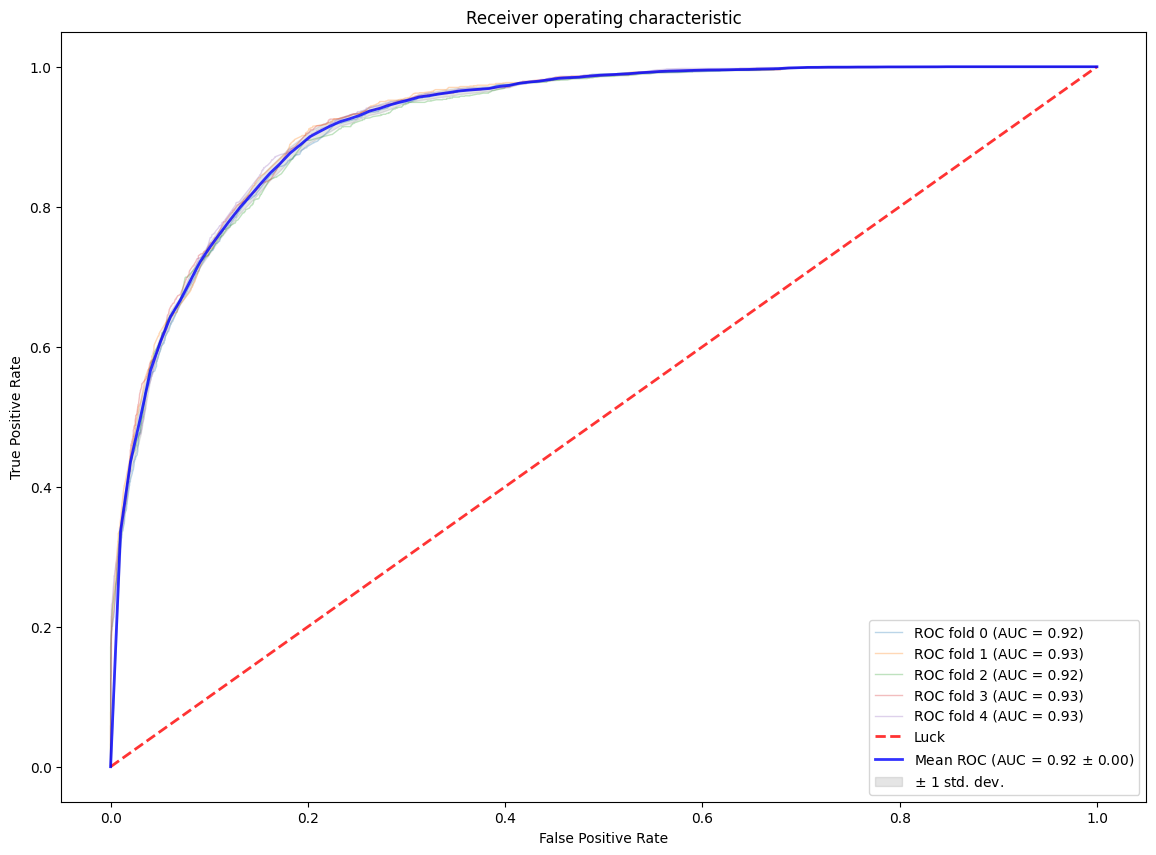

Accaracy list :  [0.8772017489069331, 0.8834478450968145, 0.8773266708307308, 0.879560219890055, 0.876311844077961]
equal opportunity for tpr :  [0.05041448012804689, 0.013548897819997574, 0.008888888888888946, 0.010108391182559906, 0.0068102629078239385]
equal opportunity for fpr :  [0.04619892343741682, 0.05071206498846655, 0.049267634946114615, 0.03581381592693471, 0.050470283426238514]
odds difference list :  [0.04830670178273186, 0.03213048140423207, 0.02907826191750178, 0.022961103554747307, 0.028640273167031226]
The mean accuracy is  0.879 ± 0.003
The mean equal opportunity for tpr: (close to 0) 0.018 ± 0.016
The mean equal opportunity for fpr: (close to 0) 0.046 ± 0.006
The mean odds difference: (close to 0) 0.032 ± 0.009
The mean parity difference: (close to 0) 0.826 ± 0.009
The mean disperate impact: (close to 1) 1.000 ± 0.000
End Of Trial Number: 130
---------------------------------------------------------------------------------------------------
Trial Number: 193
Values (

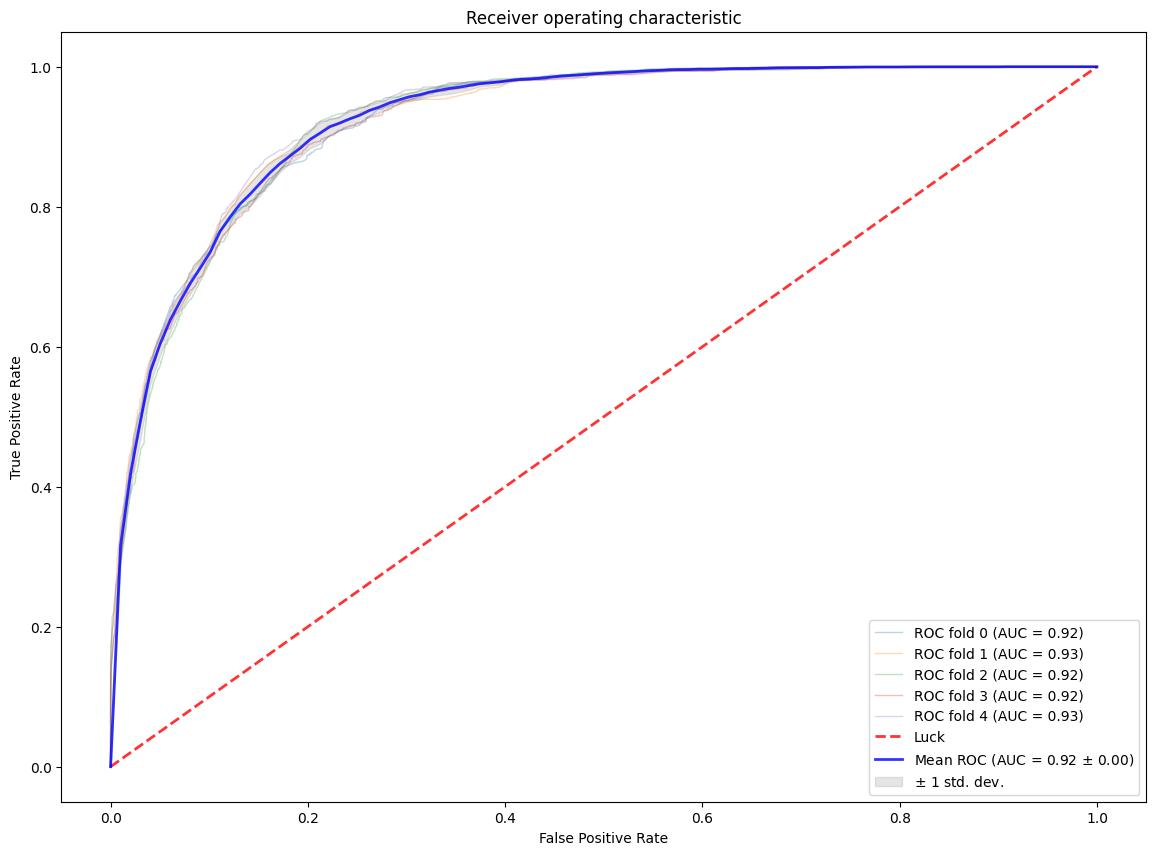

Accaracy list :  [0.8795696295390635, 0.8833598239393569, 0.8719892407384766, 0.8782247218486368, 0.8821371805844235]
equal opportunity for tpr :  [0.08673609208002192, 0.046803963121954784, 0.017818198497983828, 0.03984872701078268, 0.061399138881969906]
equal opportunity for fpr :  [0.04904528963036467, 0.04284223566765261, 0.05013331051834831, 0.049254971768439924, 0.05051549702657391]
odds difference list :  [0.0678906908551933, 0.044823099394803695, 0.03397575450816607, 0.044551849389611306, 0.055957317954271904]
The mean accuracy is  0.879 ± 0.004
The mean equal opportunity for tpr: (close to 0) 0.051 ± 0.023
The mean equal opportunity for fpr: (close to 0) 0.048 ± 0.003
The mean odds difference: (close to 0) 0.049 ± 0.012
The mean parity difference: (close to 0) 0.835 ± 0.016
The mean disperate impact: (close to 1) 1.000 ± 0.000
End Of Trial Number: 193
---------------------------------------------------------------------------------------------------
Trial Number: 115
Values (O

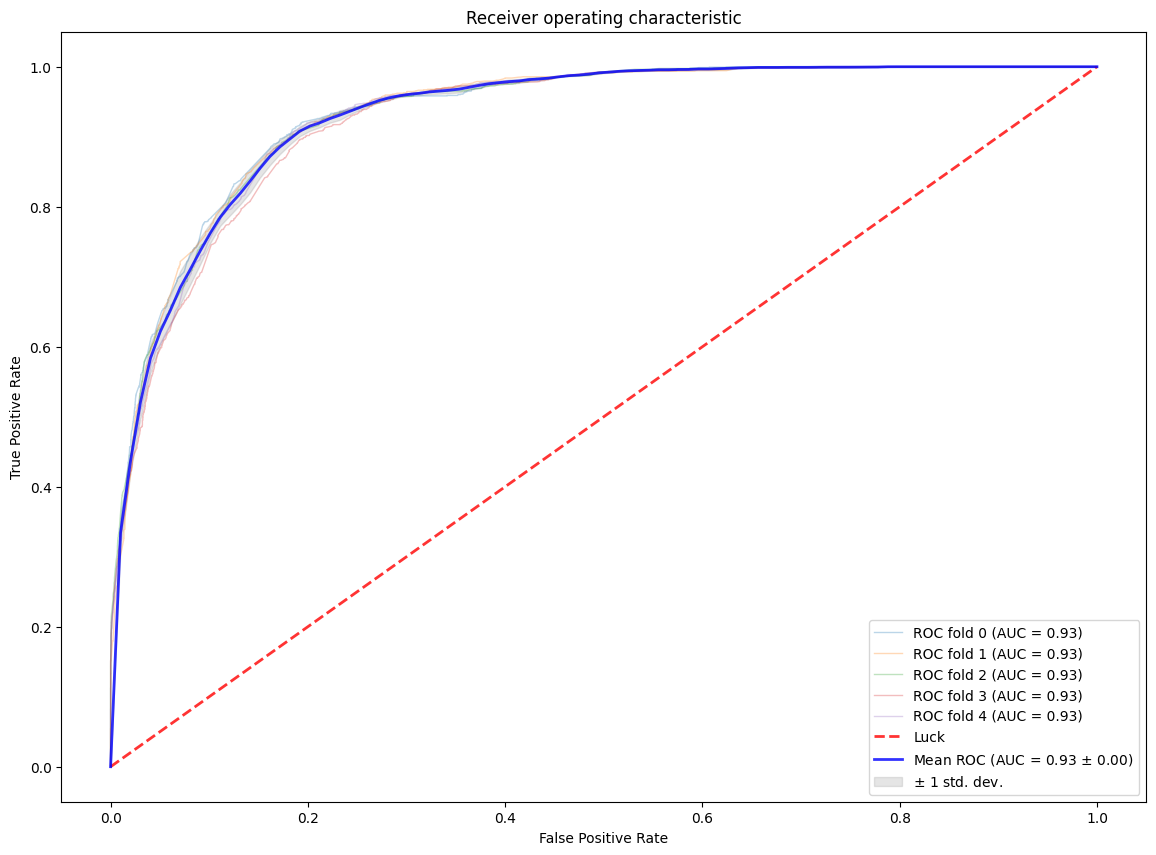

Accaracy list :  [0.8922300011477103, 0.8874096178124641, 0.8886593204775023, 0.8816574839302111, 0.8842975206611571]
equal opportunity for tpr :  [0.043269972565828874, 0.007048441023248531, 0.1443510737628385, 0.04673109205571435, 0.045159834901325135]
equal opportunity for fpr :  [0.03994265106304367, 0.051253359550785284, 0.047350515463917525, 0.05594816425189288, 0.04909634069768195]
odds difference list :  [0.041606311814436275, 0.029150900287016907, 0.09585079461337802, 0.05133962815380362, 0.047128087799503546]
The mean accuracy is  0.887 ± 0.004
The mean equal opportunity for tpr: (close to 0) 0.057 ± 0.046
The mean equal opportunity for fpr: (close to 0) 0.049 ± 0.005
The mean odds difference: (close to 0) 0.053 ± 0.023
The mean parity difference: (close to 0) 0.795 ± 0.027
The mean disperate impact: (close to 1) 1.000 ± 0.000
End Of Trial Number: 115
---------------------------------------------------------------------------------------------------
Trial Number: 102
Values (

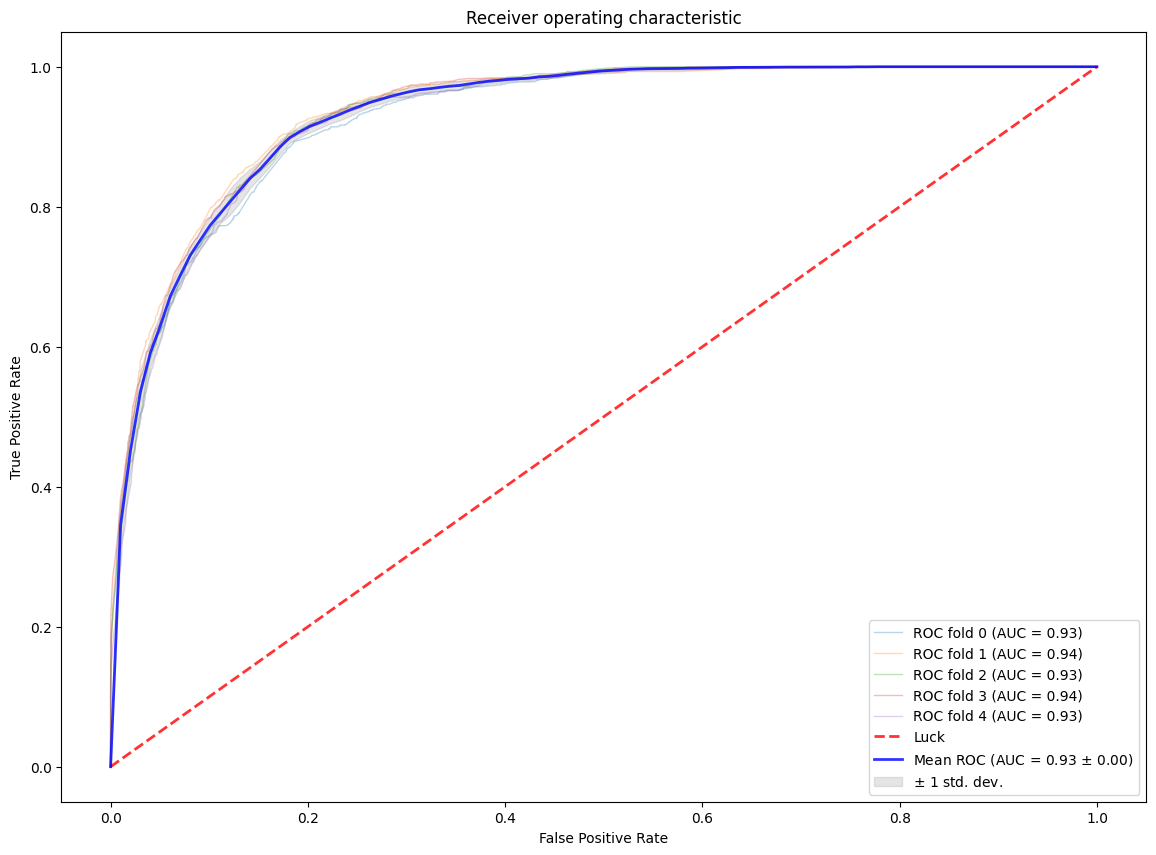

Accaracy list :  [0.892032007212893, 0.8947368421052632, 0.8853826214358165, 0.893034265103697, 0.8848061316501352]
equal opportunity for tpr :  [0.06114261260297427, 0.009168662333219335, 0.012842303329242244, 0.10947467872879446, 0.0332023949989374]
equal opportunity for fpr :  [0.05639033528941786, 0.045860971570777016, 0.050440363508306926, 0.0384764118913071, 0.05219822206862124]
odds difference list :  [0.058766473946196066, 0.027514816951998176, 0.031641333418774585, 0.07397554531005078, 0.04270030853377932]
The mean accuracy is  0.890 ± 0.004
The mean equal opportunity for tpr: (close to 0) 0.045 ± 0.037
The mean equal opportunity for fpr: (close to 0) 0.049 ± 0.006
The mean odds difference: (close to 0) 0.047 ± 0.017
The mean parity difference: (close to 0) 0.798 ± 0.011
The mean disperate impact: (close to 1) 1.000 ± 0.000
End Of Trial Number: 102
---------------------------------------------------------------------------------------------------
Trial Number: 54
Values (Objec

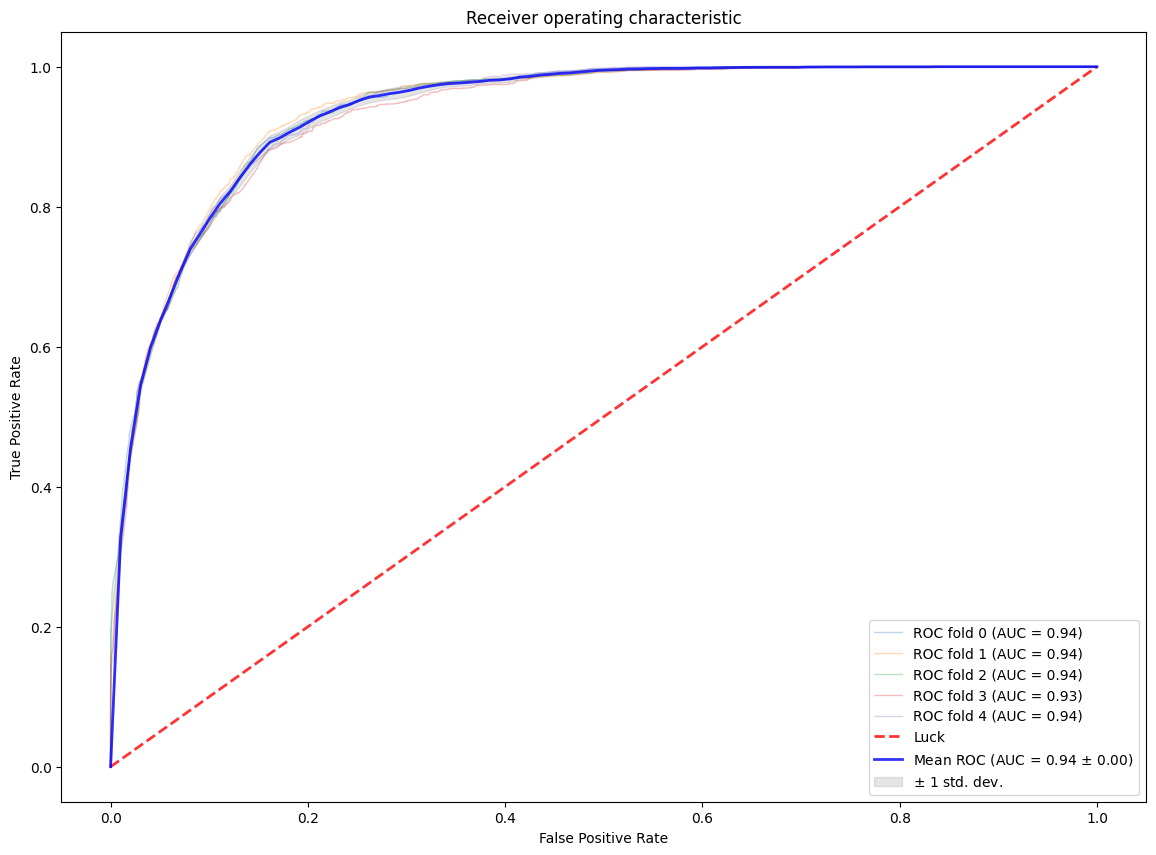

Accaracy list :  [0.8985939497230507, 0.8949611164376265, 0.8935762224352828, 0.8928305102801747, 0.8971982529029509]
equal opportunity for tpr :  [0.07295631198070218, 0.046420978029766136, 0.07923174673057104, 0.17335393596016818, 0.1002079967903034]
equal opportunity for fpr :  [0.04740705098333308, 0.042358443348621974, 0.05411026086300296, 0.048466800223798435, 0.04610226870266017]
odds difference list :  [0.060181681482017635, 0.044389710689194055, 0.066671003796787, 0.1109103680919833, 0.07315513274648178]
The mean accuracy is  0.895 ± 0.002
The mean equal opportunity for tpr: (close to 0) 0.094 ± 0.043
The mean equal opportunity for fpr: (close to 0) 0.048 ± 0.004
The mean odds difference: (close to 0) 0.071 ± 0.022
The mean parity difference: (close to 0) 0.863 ± 0.019
The mean disperate impact: (close to 1) 1.000 ± 0.000
End Of Trial Number: 54
---------------------------------------------------------------------------------------------------
Trial Number: 181
Values (Objecti

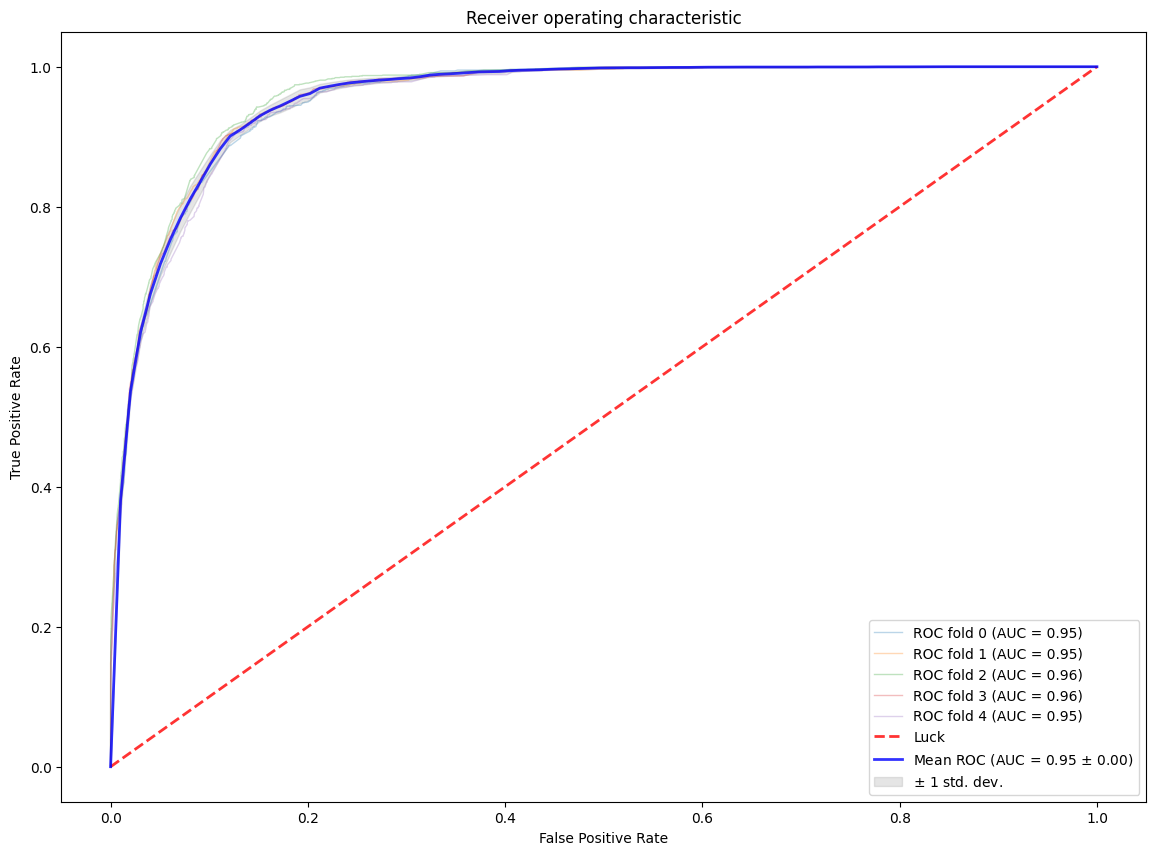

Accaracy list :  [0.9222833044656977, 0.9212983883114927, 0.9233318270823919, 0.9249887031179395, 0.9219008886880554]
equal opportunity for tpr :  [0.00420467670838931, 0.06517894547427783, 0.06019394546021983, 0.0035343549184378986, 0.02555949004339686]
equal opportunity for fpr :  [0.04738981485318176, 0.052539355391559364, 0.05348939563420505, 0.05028224829791633, 0.05062739206636437]
odds difference list :  [0.025797245780785533, 0.058859150432918596, 0.05684167054721244, 0.026908301608177115, 0.03809344105488062]
The mean accuracy is  0.923 ± 0.001
The mean equal opportunity for tpr: (close to 0) 0.032 ± 0.027
The mean equal opportunity for fpr: (close to 0) 0.051 ± 0.002
The mean odds difference: (close to 0) 0.041 ± 0.014
The mean parity difference: (close to 0) 0.751 ± 0.017
The mean disperate impact: (close to 1) 1.000 ± 0.000
End Of Trial Number: 181
---------------------------------------------------------------------------------------------------
Trial Number: 71
Values (Ob

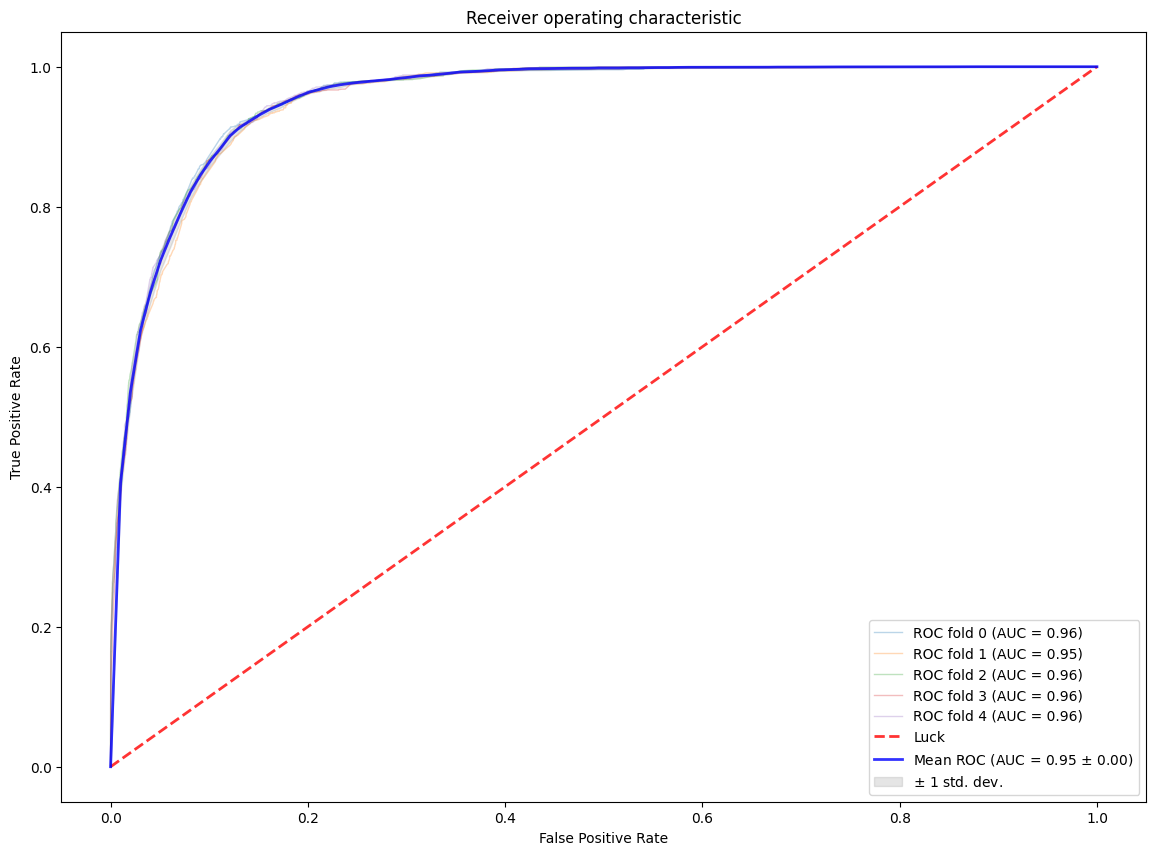

Accaracy list :  [0.9210546082776234, 0.9224817847217006, 0.9233831593179599, 0.9221003605769231, 0.9232271634615384]
equal opportunity for tpr :  [0.021825255095032192, 0.13097477286458514, 0.11528537627271068, 0.11032188356183259, 0.01661240251381846]
equal opportunity for fpr :  [0.05778678049592289, 0.05471160078832751, 0.047231804141027636, 0.04876363636363636, 0.05011112174614817]
odds difference list :  [0.039806017795477544, 0.09284318682645633, 0.08125859020686915, 0.07954275996273448, 0.03336176212998332]
The mean accuracy is  0.922 ± 0.001
The mean equal opportunity for tpr: (close to 0) 0.079 ± 0.049
The mean equal opportunity for fpr: (close to 0) 0.052 ± 0.004
The mean odds difference: (close to 0) 0.065 ± 0.024
The mean parity difference: (close to 0) 0.715 ± 0.020
The mean disperate impact: (close to 1) 1.000 ± 0.000
End Of Trial Number: 71
---------------------------------------------------------------------------------------------------
Trial Number: 60
Values (Object

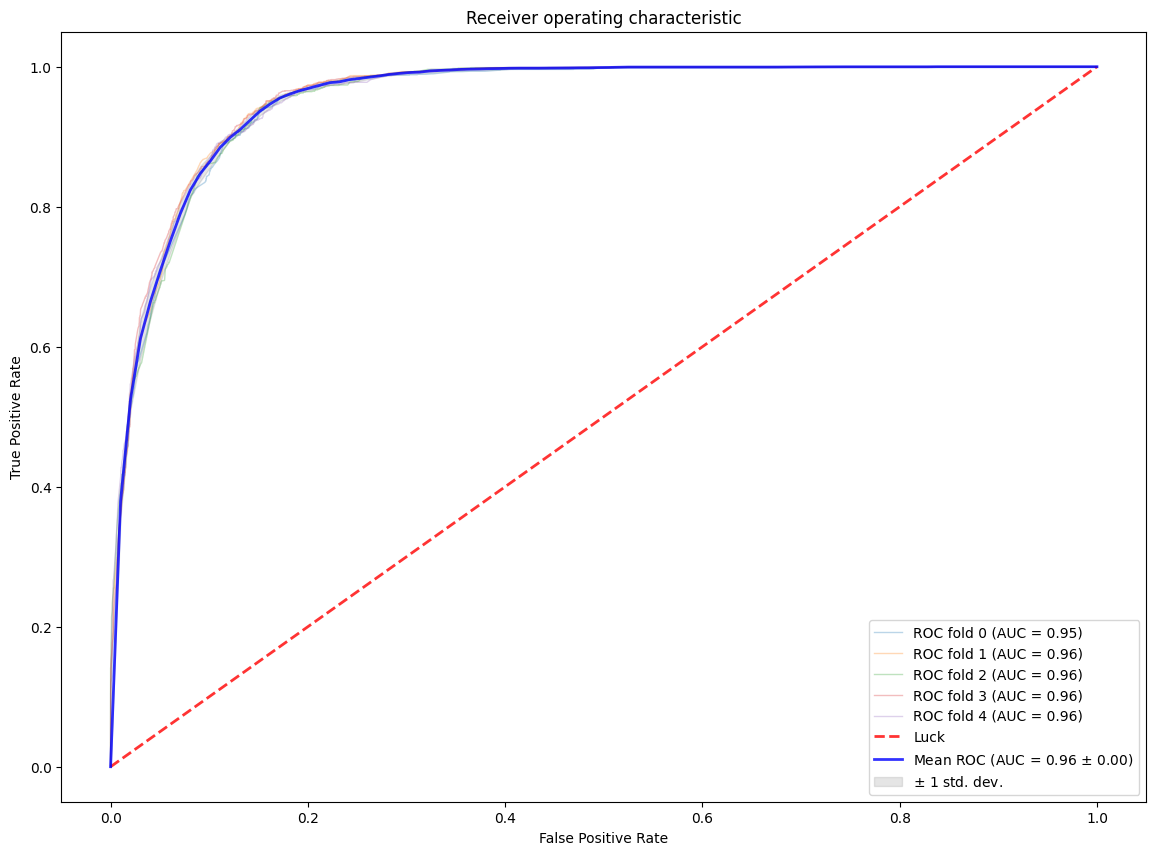

Accaracy list :  [0.9202468007312614, 0.9219226081657526, 0.9237507617306521, 0.9239031078610603, 0.9235164165460501]
equal opportunity for tpr :  [0.19292158223455935, 0.23470736690301647, 0.15587265592751864, 0.21316993221971187, 0.18965919701213818]
equal opportunity for fpr :  [0.05133010301016357, 0.04654155449054538, 0.04927463731865933, 0.057212121212121214, 0.049817177513417535]
odds difference list :  [0.12212584262236147, 0.14062446069678092, 0.10257364662308899, 0.13519102671591654, 0.11973818726277785]
The mean accuracy is  0.923 ± 0.001
The mean equal opportunity for tpr: (close to 0) 0.197 ± 0.026
The mean equal opportunity for fpr: (close to 0) 0.051 ± 0.004
The mean odds difference: (close to 0) 0.124 ± 0.013
The mean parity difference: (close to 0) 0.907 ± 0.004
The mean disperate impact: (close to 1) 1.000 ± 0.000
End Of Trial Number: 60
---------------------------------------------------------------------------------------------------
Trial Number: 62
Values (Objecti

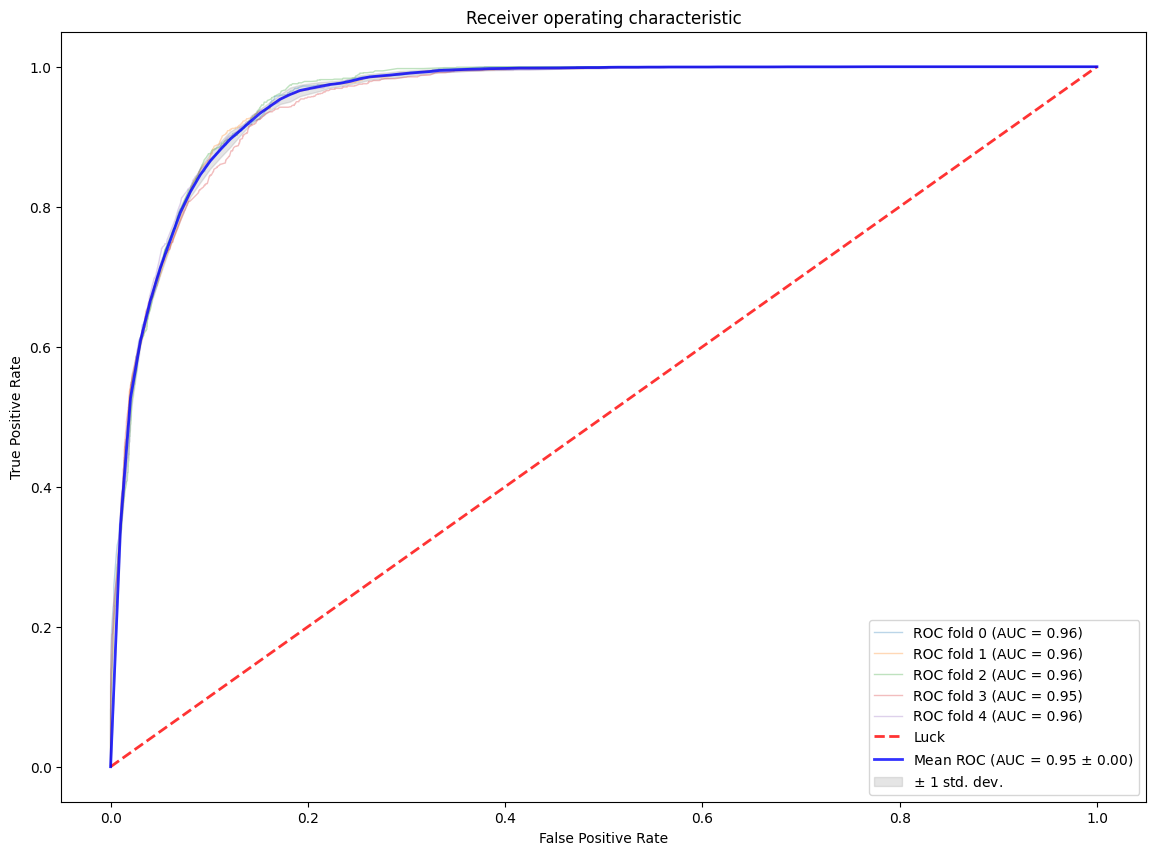

Accaracy list :  [0.9254994662193076, 0.9237456153728839, 0.9207656524060093, 0.9258750857927248, 0.9220620758026385]
equal opportunity for tpr :  [0.3486541140520379, 0.22383054345333636, 0.3401512155049138, 0.3906793786252417, 0.40427549154608455]
equal opportunity for fpr :  [0.04720931788067247, 0.0463101297185649, 0.05538694992412747, 0.04267701260911736, 0.05400380398638569]
odds difference list :  [0.19793171596635517, 0.13507033658595063, 0.19776908271452062, 0.21667819561717955, 0.22913964776623513]
The mean accuracy is  0.924 ± 0.002
The mean equal opportunity for tpr: (close to 0) 0.342 ± 0.064
The mean equal opportunity for fpr: (close to 0) 0.049 ± 0.005
The mean odds difference: (close to 0) 0.195 ± 0.032
The mean parity difference: (close to 0) 0.966 ± 0.013
The mean disperate impact: (close to 1) 1.000 ± 0.000
End Of Trial Number: 62
---------------------------------------------------------------------------------------------------
Trial Number: 153
Values (Objectives):

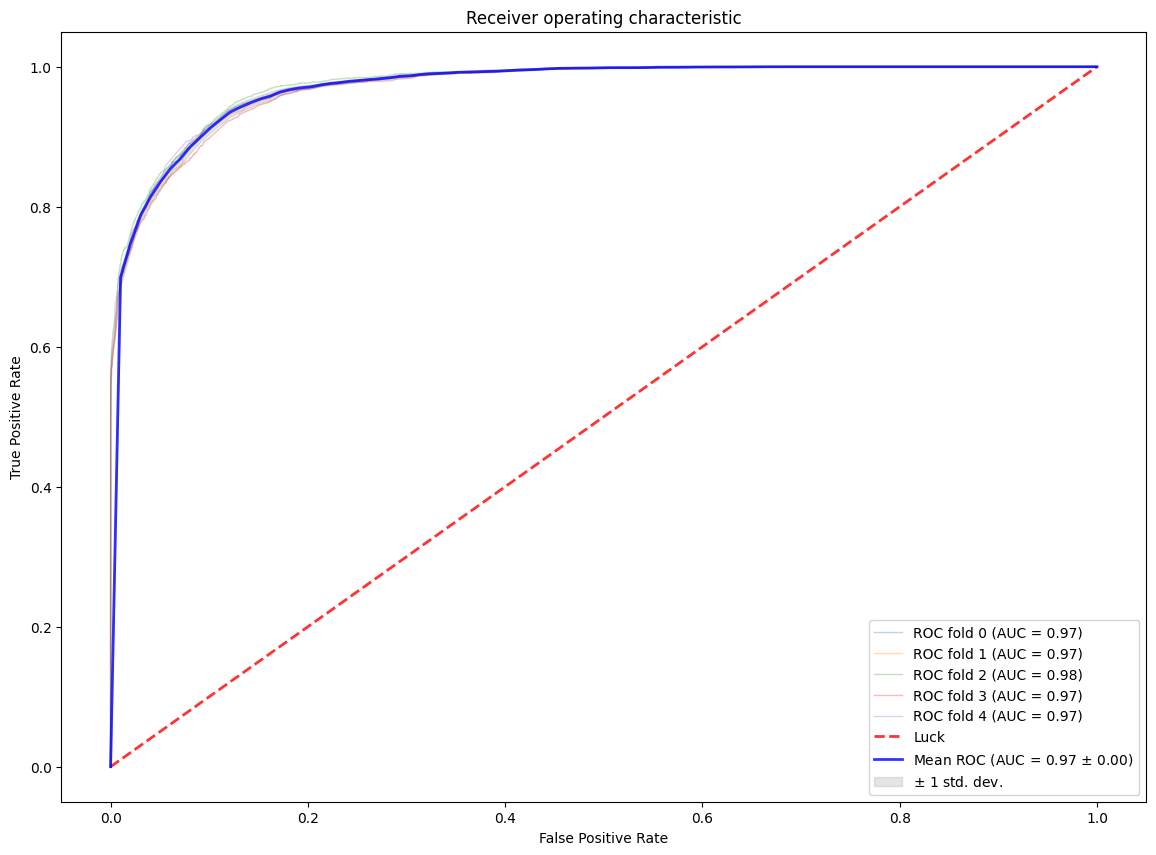

Accaracy list :  [0.9214456584987393, 0.9231266567530872, 0.9267425320056899, 0.9194361825940773, 0.9246088193456614]
equal opportunity for tpr :  [0.5098668296430418, 0.46006753151355134, 0.46509271137026237, 0.5578624142240733, 0.49907794764836383]
equal opportunity for fpr :  [0.04123280383066048, 0.06145712648684993, 0.05743021935495464, 0.03748493166902974, 0.043420564462051864]
odds difference list :  [0.27554981673685114, 0.26076232900020063, 0.2612614653626085, 0.29767367294655156, 0.27124925605520783]
The mean accuracy is  0.923 ± 0.003
The mean equal opportunity for tpr: (close to 0) 0.498 ± 0.035
The mean equal opportunity for fpr: (close to 0) 0.048 ± 0.009
The mean odds difference: (close to 0) 0.273 ± 0.013
The mean parity difference: (close to 0) 0.468 ± 0.023
The mean disperate impact: (close to 1) 1.000 ± 0.000
End Of Trial Number: 153
---------------------------------------------------------------------------------------------------


In [33]:
# Record the end time
end_time = time.time()
# Calculate the elapsed time in minutes
elapsed_time_minutes = (end_time - start_time) / 60

pareto_front_trials = study.best_trials
pareto_front_trials = sorted(pareto_front_trials, key=lambda trial: trial.values[0])


trail_list = []
fairness_values_list = []

acc_values_list = []
growth_list = []

# Process each trial in the Pareto front
for trial in pareto_front_trials:
   trail_list.append(trial.number)
   fairness_values_list.append(trial.values[0])
   acc_values_list.append(trial.values[1])

   lambda1 = trial.params['lambda_0']
   lambda2 = trial.params['lambda_1']
   upsampled_df = Upsampling_Dataset(lambda1,lambda2)
   growth_list.append((len(upsampled_df) - len(orig_data))/ len(orig_data) * 100 )

   print("Trial Number:", trial.number)
   print("Values (Objectives):", trial.values)
   print("Parameters:", trial.params)
   print("Dataset Growth Percent :", (len(upsampled_df) - len(orig_data))/ len(orig_data) * 100)
   print('---------------------------------------------------------------------------------------------------')
   y_debias = upsampled_df[TARGET_COL]
   upsampled_df_features = upsampled_df.loc[:, feature_columns]
   upsampled_acc ,upsampled_op_diff, upsampled_op_diff_fpr, upsampled_od_diff, upsampled_par_diff , upsampled_dis_impact  = fairness_metrics_roc_auc_std(upsampled_df_features, y_debias )

   print("End Of Trial Number:", trial.number)
   print('---------------------------------------------------------------------------------------------------')




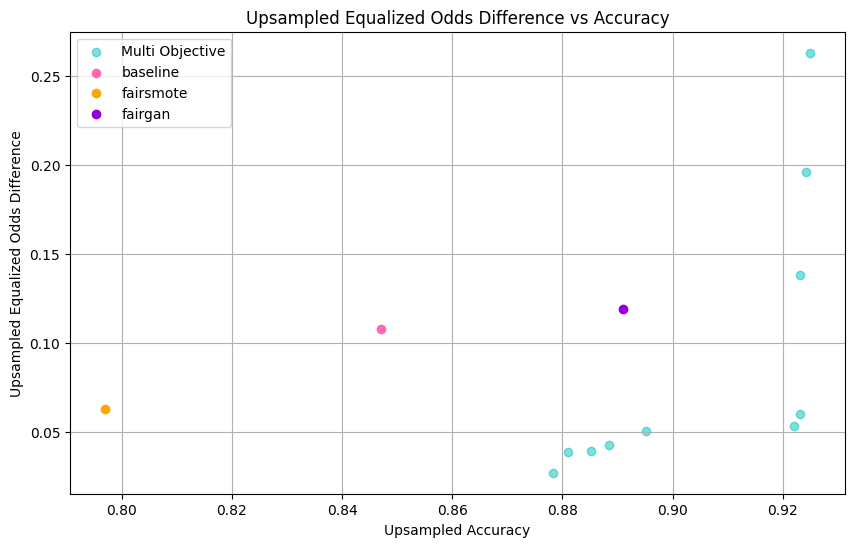

In [37]:
import matplotlib.pyplot as plt

# Plot upsampled_op_diff against upsampled_acc
plt.figure(figsize=(10, 6))
plt.scatter(acc_values_list,fairness_values_list, alpha=0.5,color = 'c', label = 'Multi Objective')

# Add the three additional points
plt.scatter(0.847, 0.108, color='hotpink', label='baseline')  # Baseline point
plt.scatter(0.797, 0.063, color='orange', label='fairsmote')  # Fairsmote point
plt.scatter(0.891, 0.119, color='darkviolet', label='fairgan')  # Fairgan point

plt.xlabel('Upsampled Accuracy')
plt.ylabel('Upsampled Equalized Odds Difference')
plt.title('Upsampled Equalized Odds Difference vs Accuracy')
plt.grid(True)
plt.legend()  # Show legend with labels
plt.show()

conf matrix:
  [[4353  178]
 [ 719  783]] 
accuracy:  0.8513177523620089 precision:  0.8147762747138397 recall:  0.5213049267643143 fpr:  0.03928492606488634 tpr:  0.5213049267643143 fn+fp 897
conf matrix:
  [[484   7]
 [ 39  31]] 
accuracy:  0.9180035650623886 precision:  0.8157894736842105 recall:  0.44285714285714284 fpr:  0.014256619144602852 tpr:  0.44285714285714284 fn+fp 46
conf matrix:
  [[3869  171]
 [ 680  752]] 
accuracy:  0.8444809941520468 precision:  0.8147345612134345 recall:  0.5251396648044693 fpr:  0.04232673267326733 tpr:  0.5251396648044693 fn+fp 851
conf matrix:
  [[4359  172]
 [ 769  733]] 
accuracy:  0.8440245317420852 precision:  0.8099447513812155 recall:  0.48801597869507324 fpr:  0.037960715073935114 tpr:  0.48801597869507324 fn+fp 941
conf matrix:
  [[3871  169]
 [ 721  708]] 
accuracy:  0.8372645821905285 precision:  0.8072976054732041 recall:  0.49545136459062283 fpr:  0.041831683168316834 tpr:  0.49545136459062283 fn+fp 890
conf matrix:
  [[488   3]
 [ 48

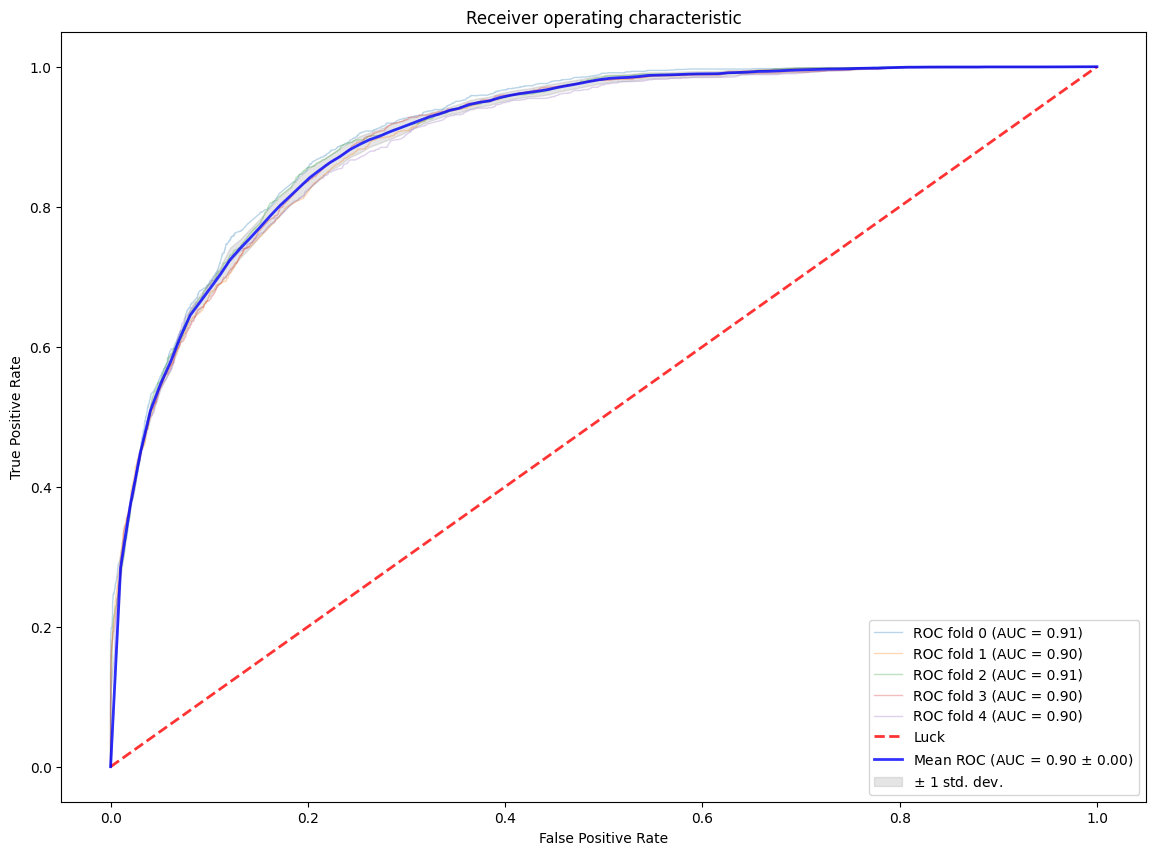

Accaracy list :  [0.8513177523620089, 0.8440245317420852, 0.8488063660477454, 0.8483090185676393, 0.8444960212201591]
equal opportunity for tpr :  [0.08228252194732644, 0.15298561116596532, 0.16527019478530375, 0.12519940179461614, 0.09096162736939434]
equal opportunity for fpr :  [0.028070113528664477, 0.03572170353491561, 0.03456036167425974, 0.04102773802221768, 0.023282221164308305]
odds difference list :  [0.05517631773799546, 0.09435365735044046, 0.09991527822978175, 0.08311356990841691, 0.05712192426685132]
The mean accuracy is  0.847 ± 0.003
The mean equal opportunity for tpr: (close to 0) 0.123 ± 0.033
The mean equal opportunity for fpr: (close to 0) 0.033 ± 0.006
The mean odds difference: (close to 0) 0.078 ± 0.019
The mean parity difference: (close to 0) 0.927 ± 0.007
The mean disperate impact: (close to 1) 1.000 ± 0.000


In [35]:
orig_acc ,orig_op_diff, orig_op_diff_fpr, orig_od_diff, orig_par_diff , orig_dis_impact  = fairness_metrics_roc_auc(orig_data_encoded, y_orig )

In [36]:
print('Running time is: ',elapsed_time_minutes)

Running time is:  12.649079676469167
